Charlotte Kruzic & Zoé Marquis  
UE Entreposage et protection des données

# Projet naiades

#### NB: Cela peut paraître long, mais nous avons dû télécharger le notebook en PDF en l'exportant précédemment en html. Nous n'avons donc pas pu régler la taille de police d'écriture.
#### Nous vous fournissons également la version `.ipynb` car elle est plus agréable à lire. Si vous n'avez pas Jupyter Notebook installé, vous pouvez l'ouvrir directement depuis votre navigateur avec Google Colab.

Ce projet s'intéresse à la relation entre les propriétés physico-chimiques de l'eau et son état biologique, avec pour objectif de mieux comprendre les interactions entre ces deux dimensions à partir de données existantes.

Nous avons cherché à déterminer si ces données permettent de révéler des modèles spatiaux pertinents, comme les hydroécorégions, et à explorer comment les différents paramètres influencent l'état des écosystèmes aquatiques.

Pour cela, nous avons appliqué des méthodes de clustering à des données collectées à diverses saisons, tout en considérant un éventuel décalage temporel entre les mesures physico-chimiques et biologiques, afin de refléter la dynamique des écosystèmes. Ces données ont été soigneusement nettoyées, préparées et agrégées par saison, ce qui nous a permis d'identifier des regroupements cohérents de stations et d'en analyser les similitudes écologiques.

Par la suite, avec le décalage temporel qui nous parait le meilleur, nous avons également exploré une approche de régression pour prédire l'état biologique de l'eau (I2M2) à partir des paramètres physico-chimiques, de l'hydroécorégion de la station et de la temporalité. Cette approche vise à évaluer la capacité des facteurs physicochimiques à expliquer et prédire l'état des écosystèmes aquatiques (hydrobiologiques dans ce cas), en tenant compte de la complexité et de la variabilité des interactions.


--- 

## Importation des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as geom
from shapely import geometry as geom
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.stats import zscore
import zstandard as zstd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.preprocessing import LabelEncoder

## Chargement des données

In [2]:
# stations
df_load_stations = pd.read_csv('data/stations_hb.csv.zst',sep=';',escapechar = '\\')
df_stations = df_load_stations.copy() # copy pour nettoyer etc mais garder l'original pour recuperer les infos

In [3]:
# pc : physicochimie
f="data/donnees_physicochimie.csv.zst"
pc_sample = pd.read_csv(f,nrows=1)
pc_list_cols = pc_sample.columns
pc_list_cat = pc_list_cols[pc_list_cols.str.startswith((
    'Lb','Nom','Mnemo',
    'Cd','Sym','Com'))]
pc_dict_cat = {col: 'category' for col in pc_list_cat}
df_load_pc = pd.read_csv(
        f,
        sep=',',
        engine='c',
        escapechar='\\',
        dtype=pc_dict_cat,
        parse_dates=[7],
        iterator=False)
df_pc = df_load_pc.copy()

In [4]:
# hydrobio
df_load_hydrobio = pd.read_csv('data/donnees_hydrobio.csv.zst',sep=',',escapechar = '\\')
df_hydrobio = df_load_hydrobio.copy()

In [5]:
# hydroecoregion
df_load_hydroregions = gpd.read_file("data/Hydroecoregion1-shp.zip")
df_hydroregions = df_load_hydroregions.copy()


---

## Analyse exploratoire

### Objectifs

L'objectif principal de cette analyse exploratoire est de comprendre le contenu de chaque jeu de données utilisé dans le projet, d'identifier les colonnes pertinentes ainsi que celles qui peuvent être supprimées, et de déterminer comment remodeler les données pour les rendre exploitables pour l'analyse.

### Description des jeux de données

Le projet repose sur plusieurs jeux de données, comprenant des mesures physico-chimiques, des informations hydrobiologiques, des données sur les stations de mesure, et des données géographiques des hydroécorégions.

1. Les **données des stations de mesure** fournissent des informations nécessaires pour localiser chaque station de mesure (latitude et longitude), ainsi que des identifiants uniques permettant de relier les stations entre les différents jeux de données.

2. Les **données physico-chimiques** contiennent les mesures physico-chimiques des eaux (par exemple, nitrates, phosphates, pH...). Chaque mesure est associée à une station, à une date, ainsi qu'à un support et une fraction d'analyse spécifique.

3. Les **données hydrobiologiques** comprennent l'indice écologique I2M2 évaluant la qualité biologique des eaux. Ces indices sont liés aux stations et aux dates de prélèvement.

3. Les **données des hydroécorégions** sont des unités spatiales définies sur la base de critères écologiques similaires, et permettent de classifier les différents milieux aquatiques à travers la France.

### Exploration des données géographiques

In [6]:
df_stations.head(3)

CdStationMesureEauxSurface       LbStationMesureEauxSurface  \
0                   01000477          LA SLACK À RINXENT (62)   
1                   01000602  COLOGNE à BUIRE COURCELLES (80)   
2                   01000605          L'OMIGNON À DEVISE (80)   

   DurStationMesureEauxSurface  CoordXStationMesureEauxSurface  \
0                          NaN                       610228.78   
1                          NaN                       700318.40   
2                          NaN                       700279.85   

   CoordYStationMesureEauxSurface  CdProjStationMesureEauxSurface  \
0                      7078879.90                              26   
1                      6980033.60                              26   
2                      6973284.26                              26   

    LibelleProjection CodeCommune         LbCommune CodeDepartement  ...  \
0  RGF93 / Lambert 93       62711           RINXENT              62  ...   
1  RGF93 / Lambert 93       80150  BUIRE-COURCELLES              80  ...   
2  RGF93 / Lambert 93       80239            DEVISE              80  ...   

  DateMAJInfosStationMesureEauxSurface  FinaliteStationMesureEauxSurface  \
0                  2015-12-14 00:00:00                               NaN   
1                  2015-12-14 00:00:00                               NaN   
2                  2015-12-14 00:00:00                               NaN   

               LocPreciseStationMesureEauxSurface  \
0  Lieu-dit Ferme du Château. La Planche du Devin   
1                   MOULIN DE BINARD PONT D 194 E   
2                               ROUTE DE L'EGLISE   

  CodeNatureStationMesureEauxSurface LibelleNatureStationMesureEauxSurface  \
0                                  M            Station de mesure Manuelle   
1                                  M            Station de mesure Manuelle   
2                                  M            Station de mesure Manuelle   

  AltitudePointCaracteritisque PkPointTronconEntiteHydroPrincipale  \
0                          0.0                              980.48   
1                          0.0                              992.58   
2                          0.0                              993.69   

  PremierMoisAnneeEtiage SuperficieBassinVersantReel  \
0                    6.0                         NaN   
1                    6.0                         NaN   
2                    6.0                         NaN   

  SuperficieBassinVersantTopo  
0                         0.0  
1                         0.0  
2                         0.0  

[3 rows x 39 columns]

La table station est utile pour situer les stations ainsi que pour extraire l'identifiant pour joindre les tables sur les stations.

In [7]:
df_hydroregions.head(3)

gid  CdHER1     NomHER1                                           geometry
0    1      16       CORSE  POLYGON ((9.43319 43.00468, 9.4357 42.99999, 9...
1    2      12  ARMORICAIN  POLYGON ((-2.61068 48.55022, -2.61268 48.54898...
2    3      13      LANDES  MULTIPOLYGON (((-1.04228 45.54443, -1.03836 45...

In [8]:
# On vérifie qu'un code d'hydroécorégion (CdHER1) correspond bien à un seul nom d'hydroécorégion (NomHER1)
print(df_hydroregions['CdHER1'].value_counts())

CdHER1
16    1
12    1
13    1
14    1
1     1
11    1
21    1
2     1
7     1
20    1
18    1
4     1
15    1
8     1
19    1
5     1
6     1
17    1
3     1
9     1
10    1
22    1
Name: count, dtype: int64


On a bien un CdHER1 pour un NomHER1, donc on va afficher la carte avec NomHER1 car cela est plus parlant pour l'utilisateur.

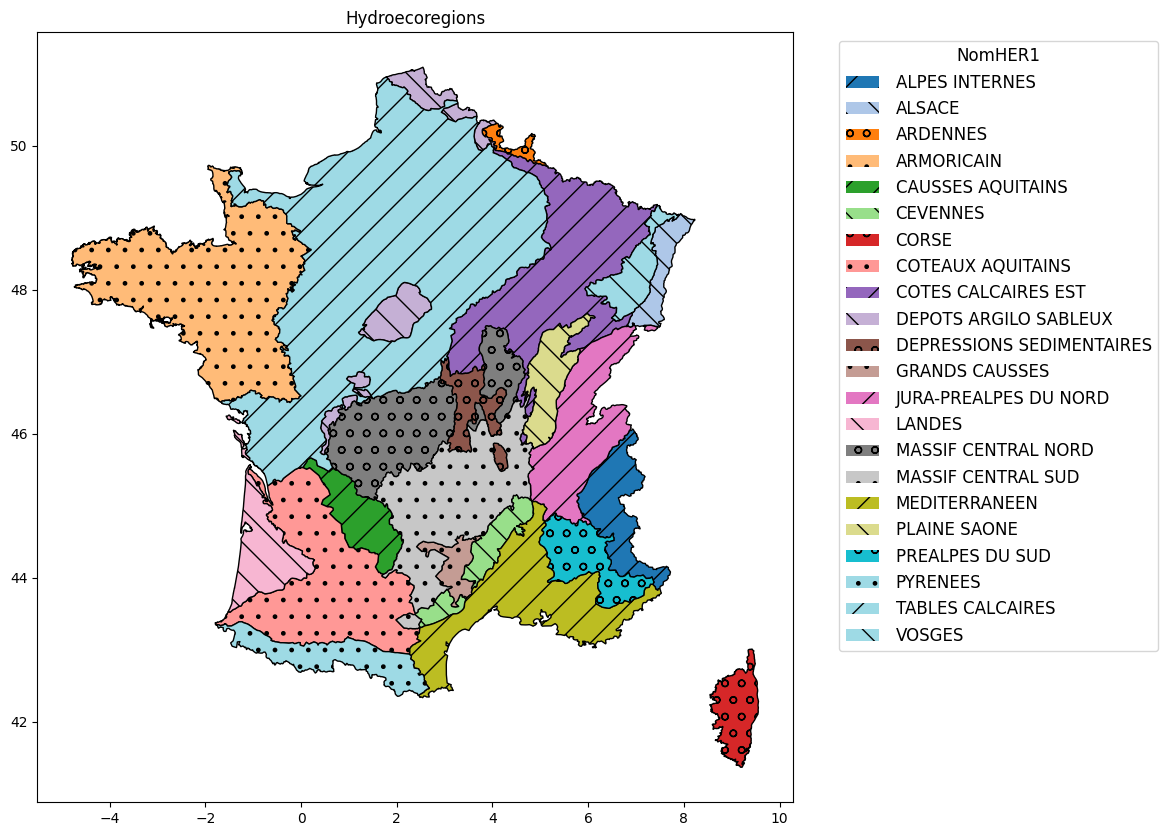

In [9]:
# Affichage des hydroeco regions
fig, ax = plt.subplots(figsize=(20, 10))
colors = plt.colormaps['tab20']
hatches = ['/', '\\', 'o', '.']
legend_elements = []
for i, (name, region) in enumerate(df_hydroregions.groupby('NomHER1')):
    patch = region.plot(ax=ax, color=colors(i), hatch=hatches[i % len(hatches)], edgecolor='black', label=name)
    legend_elements.append(Patch(facecolor=colors(i), hatch=hatches[i % len(hatches)], label=name))
ax.set_title('Hydroecoregions')
ax.legend(handles=legend_elements, title='NomHER1', bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize='large', title_fontsize='large', handletextpad=1)
plt.show()

Nous allons maintenant situer les différentes stations sur la carte des hydroécorégions.

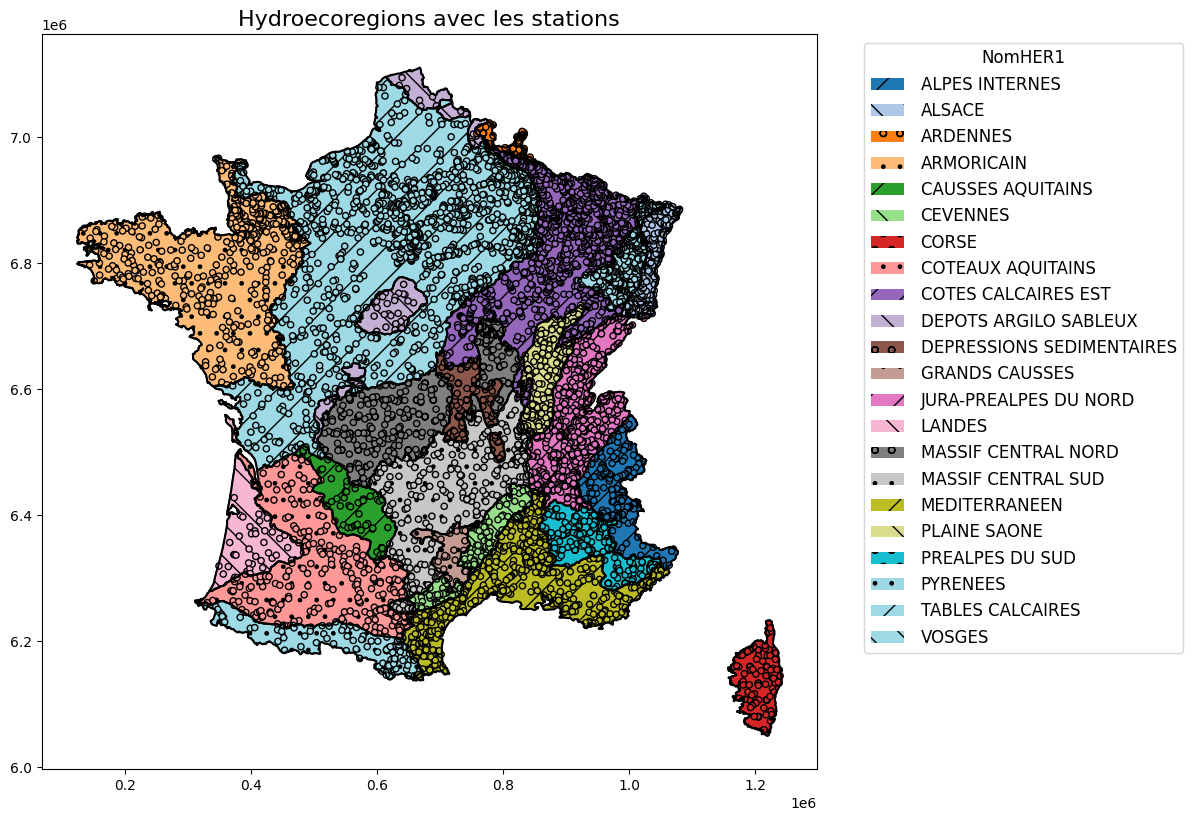

In [10]:
# Affichage des stations sur les hydroecoregions
crs_lambert = 'PROJCS["RGF_1993_Lambert_93",GEOGCS["GCS_RGF_1993",DATUM["D_RGF_1993",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",700000.0],PARAMETER["False_Northing",6600000.0],PARAMETER["Central_Meridian",3.0],PARAMETER["Standard_Parallel_1",49.0],PARAMETER["Standard_Parallel_2",44.0],PARAMETER["Latitude_Of_Origin",46.5],UNIT["Meter",1.0]]'
x_col = 'CoordXStationMesureEauxSurface'
y_col = 'CoordYStationMesureEauxSurface'
carto_i2m2 = gpd.GeoDataFrame(df_stations,crs=crs_lambert, geometry = gpd.GeoSeries(df_stations.agg(lambda x:geom.Point(x.loc[x_col],x.loc[y_col])  ,axis=1)))
HER_stations=carto_i2m2.sjoin(df_hydroregions.to_crs(crs_lambert),predicate='within').to_crs(crs_lambert)
fig, ax = plt.subplots(1, 1, figsize=(10, 30))
colors = plt.colormaps['tab20']
hatches = ['/', '\\', 'o', '.']
legend_elements = []
color_mapping = {}
for i, (name, region) in enumerate(df_hydroregions.groupby('NomHER1')):
    region = region.to_crs(crs_lambert)
    patch = region.plot(ax=ax, color=colors(i), hatch=hatches[i % len(hatches)], edgecolor='black', label=name)
    legend_elements.append(Patch(facecolor=colors(i), hatch=hatches[i % len(hatches)], label=name))
    color_mapping[name] = colors(i)
station_colors = HER_stations['NomHER1'].map(color_mapping)
HER_stations.plot(ax=ax, color=station_colors, markersize=20, edgecolor='black')
HER_lambert = df_hydroregions.to_crs(crs_lambert)
HER_lambert.boundary.plot(ax=ax, color='black')
ax.legend(handles=legend_elements, title='NomHER1', bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize='large', title_fontsize='large', handletextpad=1)
ax.set_title('Hydroecoregions avec les stations', fontsize=16)
plt.show()

Nous observons maintenant la répartition des stations dans les différentes hydroécorégions.

In [11]:
stations_par_hydroecoregion = HER_stations.groupby('NomHER1').size().reset_index(name='nombre_de_stations')
print(stations_par_hydroecoregion)

                      NomHER1  nombre_de_stations
0              ALPES INTERNES                 156
1                      ALSACE                 352
2                    ARDENNES                  63
3                  ARMORICAIN                 445
4           CAUSSES AQUITAINS                  47
5                    CEVENNES                 106
6                       CORSE                  63
7           COTEAUX AQUITAINS                 265
8         COTES CALCAIRES EST                1008
9       DEPOTS ARGILO SABLEUX                  47
10  DEPRESSIONS SEDIMENTAIRES                  63
11             GRANDS CAUSSES                  25
12      JURA-PREALPES DU NORD                 632
13                     LANDES                  38
14        MASSIF CENTRAL NORD                 221
15         MASSIF CENTRAL SUD                 264
16              MEDITERRANEEN                 574
17               PLAINE SAONE                 223
18            PREALPES DU SUD                 167


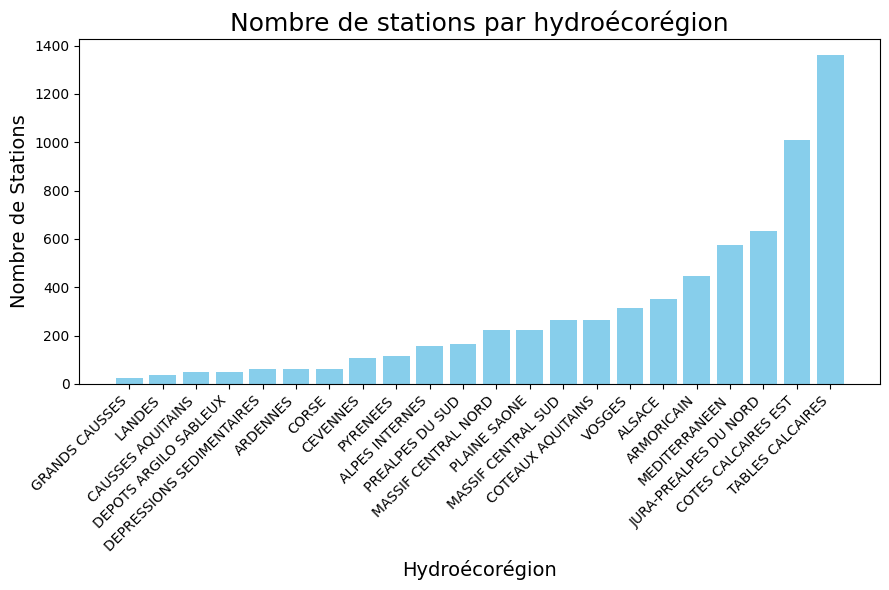

In [12]:
stations_par_hydroecoregion = stations_par_hydroecoregion.sort_values(by='nombre_de_stations', ascending=True)

plt.figure(figsize=(9, 6))
plt.bar(stations_par_hydroecoregion['NomHER1'], stations_par_hydroecoregion['nombre_de_stations'], color='skyblue')
plt.title('Nombre de stations par hydroécorégion', fontsize=18)
plt.xlabel('Hydroécorégion', fontsize=14)
plt.ylabel('Nombre de Stations', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Nous pouvons voir que la répartition des stations n'est pas uniforme, et que le nombre de stations par hydroécorégion peut varier de 25 à 1360.
Cela pourrait rendre la caractérisation plus complexe, d'autant plus que nous ne savons pas encore combien de stations seront disponibles après la préparation des données.

### Exploration des données physico-chimiques et hydrobiologiques

#### Physico-chimiques

In [13]:
df_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8917443 entries, 0 to 8917442
Data columns (total 49 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   CdStationMesureEauxSurface  category      
 1   LbStationMesureEauxSurface  category      
 2   CdSupport                   category      
 3   LbSupport                   category      
 4   CdFractionAnalysee          category      
 5   LbFractionAnalysee          category      
 6   CdPrelevement               category      
 7   DatePrel                    datetime64[ns]
 8   HeurePrel                   object        
 9   CdParametre                 category      
 10  LbLongParamètre             category      
 11  RsAna                       float64       
 12  CdUniteMesure               category      
 13  SymUniteMesure              category      
 14  CdRqAna                     category      
 15  MnemoRqAna                  category      
 16  CdInsituAna       

In [14]:
df_pc.shape

(8917443, 49)

#### Hydro-biologiques

In [15]:
df_hydrobio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43535 entries, 0 to 43534
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          43535 non-null  int64  
 1   CdStationMesureEauxSurface          43535 non-null  int64  
 2   LbStationMesureEauxSurface          43535 non-null  object 
 3   CdPointEauxSurf                     43115 non-null  float64
 4   DateDebutOperationPrelBio           43535 non-null  object 
 5   CdSupport                           43535 non-null  int64  
 6   LbSupport                           43535 non-null  object 
 7   DtProdResultatBiologique            14829 non-null  object 
 8   CdParametreResultatBiologique       43535 non-null  int64  
 9   LbLongParametre                     43535 non-null  object 
 10  ResIndiceResultatBiologique         43522 non-null  float64
 11  CdUniteMesure                       43535

In [16]:
df_hydrobio.shape

(43535, 21)

## Préparation des données physicochimiques

### Démarche

Dans le cadre de ce projet, nous devons exploiter à la fois les données temporelles et spatiales à notre disposition. Notre principal objectif est d'utiliser les données temporelles (combinaison de données physicochimiques et hydrobiologiques) pour effectuer un clustering. Puis d'essayer de mettre en évidence les impacts des données physico-chimiques sur les données hydrobiologiques. 

Les données physicochimiques sont composées d'environ de 9 millions de points de mesure, ce qui nécessite une réduction importante pour les rendre exploitables, compte tenu des limites de nos ressources informatiques. Nous avons procédé en 2 étape :

- **Nettoyage des données** : La première étape a été le nettoyage des données. Les duplicatas et les valeurs aberrantes ont été supprimés. Cependant, compte tenu la quantité de données, nous ne pouvions pas visualiser l'intégralité ni effectuer des analyses sur chaque point individuellement. Nous avons donc mis en place des stratégies pour nettoyer les données sans pour autant perdre des informations significatives.

- **Aggrégation des données** : Nous avons ensuite agrégé les données par stations, par saison et par année, afin de réduire la variabilité et de faciliter l'analyse des tendances. Pour chaque paramètre, nous avons calculé des statistiques résumées telles que la médiane et la moyenne, dans le but de conserver un maximum d'information en réduisant la taille de notre jeu de données. Nous avons également étudié les supports, les fractions, les unités de mesures, et les paramètres mesurés afin de filtrer et ne garder que les informations pertinentes pour l'étude. Et enfin, nous avons remodelé les données afin d'obtenir une table avec pour chaque station, année et saison, des valeurs agrégées pour chaque paramètre physicochimique.

### Nettoyage des données

**Hypothèse :** Nous faisons l'hypothèse que certaines colonnes dans notre jeu de données, telles que le laboratoire, le producteur, le préleveur, et le responsable de la collecte, ne sont pas directement pertinentes pour l'analyse des caractéristiques physicochimiques de l'eau.  
Ce jeu de données contient essentiellement des métadonnées relatives à la gestion des prélèvements qui ne renseignent pas sur l'état physique ou chimique de l'eau elle-même. De plus, puisque nous prévoyons d'agréger les données par saison et par année, la granularité temporelle de l'heure n'est pas pertinente , nous allons donc éliminer cette colonne.

In [17]:
# combien de données dupliquées ?
print(df_pc.duplicated().sum())

11836


In [18]:
# supprimer les doublons
df_pc.drop_duplicates(inplace=True)

#### Caractériser une analyse physico chimique

Comme vu dans le TD, ce qui caractérise une analyse c'est : 
- le support
- le paramètre
- la fraction analysée
- l'unité

In [19]:
print("Supports :", df_pc['LbSupport'].nunique(), "valeurs ->", df_pc['LbSupport'].unique().tolist())
print("Paramètres :", df_pc['LbLongParamètre'].nunique(), "valeurs ->", df_pc['LbLongParamètre'].unique().tolist())
print("Fractions :", df_pc['LbFractionAnalysee'].nunique(), "valeurs ->", df_pc['LbFractionAnalysee'].unique().tolist())
print("Unités :", df_pc['SymUniteMesure'].nunique(), "valeurs ->", df_pc['SymUniteMesure'].unique().tolist())

Supports : 5 valeurs -> ['Eau', 'Air', 'Sédiments', 'Diatomées benthiques', 'Gammares']
Paramètres : 16 valeurs -> ['Matières en suspension', 'Demande Biochimique en oxygène en 5 jours (D.B.O.5)', "Température de l'Eau", 'Potentiel en Hydrogène (pH)', 'Conductivité à 25°C', 'Oxygène dissous', 'Taux de saturation en oxygène', 'Phosphore total', 'Turbidité Formazine Néphélométrique', 'Azote Kjeldahl', 'Diuron', 'Carbone Organique', 'Ammonium', 'Nitrites', 'Nitrates', 'Orthophosphates (PO4)']
Fractions : 2 valeurs -> ['Eau brute', "Phase aqueuse de l'eau (filtrée, centrifugée...)"]
Unités : 15 valeurs -> ['mg/L', 'mg(O2)/L', '°C', 'unité pH', 'µS/cm', '%', 'mg(P)/L', 'NFU', 'mg(N)/L', 'µg/L', 'mg(C)/L', 'mg(NH4)/L', 'mg(NO2)/L', 'mg(NO3)/L', 'mg(PO4)/L']


Pour mieux comprendre nos données physicochimiques, nous allons analyser la distribution des paramètres mesurés ainsi que leurs relations avec les fractions, supports, et unités de mesure. Nous examinerons également les relations entre fractions et supports, afin d'identifier les combinaisons les plus pertinentes et de garantir la cohérence des données pour l'analyse.

##### Fractions et Supports

In [20]:
test = df_pc[['LbSupport','LbFractionAnalysee']].drop_duplicates()

In [21]:
print('Nombre de fractions par support')
test.groupby(['LbSupport']).count()

Nombre de fractions par support


LbFractionAnalysee
LbSupport                               
Eau                                    2
Air                                    2
Sédiments                              2
Diatomées benthiques                   1
Gammares                               1

Pour un support donné plusieurs fractions peuvent être analysées.

In [22]:
print('Nombre de supports par fraction')
test.groupby(['LbFractionAnalysee']).count()

Nombre de supports par fraction


LbSupport
LbFractionAnalysee                                         
Eau brute                                                 5
Phase aqueuse de l'eau (filtrée, centrifugée...)          3

Pour une fraction donnée plusieurs supports peuvent être analysés.

##### Fractions et paramètres

In [23]:
test = df_pc[['LbLongParamètre','LbFractionAnalysee']].drop_duplicates()

In [24]:
print('Nombre de fractions par paramètre')
test.groupby(['LbLongParamètre']).count()

Nombre de fractions par paramètre


LbFractionAnalysee
LbLongParamètre                                                       
Azote Kjeldahl                                                       1
Conductivité à 25°C                                                  1
Demande Biochimique en oxygène en 5 jours (D.B....                   1
Diuron                                                               1
Matières en suspension                                               1
Oxygène dissous                                                      1
Phosphore total                                                      1
Potentiel en Hydrogène (pH)                                          1
Taux de saturation en oxygène                                        1
Température de l'Eau                                                 1
Turbidité Formazine Néphélométrique                                  1
Carbone Organique                                                    1
Ammonium                                                             1
Nitrates                                                             1
Nitrites                                                             1
Orthophosphates (PO4)                                                1

Pour un paramètre donné un seul type de fraction est analysé.

In [25]:
print('Nombre de paramètres par fraction')
test.groupby(['LbFractionAnalysee']).count()

Nombre de paramètres par fraction


LbLongParamètre
LbFractionAnalysee                                               
Eau brute                                                      11
Phase aqueuse de l'eau (filtrée, centrifugée...)                5

Pour une fraction donnée plusieurs paramètres peuvent être analysés.

##### Supports et paramètres

In [26]:
test = df_pc[['LbLongParamètre','LbSupport']].drop_duplicates()

In [27]:
print('Nombre de supports par paramètre')
test.groupby(['LbLongParamètre']).count()

Nombre de supports par paramètre


LbSupport
LbLongParamètre                                              
Azote Kjeldahl                                              3
Conductivité à 25°C                                         4
Demande Biochimique en oxygène en 5 jours (D.B....          3
Diuron                                                      3
Matières en suspension                                      3
Oxygène dissous                                             4
Phosphore total                                             3
Potentiel en Hydrogène (pH)                                 5
Taux de saturation en oxygène                               4
Température de l'Eau                                        5
Turbidité Formazine Néphélométrique                         1
Carbone Organique                                           1
Ammonium                                                    3
Nitrates                                                    3
Nitrites                                                    3
Orthophosphates (PO4)                                       3

Pour un paramètre donné plusieurs supports peuvent être utilisés.

In [28]:
print('Nombre de paramètres par support')
test.groupby(['LbSupport']).count()

Nombre de paramètres par support


LbLongParamètre
LbSupport                            
Eau                                16
Air                                14
Sédiments                          14
Diatomées benthiques                2
Gammares                            5

Pour un support donné plusieurs paramètres peuvent être analysés.

##### Unités de mesure et paramètres

In [29]:
test = df_pc[['LbLongParamètre','SymUniteMesure']].drop_duplicates()

In [30]:
print("Nombre d'unités par paramètre")
test.groupby(['LbLongParamètre']).count()

Nombre d'unités par paramètre


SymUniteMesure
LbLongParamètre                                                   
Azote Kjeldahl                                                   1
Conductivité à 25°C                                              1
Demande Biochimique en oxygène en 5 jours (D.B....               1
Diuron                                                           1
Matières en suspension                                           1
Oxygène dissous                                                  1
Phosphore total                                                  1
Potentiel en Hydrogène (pH)                                      1
Taux de saturation en oxygène                                    1
Température de l'Eau                                             1
Turbidité Formazine Néphélométrique                              1
Carbone Organique                                                1
Ammonium                                                         1
Nitrates                                                         1
Nitrites                                                         1
Orthophosphates (PO4)                                            1

Pour un paramètre donné une seule unité de mesure est utilisée.

In [31]:
print("Nombre de paramètres par unité")
test.groupby(['SymUniteMesure']).count()

Nombre de paramètres par unité


LbLongParamètre
SymUniteMesure                 
%                             1
NFU                           1
mg(N)/L                       1
mg(O2)/L                      2
mg(P)/L                       1
mg/L                          1
unité pH                      1
°C                            1
µS/cm                         1
µg/L                          1
mg(C)/L                       1
mg(NH4)/L                     1
mg(NO2)/L                     1
mg(NO3)/L                     1
mg(PO4)/L                     1

Pour une unité de mesure donnée plusieurs paramètres peuvent être analysés.

#### Quelles informations pouvons-nous en extraire ?

Pour chaque paramètre analysé, il n'existe qu'une seule unité de mesure associée. Nous n'avons donc pas besoin de conserver la colonne `SymUniteMesure` une fois que nous aurons intégré ces données dans notre dataframe pour l'analyse.

D'après les informations fournies dans le cours, un résultat d'analyse (`RsAna`) se caractérise principalement par :
- Un paramètre physico-chimique (`CdParametre`), comme les nitrates, phosphates, température, pH, ...
- Une unité de mesure (`CdUniteMesure`).
- Une fraction d'analyse (`CdFractionAnalysee`) réalisée à partir d'un support de prélèvement (`CdSupport`).

Étant donné que chaque paramètre est lié à une seule unité de mesure, nous allons pivoter notre table de données afin que chaque résultat d'analyse intègre simultanément le paramètre, le support, et la fraction. Cette organisation facilitera l'analyse et garantira une meilleure cohérence dans nos données.

In [32]:
# Pour un paramètre donné, combien y a t il d'unité de mesure, de support et de fraction analysee ?
print(df_pc.groupby('LbLongParamètre')['SymUniteMesure'].nunique().value_counts(), "\n")
print(df_pc.groupby('LbLongParamètre')['LbSupport'].nunique().value_counts(), "\n")
print(df_pc.groupby('LbLongParamètre')['LbFractionAnalysee'].nunique().value_counts())

SymUniteMesure
1    16
Name: count, dtype: int64 

LbSupport
3    9
4    3
5    2
1    2
Name: count, dtype: int64 

LbFractionAnalysee
1    16
Name: count, dtype: int64


Il n'existe qu'un seul type de fraction analysée pour chaque paramètre.  
Pour confirmer cela, nous allons regarder les combinaisons de paramètres, supports et fractions.

In [33]:
# Pour un paramètre et un support donné, combien de fraction différentes sont analysées ?   
grouped = df_pc.groupby(['LbLongParamètre','LbSupport'])['LbFractionAnalysee'].nunique()
multiple_fractions = grouped[grouped > 1]
print(multiple_fractions)

Series([], Name: LbFractionAnalysee, dtype: int64)


Il n'y a au maximum qu'une seule fraction par combinaison de paramètre et de support. Cela signifie que la fraction peut être déduite directement à partir du couple (paramètre, support).  
Nous allons donc faire un regroupement par tuple (**paramètre**, **support**).

In [34]:
params = df_pc.groupby(["LbLongParamètre",'LbSupport'])

In [35]:
# nombre de valeurs pour chaque tuple
params.size().sort_values(ascending=False)

LbLongParamètre                LbSupport           
Potentiel en Hydrogène (pH)    Eau                     675940
Température de l'Eau           Eau                     675906
Conductivité à 25°C            Eau                     668744
Oxygène dissous                Eau                     632623
Taux de saturation en oxygène  Eau                     613947
                                                        ...  
Nitrates                       Gammares                     0
Nitrites                       Gammares                     0
                               Diatomées benthiques         0
Orthophosphates (PO4)          Diatomées benthiques         0
                               Gammares                     0
Length: 80, dtype: int64

In [36]:
# combien de résultats d'analyse pour chaque tuple ?
params_size = params.agg({'RsAna' : ['size']}) 

In [37]:
# regardons combien de lignes sont vides (RsAna = 0)
params_size[params_size[('RsAna','size')]==0]

RsAna
                                                                         size
LbLongParamètre                                    LbSupport                 
Azote Kjeldahl                                     Diatomées benthiques     0
                                                   Gammares                 0
Conductivité à 25°C                                Diatomées benthiques     0
Demande Biochimique en oxygène en 5 jours (D.B.... Diatomées benthiques     0
                                                   Gammares                 0
Diuron                                             Diatomées benthiques     0
                                                   Gammares                 0
Matières en suspension                             Diatomées benthiques     0
                                                   Gammares                 0
Oxygène dissous                                    Diatomées benthiques     0
Phosphore total                                    Diatomées benthiques     0
                                                   Gammares                 0
Taux de saturation en oxygène                      Diatomées benthiques     0
Turbidité Formazine Néphélométrique                Air                      0
                                                   Sédiments                0
                                                   Diatomées benthiques     0
                                                   Gammares                 0
Carbone Organique                                  Air                      0
                                                   Sédiments                0
                                                   Diatomées benthiques     0
                                                   Gammares                 0
Ammonium                                           Diatomées benthiques     0
                                                   Gammares                 0
Nitrates                                           Diatomées benthiques     0
                                                   Gammares                 0
Nitrites                                           Diatomées benthiques     0
                                                   Gammares                 0
Orthophosphates (PO4)                              Diatomées benthiques     0
                                                   Gammares                 0

In [38]:
params_size[params_size[('RsAna','size')]!=0].sort_values(('RsAna','size'),ascending=True)

RsAna
                                                                           size
LbLongParamètre                                    LbSupport                   
Conductivité à 25°C                                Gammares                   1
Taux de saturation en oxygène                      Gammares                   1
Potentiel en Hydrogène (pH)                        Gammares                   1
Oxygène dissous                                    Gammares                   1
Température de l'Eau                               Gammares                   1
Potentiel en Hydrogène (pH)                        Diatomées benthiques      28
Température de l'Eau                               Diatomées benthiques      28
Diuron                                             Sédiments                 35
Azote Kjeldahl                                     Sédiments                 60
Phosphore total                                    Sédiments                 78
Taux de saturation en oxygène                      Sédiments                 78
Potentiel en Hydrogène (pH)                        Sédiments                 78
Demande Biochimique en oxygène en 5 jours (D.B.... Sédiments                 78
Matières en suspension                             Sédiments                 78
Oxygène dissous                                    Sédiments                 78
Conductivité à 25°C                                Sédiments                 78
Ammonium                                           Sédiments                 78
Orthophosphates (PO4)                              Sédiments                 78
Nitrites                                           Sédiments                 78
Nitrates                                           Sédiments                 78
Température de l'Eau                               Sédiments                 78
Diuron                                             Air                     1046
Azote Kjeldahl                                     Air                     2136
Ammonium                                           Air                     3059
Phosphore total                                    Air                     3061
Demande Biochimique en oxygène en 5 jours (D.B.... Air                     3145
Matières en suspension                             Air                     3148
Nitrates                                           Air                     3149
Nitrites                                           Air                     3149
Orthophosphates (PO4)                              Air                     3149
Taux de saturation en oxygène                      Air                     3169
Oxygène dissous                                    Air                     3395
Température de l'Eau                               Air                     3402
Potentiel en Hydrogène (pH)                        Air                     3428
Conductivité à 25°C                                Air                     3432
Diuron                                             Eau                   279124
Turbidité Formazine Néphélométrique                Eau                   420400
Ammonium                                           Eau                   509158
Azote Kjeldahl                                     Eau                   525943
Nitrites                                           Eau                   531995
Carbone Organique                                  Eau                   535869
Demande Biochimique en oxygène en 5 jours (D.B.... Eau                   542836
Orthophosphates (PO4)                              Eau                   543972
Nitrates                                           Eau                   550019
Phosphore total                                    Eau                   569020
Matières en suspension                             Eau                   587151
Taux de saturation en oxygène                      Eau                   613947
Oxygène dissous                                    Eau                   6

En examinant les mesures, nous pouvons voir que certains supports sont très faiblement représentés : une seule mesure pour les Support Gammares, 28 pour les diatomées benthiques, et maximum 78 pour les sédiments.

En comparaison avec les milliers de mesures pour l'air, et les centaines de milliers de mesures pour l'eau, nous risquons une sous représentation de ces 3 différents supports.

Pour gérer ce déséquilibre, il existe plusieurs stratégies : 
- le **suréchantillonnage (over sampling)** pour augmenter artificiellement la présence des supports sous-représentés afin d'équilibrer les données.
- la **suppression des supports faiblement représentés** (ce qu'on a décidé de réaliser : plus tard dans l'analyse, nous supprimerons les supports.)

In [39]:
# Conversion en chaînes de caractères de notre colonne caractérisant les paramètres (paramètre - support)
param_series = df_pc['LbLongParamètre'].astype(str) + ' - ' + df_pc['LbSupport'].astype(str)

#### Traiter les seuils (de quantification, de saturation, de détection...)

In [40]:
df_pc[['CdRqAna','MnemoRqAna']].value_counts()

CdRqAna  MnemoRqAna                                                                    
1        Résultat > seuil de quantification et < au seuil de saturation ou Résultat = 0    7764758
10       Résultat < au seuil de quantification                                             1125177
0        Analyse non faite                                                                   10400
2        Résultat < seuil de détection                                                        3157
7        Traces (< seuil de quantification et > seuil de détection)                           1812
3        Résultat > seuil de saturation                                                        237
8        Dénombrement > Valeur                                                                  64
9        Dénombrement < Valeur                                                                   1
11       Echelle Absente                                                                         1
Name: count, dtype: i

d'après la doc : 
- 1 = ok : rien besoin de faire 
- 0 : analyse non faite -> le résultat doit être vide : nous on va supprimer ces lignes
- 2 : le résultat prend alors la valeur du seuil de détection ou du seuil de quantification suivant qu'il est inférieur à l'un de ces deux seuils 
- 3 : le résultat donne alors la valeur du seuil de saturation 
- 7 : le résultat prend alors la valeur du seuil de détection ou du seuil de quantification suivant qu'il est inférieur à l'un de ces deux seuils. (comme 2) 
- 8 : Les codes remarque 8 et 9 doivent être utilisés pour qualifier des résultats fournis par des méthodes de type qualitatif, décrits par rapport à un seuil bien que compris dans la plage d’utilisation courante des méthodes (supérieur au seuil de quantification et inférieur au seuil de saturation) -> supprimer
- 9 : Les codes remarque 8 et 9 doivent être utilisés pour qualifier des résultats fournis par des méthodes de type qualitatif, décrits par rapport à un seuil bien que compris dans la plage d’utilisation courante des méthodes (supérieur au seuil de quantification et inférieur au seuil de saturation) -> supprimer
- 10 : Le résultat quant à lui prend la valeur du seuil de quantification.
- 11 : pas de doc -> supprimer cette valeur

In [41]:
print("Avant suppression:", df_pc.shape)
df_pc = df_pc[~df_pc['CdRqAna'].isin(['0', '8', '9', '11'])]
print("Après suppression:", df_pc.shape)
print(df_pc[['CdRqAna', 'MnemoRqAna']].value_counts())

Avant suppression: (8905607, 49)
Après suppression: (8895141, 49)
CdRqAna  MnemoRqAna                                                                    
1        Résultat > seuil de quantification et < au seuil de saturation ou Résultat = 0    7764758
10       Résultat < au seuil de quantification                                             1125177
2        Résultat < seuil de détection                                                        3157
7        Traces (< seuil de quantification et > seuil de détection)                           1812
3        Résultat > seuil de saturation                                                        237
Name: count, dtype: int64


Nous créons maintenant le dataframe `df_pc_light`, contenant seulement les colonnes pertinentes pour associer un résultat d'analyse à une station, une date de prélèvement et un paramètre.

In [42]:
df_pc_light = df_pc[['CdStationMesureEauxSurface','DatePrel','RsAna']] 
df_pc_light['param'] = param_series
df_pc_light 

C:\Users\charl\AppData\Local\Temp\ipykernel_15644\3914632016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pc_light['param'] = param_series


CdStationMesureEauxSurface   DatePrel    RsAna  \
0                         05005600 2005-07-06    3.000   
1                         05200115 2005-09-28    0.700   
2                         05001800 2005-01-19    8.100   
3                         05001800 2005-01-19    7.800   
4                         05001800 2005-01-19  845.000   
...                            ...        ...      ...   
8917438                   06133330 2022-10-25    0.010   
8917439                   06133330 2022-10-25    0.960   
8917440                   06133330 2022-10-25    0.005   
8917441                   06133330 2022-10-25    0.010   
8917442                   06133330 2022-10-25    0.510   

                                                     param  
0                             Matières en suspension - Eau  
1        Demande Biochimique en oxygène en 5 jours (D.B...  
2                               Température de l'Eau - Eau  
3                        Potentiel en Hydrogène (pH) - Eau  
4                                Conductivité à 25°C - Eau  
...                                                    ...  
8917438                                     Nitrites - Eau  
8917439                                     Nitrates - Eau  
8917440                              Phosphore total - Eau  
8917441                        Orthophosphates (PO4) - Eau  
8917442                            Carbone Organique - Eau  

[8895141 rows x 4 columns]

In [43]:
# supprimer les lignes où pour un paramètre donné on a moins de 1000 valeurs (comme vu précédemment)
df_pc_light = df_pc_light.groupby('param').filter(lambda x: x['RsAna'].count() > 1000)

In [44]:
# afficher les lignes où RsAna est vide
df_pc_light[df_pc_light['RsAna'].isnull()]

Empty DataFrame
Columns: [CdStationMesureEauxSurface, DatePrel, RsAna, param]
Index: []

In [45]:
# afficher les doublons
df_pc_light[df_pc_light.duplicated()]

CdStationMesureEauxSurface   DatePrel  RsAna  \
21474                     05215100 2005-07-04   16.3   
35195                     02018000 2005-05-03   15.5   
35196                     02018000 2005-05-03    7.9   
35199                     02018000 2005-05-03    9.0   
35581                     02025500 2005-05-09   11.3   
...                            ...        ...    ...   
8878024                   06213370 2022-11-15   13.0   
8878932                   06002058 2022-11-15  483.0   
8878933                   06002058 2022-11-15    9.4   
8878934                   06002058 2022-11-15    8.0   
8878936                   06002058 2022-11-15   11.9   

                                     param  
21474           Température de l'Eau - Eau  
35195           Température de l'Eau - Eau  
35196    Potentiel en Hydrogène (pH) - Eau  
35199                Oxygène dissous - Eau  
35581           Température de l'Eau - Eau  
...                                    ...  
8878024         Température de l'Eau - Eau  
8878932          Conductivité à 25°C - Eau  
8878933              Oxygène dissous - Eau  
8878934  Potentiel en Hydrogène (pH) - Eau  
8878936         Température de l'Eau - Eau  

[83424 rows x 4 columns]

In [46]:
# supprimer les doublons (de nouveau, on avait déjà supprimé les doublons mais avant de grouper par paramètre et de ne garder que les paramètres avec plus de 1000 valeurs)
print("Avant suppression:", df_pc_light.shape)
df_pc_light.drop_duplicates(inplace=True)
print("Après suppression:", df_pc_light.shape)

Avant suppression: (8894049, 4)
Après suppression: (8810625, 4)


In [47]:
# pour un paramètre donné à une station donné à une date donnée, y a t il plusieurs résultats d'analyse ?
duplicates = df_pc_light[df_pc_light.duplicated(subset=['CdStationMesureEauxSurface', 'param', 'DatePrel'], keep=False)]
duplicates.shape

(40987, 4)

Il est possible d'avoir plusieurs résultats d'analyse pour un même paramètre à une station donnée, à une date donnée. Cette situation se produit dans environ 41 000 cas. Plutôt que de supprimer ces doublons potentiels, nous choisissons de les conserver, car nous allons agréger les données par date et par station par la suite.

#### Traiter les valeurs aberrantes dans les données physicochimiques

Lors de l'exploration des données physicochimiques, nous avons constaté la présence de valeurs aberrantes pour certains paramètres, par exemple, une température de l'eau enregistrée à -9999.0. Compte tenu du volume important des données, afficher tous les outliers s'est avéré trop lourd et inefficace. Cependant, il est clair que ces cas doivent être traités pour garantir la qualité de l'analyse.

Nous avons étudié plusieurs manières pour identifier et traiter ces valeurs aberrantes :
- La méthode de l'intervalle interquartile (IQR)
- Le z-score avec différents seuils

La méthode retenue est le z-score avec un seuil de 3.

In [48]:
df_pc_cleaned = df_pc_light.copy()
outliers_summary_before = []
for param in df_pc_cleaned['param'].unique():
    df_param = df_pc_cleaned[df_pc_cleaned['param'] == param].copy()
    df_param['zscore'] = zscore(df_param['RsAna'])
    outliers_before = df_param[abs(df_param['zscore']) > 3]
    outliers_summary_before.append({
        "param": param,
        "total_values": len(df_param),
        "outliers_count_before": len(outliers_before),
        "outliers_percent_before": len(outliers_before) / len(df_param) * 100,
    })
    # Imputation des outliers avec la médiane
    median_value = df_param['RsAna'].median()
    df_param.loc[abs(df_param['zscore']) > 3, 'RsAna'] = median_value
    df_pc_cleaned.loc[df_pc_cleaned['param'] == param, 'RsAna'] = df_param['RsAna']
outliers_summary_before_df = pd.DataFrame(outliers_summary_before)
print("Résumé des outliers avant imputation :")
print(outliers_summary_before_df)

Résumé des outliers avant imputation :
                                                param  total_values  \
0                        Matières en suspension - Eau        584610   
1   Demande Biochimique en oxygène en 5 jours (D.B...        541160   
2                          Température de l'Eau - Eau        656418   
3                   Potentiel en Hydrogène (pH) - Eau        652628   
4                           Conductivité à 25°C - Eau        649121   
5                               Oxygène dissous - Eau        629463   
6                 Taux de saturation en oxygène - Eau        610779   
7                               Phosphore total - Eau        565122   
8           Turbidité Formazine Néphélométrique - Eau        419605   
9                                Azote Kjeldahl - Eau        524334   
10                                       Diuron - Eau        278229   
11                            Carbone Organique - Eau        534038   
12                                    

Pour chaque paramètre, nous avons calculé les z-scores des résultats d'analyse et identifié les valeurs dont le z-score dépassait 3. Les outliers identifiés ont été remplacés par la médiane des valeurs du paramètre correspondant.

Moins de 2% des données ont été identifiées comme des outliers pour la majorité des paramètres, nous pensons donc avoir limité la perte d'information.  
Seul un paramètre, le Diuron - Air, a présenté un taux d'outliers légèrement supérieur à 2% (2,29%). Ce paramètre est également celui avec le moins de valeurs (environ 1 000).

Nous estimons que cette approche permet de conserver la fiabilité des données tout en traitant efficacement les valeurs aberrantes.

### Aggrégation des données physicochimiques par saison

#### Première visualisation des données aggrégées

In [49]:
df_pc_season = df_pc_cleaned.copy() 
df_pc_season['année'] = df_pc_season['DatePrel'].dt.year + (df_pc_season['DatePrel'].dt.month == 12)
df_pc_season['saison'] = df_pc_season['DatePrel'].dt.month.map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Été', 7: 'Été', 8: 'Été',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})
df_counts = df_pc_season.groupby(['année', 'saison']).size().reset_index(name='nombre de résultats d\'analyse par saison')

In [50]:
df_counts

année     saison  nombre de résultats d'analyse par saison
0    2005    Automne                                     56550
1    2005      Hiver                                     27418
2    2005  Printemps                                     47644
3    2005        Été                                     56389
4    2006    Automne                                     62823
..    ...        ...                                       ...
68   2022    Automne                                     59629
69   2022      Hiver                                     98052
70   2022  Printemps                                     82245
71   2022        Été                                     65427
72   2023      Hiver                                     19532

[73 rows x 3 columns]

In [51]:
season_colors = {
    "Printemps": "#77DD77",
    "Été": "#FFB347",
    "Automne": "#FF6961",
    "Hiver": "#AEC6CF"
}

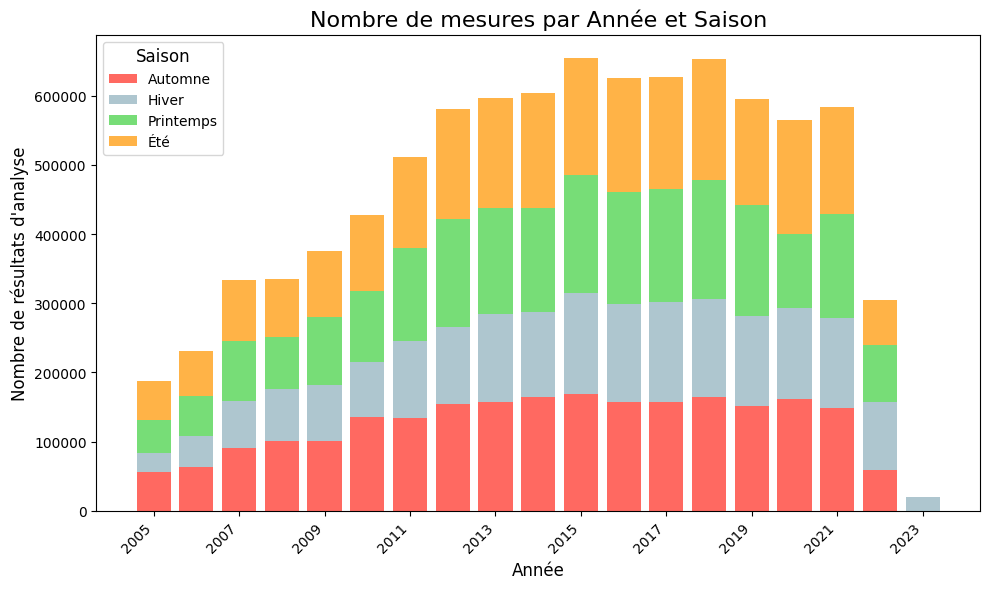

In [52]:
saisons = df_counts['saison'].unique()
annees = df_counts['année'].unique()
data_pivot = df_counts.pivot_table(index='année', columns='saison', values="nombre de résultats d'analyse par saison", fill_value=0)

plt.figure(figsize=(10, 6))

bottom_values = [0] * len(annees)
for saison in saisons:
    plt.bar(data_pivot.index, data_pivot[saison], bottom=bottom_values, label=saison, color=season_colors.get(saison, 'gray'))
    bottom_values = bottom_values + data_pivot[saison]

plt.title('Nombre de mesures par Année et Saison', fontsize=16)
plt.xlabel('Année', fontsize=12)
plt.ylabel("Nombre de résultats d'analyse", fontsize=12)
ticks = data_pivot.index[::2]
plt.xticks(ticks, rotation=45, ha='right')
plt.legend(title='Saison', fontsize=10, title_fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Nous avons plus de 300 000 résultats par an à partir de 2007 jusqu'en 2021, avec une répartition relativement équilibrée entre les saisons. Pour les années 2005, 2006 et 2022, le nombre de résultats est plus faible, autour de 200 000 résultats par an.

(NB : il y a quelques données pour hiver 2023, correspondant à des données en décembre 2022, étiquetées en saison Hiver et année 2023 après notre aggrégation.)

Pour simplifier l'analyse tout en conservant les tendances, nous avons choisi d'agréger les données par station, année et saison.

Pour chaque combinaison de station, année, saison, et paramètre (paramètre - support), nous calculons des statistiques représentatives : médiane et moyenne.

Nous créons un nouveau DataFrame composé des valeurs agrégées. Chaque ligne représentera une station, une année, une saison, et contiendra les valeurs médianes et moyennes pour chaque paramètre mesuré dans les colonnes `median_RsAna` et `mean_RsAna`.

Cela permet de réduire la complexité des données tout en conservant leur représentativité.

#### Aggrégation par station, année et saison

In [53]:
df_pc_season.rename(columns={'CdStationMesureEauxSurface': 'station', 'DatePrel': 'date'}, inplace=True)

In [54]:
agg_functions = { 'RsAna': ['mean', 'median'], }
df_aggregated = df_pc_season.groupby(['station', 'param', 'saison', 'année']).agg(agg_functions).reset_index()
df_aggregated.columns = ['station', 'param', 'saison', 'année', 'mean_RsAna', 'median_RsAna']
print(f"Taille du DataFrame après l'agrégation avec différentes fonctions : {df_aggregated.shape[0]}")

Taille du DataFrame après l'agrégation avec différentes fonctions : 20086800


In [55]:
df_aggregated.isnull().sum()

station                0
param                  0
saison                 0
année                  0
mean_RsAna      15972975
median_RsAna    15972975
dtype: int64

Après l’agrégation, le nombre total de valeurs a augmenté de manière significative (environ 14 millions de lignes). Cela suggère qu’il y a de nombreuses valeurs nulles, et nous allons les supprimer.

In [56]:
# supprimer toutes les lignes avec des valeurs nulles 
df_aggregated.dropna(inplace=True)
df_aggregated.shape

(4113825, 6)

In [57]:
# calculer combien de données en moins ça fait par rapport à avant aggregation
print("Nombre de valeurs en moins par rapport à avant aggrégation :", df_pc_season.shape[0] - df_aggregated.shape[0])
print("Ce qui représente une perte de :", (df_pc_season.shape[0] - df_aggregated.shape[0]) / df_pc_season.shape[0] * 100, "%")

Nombre de valeurs en moins par rapport à avant aggrégation : 4696800
Ce qui représente une perte de : 53.308363481591826 %


Nous avons alors 4 millions de lignes, ce qui est bien plus gérable pour réaliser nos analyses.

#### Création du dataframe aggrégé par saison des données physicochimiques

Nous effectuons une nouvelle transformation du dataframe pour obtenir un résumé agrégé des résultats. L'objectif est de calculer, pour chaque station et chaque saison, les statistiques représentatives des paramètres physicochimiques mesurés.

Nous créons 2 dataframes distincts :
- un contenant les moyennes des résultats d’analyse pour chaque paramètre
- un autre contenant les médianes des résultats d’analyse pour chaque paramètre

Ce pivotement permet de structurer les données de manière claire et synthétique, facilitant ainsi les analyses ultérieures.

In [58]:
params = df_aggregated['param'].unique()

In [59]:
df_pc_agg_saison_median = df_aggregated[['station', 'année', 'saison', 'param', 'median_RsAna']]
df_pc_agg_saison_mean = df_aggregated[['station', 'année', 'saison', 'param', 'mean_RsAna']]
# Pivot des données : station, année, saison en index, param en colonnes
df_pc_pivot_saison_median = df_aggregated.pivot_table(index=['station', 'année', 'saison'], 
                                       columns='param', 
                                       values='median_RsAna', 
                                       aggfunc='median')
df_pc_pivot_saison_mean = df_aggregated.pivot_table(index=['station', 'année', 'saison'],
                                                    columns='param',
                                                    values='mean_RsAna',
                                                    aggfunc='mean')
df_pc_pivot_saison_median.reset_index(inplace=True)
df_pc_pivot_saison_mean.reset_index(inplace=True)

#### Analyse des données aggrégées avec la médiane

In [60]:
df_pc_pivot_saison_median.head(5)

param   station  année     saison  Ammonium - Air  Ammonium - Eau  \
0      05001800   2005    Automne             NaN             NaN   
1      05001800   2005      Hiver             NaN             NaN   
2      05001800   2005  Printemps             NaN             NaN   
3      05001800   2005        Été             NaN             NaN   
4      05001800   2007    Automne             NaN           0.025   

param  Azote Kjeldahl - Air  Azote Kjeldahl - Eau  Carbone Organique - Eau  \
0                       NaN                   NaN                      NaN   
1                       NaN                   NaN                      NaN   
2                       NaN                   NaN                      NaN   
3                       NaN                   NaN                      NaN   
4                       NaN                   1.0                     2.75   

param  Conductivité à 25°C - Air  Conductivité à 25°C - Eau  ...  \
0                            NaN                      603.0  ...   
1                            NaN                      825.0  ...   
2                            NaN                      779.0  ...   
3                            NaN                      630.0  ...   
4                            NaN                      770.0  ...   

param  Oxygène dissous - Eau  Phosphore total - Air  Phosphore total - Eau  \
0                       7.50                    NaN                   0.05   
1                      11.95                    NaN                   0.05   
2                      10.10                    NaN                   0.05   
3                       7.90                    NaN                   0.05   
4                       9.10                    NaN                   0.05   

param  Potentiel en Hydrogène (pH) - Air  Potentiel en Hydrogène (pH) - Eau  \
0                                    NaN                                7.5   
1                                    NaN                                7.9   
2                                    NaN                                8.0   
3                                    NaN                                7.7   
4                                    NaN                                8.0   

param  Taux de saturation en oxygène - Air  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

param  Taux de saturation en oxygène - Eau  Température de l'Eau - Air  \
0                                     82.0                         NaN   
1                                    103.5                         NaN   
2                                    104.0                         NaN   
3                                     88.0                         NaN   
4                                     94.0                         NaN   

param  Température de l'Eau - Eau  Turbidité Formazine Néphélométrique - Eau  
0                           19.60                                        NaN  
1                            8.95                                        NaN  
2                           16.90                                        NaN  
3                           23.10                                        NaN  
4                           14.40                                        NaN  

[5 rows x 33 columns]

In [61]:
print(f"Taille du DataFrame pivoté : {df_pc_pivot_saison_median.shape[0]}")

Taille du DataFrame pivoté : 292196


##### Gestion des valeurs nulles

In [62]:
# afficher les valeurs nulles
df_pc_pivot_saison_median.isnull().sum()

param
station                                                           0
année                                                             0
saison                                                            0
Ammonium - Air                                               290188
Ammonium - Eau                                                44641
Azote Kjeldahl - Air                                         290809
Azote Kjeldahl - Eau                                          42131
Carbone Organique - Eau                                       36462
Conductivité à 25°C - Air                                    289987
Conductivité à 25°C - Eau                                      6910
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Air    290115
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau     30477
Diuron - Air                                                 291423
Diuron - Eau                                                 157613
Matières en suspension - Air              

In [63]:
# pourcentage de valeurs nulles pour chaque paramètre
null_percentages = df_pc_pivot_saison_median.isnull().mean() * 100
null_percentages

param
station                                                       0.000000
année                                                         0.000000
saison                                                        0.000000
Ammonium - Air                                               99.312790
Ammonium - Eau                                               15.277759
Azote Kjeldahl - Air                                         99.525319
Azote Kjeldahl - Eau                                         14.418746
Carbone Organique - Eau                                      12.478610
Conductivité à 25°C - Air                                    99.244001
Conductivité à 25°C - Eau                                     2.364851
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Air    99.287807
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    10.430328
Diuron - Air                                                 99.735452
Diuron - Eau                                                 53.940848


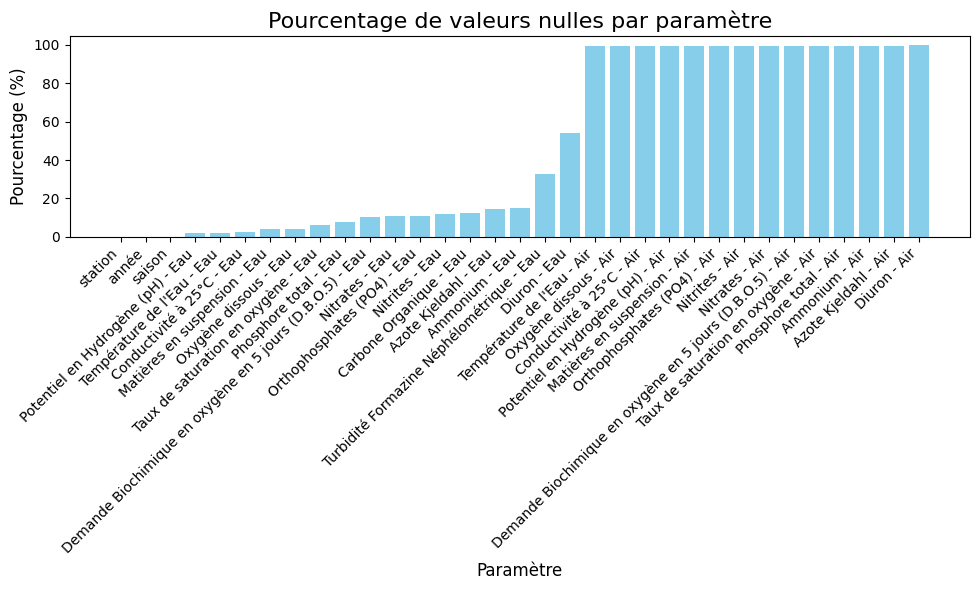

In [64]:
# Représentation des pourcentages de valeurs nulles par paramètre
null_percentages = df_pc_pivot_saison_median.isnull().mean() * 100
null_percentages_df = null_percentages.reset_index()
null_percentages_df.columns = ['Paramètre', 'Pourcentage de valeurs nulles']
null_percentages_df = null_percentages_df.sort_values(by='Pourcentage de valeurs nulles')

plt.figure(figsize=(10, 6))
bars = plt.bar(null_percentages_df['Paramètre'], null_percentages_df['Pourcentage de valeurs nulles'], color='skyblue')

plt.title('Pourcentage de valeurs nulles par paramètre', fontsize=16)
plt.xlabel('Paramètre', fontsize=12)
plt.ylabel('Pourcentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [65]:
# liste des paramètres avec plus de 90% de valeurs nulles
params_with_most_nulls = null_percentages[null_percentages > 90].index.tolist()
params_with_most_nulls

['Ammonium - Air',
 'Azote Kjeldahl - Air',
 'Conductivité à 25°C - Air',
 'Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Air',
 'Diuron - Air',
 'Matières en suspension - Air',
 'Nitrates - Air',
 'Nitrites - Air',
 'Orthophosphates (PO4) - Air',
 'Oxygène dissous - Air',
 'Phosphore total - Air',
 'Potentiel en Hydrogène (pH) - Air',
 'Taux de saturation en oxygène - Air',
 "Température de l'Eau - Air"]

Nous avons décidé de supprimer les colonnes contenant plus de 90% de valeurs nulles, car un pourcentage aussi élevé de valeurs manquantes indique que ces paramètres sont rarement mesurés pour une station donnée à une saison donnée. 

In [66]:
# supprimer les colonnes avec plus de 90% de valeurs nulles
df_pc_pivot_saison_median.drop(columns=params_with_most_nulls, inplace=True)

In [67]:
# Affichage du nombre de lignes où il n'y a que la saison et l'année qui ne sont pas nuls
# Et donc où toutes les valeurs des paramètres sont nuls
exclude_columns = ['station', 'année', 'saison']
columns_to_check = [col for col in df_pc_pivot_saison_median.columns if col not in exclude_columns]
rows_with_all_nulls = df_pc_pivot_saison_median[df_pc_pivot_saison_median[columns_to_check].isnull().all(axis=1)]
rows_with_all_nulls.head(3)

param   station  année   saison  Ammonium - Eau  Azote Kjeldahl - Eau  \
35512  03017000   2005  Automne             NaN                   NaN   
35513  03017000   2005    Hiver             NaN                   NaN   
35656  03024392   2005    Hiver             NaN                   NaN   

param  Carbone Organique - Eau  Conductivité à 25°C - Eau  \
35512                      NaN                        NaN   
35513                      NaN                        NaN   
35656                      NaN                        NaN   

param  Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau  \
35512                                                NaN           
35513                                                NaN           
35656                                                NaN           

param  Diuron - Eau  Matières en suspension - Eau  Nitrates - Eau  \
35512           NaN                           NaN             NaN   
35513           NaN                           NaN             NaN   
35656           NaN                           NaN             NaN   

param  Nitrites - Eau  Orthophosphates (PO4) - Eau  Oxygène dissous - Eau  \
35512             NaN                          NaN                    NaN   
35513             NaN                          NaN                    NaN   
35656             NaN                          NaN                    NaN   

param  Phosphore total - Eau  Potentiel en Hydrogène (pH) - Eau  \
35512                    NaN                                NaN   
35513                    NaN                                NaN   
35656                    NaN                                NaN   

param  Taux de saturation en oxygène - Eau  Température de l'Eau - Eau  \
35512                                  NaN                         NaN   
35513                                  NaN                         NaN   
35656                                  NaN                         NaN   

param  Turbidité Formazine Néphélométrique - Eau  
35512                                        NaN  
35513                                        NaN  
35656                                        NaN

In [68]:
rows_with_all_nulls.shape

(517, 19)

Il y a environ 500 lignes ne contenant aucune information, nous les supprimons.

In [69]:
# supprimer les lignes où il n'y a que param saison et année qui ne sont pas nuls 
print("Nombre de lignes avant suppression :", df_pc_pivot_saison_median.shape[0])
df_pc_pivot_saison_median = df_pc_pivot_saison_median[~df_pc_pivot_saison_median[columns_to_check].isnull().all(axis=1)]
print("Nombre de lignes après suppression :", df_pc_pivot_saison_median.shape[0])

Nombre de lignes avant suppression : 292196
Nombre de lignes après suppression : 291679


#### Analyse des données aggrégées avec la moyenne

In [70]:
df_pc_pivot_saison_mean.head(5)

param   station  année     saison  Ammonium - Air  Ammonium - Eau  \
0      05001800   2005    Automne             NaN             NaN   
1      05001800   2005      Hiver             NaN             NaN   
2      05001800   2005  Printemps             NaN             NaN   
3      05001800   2005        Été             NaN             NaN   
4      05001800   2007    Automne             NaN           0.025   

param  Azote Kjeldahl - Air  Azote Kjeldahl - Eau  Carbone Organique - Eau  \
0                       NaN                   NaN                      NaN   
1                       NaN                   NaN                      NaN   
2                       NaN                   NaN                      NaN   
3                       NaN                   NaN                      NaN   
4                       NaN                   1.0                     2.75   

param  Conductivité à 25°C - Air  Conductivité à 25°C - Eau  ...  \
0                            NaN                 603.000000  ...   
1                            NaN                 825.000000  ...   
2                            NaN                 768.333333  ...   
3                            NaN                 628.666667  ...   
4                            NaN                 776.666667  ...   

param  Oxygène dissous - Eau  Phosphore total - Air  Phosphore total - Eau  \
0                   7.500000                    NaN                   0.05   
1                  11.950000                    NaN                   0.05   
2                  10.766667                    NaN                   0.05   
3                   7.733333                    NaN                   0.05   
4                   9.633333                    NaN                   0.05   

param  Potentiel en Hydrogène (pH) - Air  Potentiel en Hydrogène (pH) - Eau  \
0                                    NaN                           7.500000   
1                                    NaN                           7.900000   
2                                    NaN                           7.966667   
3                                    NaN                           7.700000   
4                                    NaN                           8.000000   

param  Taux de saturation en oxygène - Air  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

param  Taux de saturation en oxygène - Eau  Température de l'Eau - Air  \
0                                82.000000                         NaN   
1                               103.500000                         NaN   
2                               104.666667                         NaN   
3                                89.000000                         NaN   
4                                92.000000                         NaN   

param  Température de l'Eau - Eau  Turbidité Formazine Néphélométrique - Eau  
0                       19.600000                                        NaN  
1                        8.950000                                        NaN  
2                       14.800000                                        NaN  
3                       22.500000                                        NaN  
4                       11.766667                                        NaN  

[5 rows x 33 columns]

Nous pouvons faire le même constat que pour les données aggrégées par médiane, et nous procédons donc au même nettoyage pour les données aggrégées par moyenne.

In [71]:
# supprimer les colonnes avec plus de 90% de valeurs nulles
df_pc_pivot_saison_mean.drop(columns=params_with_most_nulls, inplace=True)

In [72]:
# supprimer les lignes où il n'y a que param saison et année qui ne sont pas nuls 
print("Nombre de lignes avant suppression :", df_pc_pivot_saison_mean.shape[0])
df_pc_pivot_saison_mean = df_pc_pivot_saison_mean[~df_pc_pivot_saison_mean[columns_to_check].isnull().all(axis=1)]
print("Nombre de lignes après suppression :", df_pc_pivot_saison_mean.shape[0])

Nombre de lignes avant suppression : 292196
Nombre de lignes après suppression : 291679


## Analyse exploratoire des données hydrobiologiques

### Démarche

Dans cette partie, nous allons analyser et traiter les données hydrobiologiques afin de les préparer pour les intégrer correctement avec les données physicochimiques.

Nous avons conservé seulement les informations utiles pour notre analyse, notamment l'indicateur biologique I2M2, les identifiants des stations pour permettre la liaison avec les autres tables, et les dates de prélèvement. 

Ensuite, nous avons structuré les données en les agrégeant par station, saison et année. Nous avons créé deux ensembles de données : l'un avec les médianes des paramètres pour chaque station sur une saison et une année données, et l'autre avec les moyennes. Cette agrégation a permis de réduire la taille globale des données, tout en diminuant la variabilité et en équilibrant le nombre d'enregistrements entre les périodes.

Et enfin, pour tenir compte du délai entre les changements physicochimiques et leur impact sur les indices biologiques, nous avons introduit des décalages temporels (lags) de 1 mois, 3 mois, 6 mois. Pour chaque décalage, nous avons généré de nouveaux datasets.

### Nettoyage des données

In [73]:
df_hydrobio.head(3)

Unnamed: 0  CdStationMesureEauxSurface LbStationMesureEauxSurface  \
0           0                     2000990   LE LERTZBACH À HEGENHEIM   
1           1                     2001000    L'AUGRABEN À BARTENHEIM   
2           2                     2001000    L'AUGRABEN À BARTENHEIM   

   CdPointEauxSurf DateDebutOperationPrelBio  CdSupport  \
0              1.0                2010-07-20         13   
1              2.0                2010-09-20         13   
2              2.0                2011-08-03         13   

                     LbSupport DtProdResultatBiologique  \
0  Macroinvertébrés aquatiques                      NaN   
1  Macroinvertébrés aquatiques                      NaN   
2  Macroinvertébrés aquatiques                      NaN   

   CdParametreResultatBiologique                          LbLongParametre  \
0                           7613  Indice Invertébrés Multimétrique (I2M2)   
1                           7613  Indice Invertébrés Multimétrique (I2M2)   
2                           7613  Indice Invertébrés Multimétrique (I2M2)   

   ...  CdUniteMesure SymUniteMesure CdRqIndiceResultatBiologique  \
0  ...              X              X                            1   
1  ...              X              X                            1   
2  ...              X              X                            1   

                                          MnemoRqAna CdMethEval  \
0  Résultat > seuil de quantification et < au seu...        NaN   
1  Résultat > seuil de quantification et < au seu...        NaN   
2  Résultat > seuil de quantification et < au seu...        NaN   

  RefOperationPrelBio    CdProducteur               NomProducteur  \
0             1814647  18570301400018  AGENCE DE L'EAU RHIN MEUSE   
1             1814648  18570301400018  AGENCE DE L'EAU RHIN MEUSE   
2             2148304  18570301400018  AGENCE DE L'EAU RHIN MEUSE   

  CdAccredRsIndiceResultatBiologique  MnAccredRsIndiceResultatBiologique  
0                                0.0                             Inconnu  
1                                0.0                             Inconnu  
2                                0.0                             Inconnu  

[3 rows x 21 columns]

In [74]:
df_hydrobio.shape

(43535, 21)

Nous pouvons déjà voir qu'il y a beaucoup moins de données hydrobiologiques par rapport aux données physicochimiques (8917443 lignes dans le dataset physicochimiques).

In [75]:
# Valeurs manquantes
df_hydrobio.isnull().sum()

Unnamed: 0                                0
CdStationMesureEauxSurface                0
LbStationMesureEauxSurface                0
CdPointEauxSurf                         420
DateDebutOperationPrelBio                 0
CdSupport                                 0
LbSupport                                 0
DtProdResultatBiologique              28706
CdParametreResultatBiologique             0
LbLongParametre                           0
ResIndiceResultatBiologique              13
CdUniteMesure                             0
SymUniteMesure                            0
CdRqIndiceResultatBiologique              0
MnemoRqAna                                0
CdMethEval                            15162
RefOperationPrelBio                       0
CdProducteur                              0
NomProducteur                             4
CdAccredRsIndiceResultatBiologique      192
MnAccredRsIndiceResultatBiologique      192
dtype: int64

In [76]:
# Nombre de valeurs uniques pour chaque colonne
df_hydrobio.nunique()

Unnamed: 0                            43535
CdStationMesureEauxSurface             9489
LbStationMesureEauxSurface             9389
CdPointEauxSurf                          26
DateDebutOperationPrelBio              2366
CdSupport                                 1
LbSupport                                 1
DtProdResultatBiologique                 54
CdParametreResultatBiologique             1
LbLongParametre                           1
ResIndiceResultatBiologique            9111
CdUniteMesure                             3
SymUniteMesure                            3
CdRqIndiceResultatBiologique              2
MnemoRqAna                                2
CdMethEval                                7
RefOperationPrelBio                   43535
CdProducteur                            262
NomProducteur                           248
CdAccredRsIndiceResultatBiologique        3
MnAccredRsIndiceResultatBiologique        3
dtype: int64

In [77]:
# Recherche des correspondances multiples entre deux colonnes
def afficher_correspondances_multiples(df, col_code, col_libelle):
    multiples = df.groupby(col_code)[col_libelle].nunique()
    codes_avec_multiples_libelles = multiples[multiples > 1].index

    if len(codes_avec_multiples_libelles) > 0:
        print(f"Codes dans '{col_code}' avec plusieurs valeurs dans '{col_libelle}' :")
        print(df[df[col_code].isin(codes_avec_multiples_libelles)][[col_code, col_libelle]].drop_duplicates())
    else:
        print(f"Aucune correspondance multiple trouvée entre '{col_code}' et '{col_libelle}'.")

In [78]:
# Vérification des unités de mesure
print("Valeurs uniques CdUniteMesure : ", df_hydrobio['CdUniteMesure'].unique())
print("Valeurs uniques SymUniteMesure : ", df_hydrobio['SymUniteMesure'].unique())
afficher_correspondances_multiples(df_hydrobio, 'CdUniteMesure', 'SymUniteMesure') 

Valeurs uniques CdUniteMesure :  ['X' '214' '0']
Valeurs uniques SymUniteMesure :  ['X' 'n' 'Unité inconnue']
Aucune correspondance multiple trouvée entre 'CdUniteMesure' et 'SymUniteMesure'.


In [79]:
afficher_correspondances_multiples(df_hydrobio, 'CdStationMesureEauxSurface', 'LbStationMesureEauxSurface')

Codes dans 'CdStationMesureEauxSurface' avec plusieurs valeurs dans 'LbStationMesureEauxSurface' :
       CdStationMesureEauxSurface    LbStationMesureEauxSurface
2588                      6073500   LEYSSE A LE-BOURGET-DU-LAC 
2986                      6135500                ARLY A FLUMET 
4066                      6580830       DEISSE A GRESY-SUR-AIX 
42528                     6073500  LEYSSE A LE-BOURGET-DU-LAC 1
42750                     6135500               ARLY A FLUMET 1
43397                     6580830      DEISSE A GRESY-SUR-AIX 1


In [80]:
# Renommage des stations ayant le même CdStationMesureEauxSurface et des libellés un peu différents
codes_a_corriger = [6073500, 6135500, 6580830]
df_hydrobio.loc[df_hydrobio['CdStationMesureEauxSurface'].isin(codes_a_corriger), 'LbStationMesureEauxSurface'] = \
    df_hydrobio.loc[df_hydrobio['CdStationMesureEauxSurface'].isin(codes_a_corriger), 'LbStationMesureEauxSurface'].str.rstrip(' 1')

In [81]:
# Vérification
afficher_correspondances_multiples(df_hydrobio, 'CdStationMesureEauxSurface', 'LbStationMesureEauxSurface')

Aucune correspondance multiple trouvée entre 'CdStationMesureEauxSurface' et 'LbStationMesureEauxSurface'.


Une grande partie des colonnes de ce jeu de données ne sont pas pertinentes pour l'analyse et nous les supprimerons par la suite.  
Voici les colonnes identifiées comme inutiles :

- `Unnamed: 0` : Colonne d'index sans valeur analytique.
- `DtProdResultatBiologique` : Date (jour, mois, année) de calcul du résultat biologique, non utile pour notre analyse et contenant des valeurs manquantes dans 1/4 des cas.
- `CdSupport`, `LbSupport`, `CdParametreResultatBiologique`, `LbLongParametre` : Colonnes avec une seule valeur possible et aucune donnée manquante, donc non informatives.
- `RefOperationPrelBio` : Sert uniquement à des jointures avec des tables externes que nous n'utilisons pas.
- `CdAccredRsIndiceResultatBiologique`, `CdProducteur`, `NomProducteur`, `MnAccredRsIndiceResultatBiologique` : Métadonnées administratives sans utilité pour notre analyse.
- `CdUniteMesure`, `SymUniteMesure` : Colonnes contenant trois valeurs possibles, mais toutes indiquant l'absence d'unité, donc sans intérêt analytique.

In [82]:
df_hydrobio.rename(columns={'CdStationMesureEauxSurface': 'station', 'DateDebutOperationPrelBio': 'date', 'ResIndiceResultatBiologique': 'I2M2'}, inplace=True)

In [83]:
df_hydrobio['date'] = pd.to_datetime(df_hydrobio['date'], format='%Y-%m-%d')
df_hydrobio['date'].dtype

dtype('<M8[ns]')

In [84]:
# supprimer les I2M2 manquants et les doublons
print("avant suppression :", df_hydrobio.shape)
df_hydrobio.dropna(subset=['I2M2'], inplace=True)
df_hydrobio.drop_duplicates(inplace=True)
print("après suppression :", df_hydrobio.shape)

avant suppression : (43535, 21)
après suppression : (43522, 21)


In [85]:
# Gestion des seuils
df_hydrobio['MnemoRqAna'].value_counts()

MnemoRqAna
Résultat > seuil de quantification et < au seuil de saturation    43522
Name: count, dtype: int64

Le seuil est respecté pour l'ensemble des données.

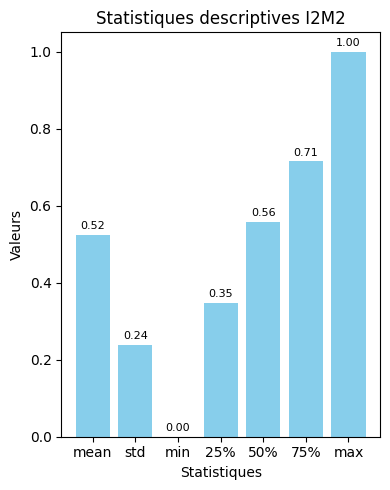

In [86]:
desc_stats = df_hydrobio['I2M2'].describe()
desc_stats = desc_stats.drop(['count'])

plt.figure(figsize=(4, 5))
bars = plt.bar(desc_stats.index, desc_stats.values, color='skyblue')

for bar, value in zip(bars, desc_stats.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.title('Statistiques descriptives I2M2', fontsize=12)
plt.xlabel('Statistiques', fontsize=10)
plt.ylabel('Valeurs', fontsize=10)
plt.tight_layout()
plt.show()

Le paramètre I2M2 ne comporte pas d'outliers, toutes les valeurs sont comprises entre 0 et 1.

### Aggrégation par saison (regroupement par saison et année)

In [87]:
df_hydrobio_saison = df_hydrobio.copy()
df_hydrobio_saison['année'] = df_hydrobio_saison['date'].dt.year + (df_hydrobio_saison['date'].dt.month == 12)
df_hydrobio_saison['saison'] = df_hydrobio_saison['date'].dt.month.map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Été', 7: 'Été', 8: 'Été',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})
df_hydrobio_saison = df_hydrobio_saison[['station', 'année', 'saison', 'I2M2']]
df_hydrobio_saison

station  année   saison    I2M2
0      2000990   2010      Été  0.4726
1      2001000   2010  Automne  0.3481
2      2001000   2011      Été  0.4253
3      2001000   2012      Été  0.2460
4      2001025   2010      Été  0.1137
...        ...    ...      ...     ...
43530  6999107   2009      Été  0.1820
43531  6999125   2008      Été  0.1180
43532  6999125   2009      Été  0.1580
43533  6999180   2008      Été  0.3530
43534  6999180   2009      Été  0.4150

[43522 rows x 4 columns]

In [88]:
df_counts = df_hydrobio_saison.groupby(['année', 'saison']).size().reset_index(name='nombre de résultats d\'analyse par saison')

#### Observation des données

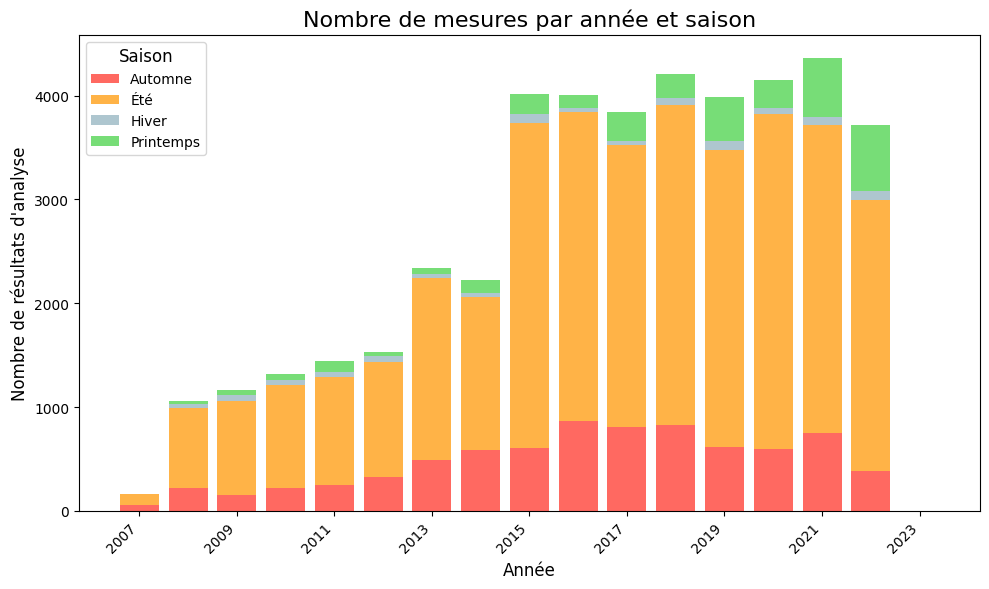

In [89]:
saisons = df_counts['saison'].unique()
annees = df_counts['année'].unique()
data_pivot = df_counts.pivot_table(index='année', columns='saison', values="nombre de résultats d'analyse par saison", fill_value=0)

plt.figure(figsize=(10, 6))

bottom_values = [0] * len(annees)
for saison in saisons:
    plt.bar(data_pivot.index, data_pivot[saison], bottom=bottom_values, label=saison, color=season_colors.get(saison, 'gray'))
    bottom_values = bottom_values + data_pivot[saison]

plt.title('Nombre de mesures par année et saison', fontsize=16)
plt.xlabel('Année', fontsize=12)
plt.ylabel("Nombre de résultats d'analyse", fontsize=12)
ticks = data_pivot.index[::2]
plt.xticks(ticks, rotation=45, ha='right')
plt.legend(title='Saison', fontsize=10, title_fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Nous pouvons voir que la répartition des prélévements est très différente de celle des données physicochimiques qui étaient uniformément réparties sur toutes les saisons.  
Ici, nous constatons une forte dominance des prélèvements réalisés en été. Les autres saisons sont beaucoup moins représentées, avec très peu de résultats enregistrés en hiver, un nombre légèrement supérieur au printemps, et encore légèrement supérieur en automne.

Avant 2008, le nombre de prélèvements était inférieur à 1 000 par an. Jusqu'en 2014, ce nombre a progressivement augmenté à moins de 2 000 par an, pour finalement doubler après 2014.

In [90]:
# Seuils de l'I2M2
seuils_I2M2 = {
    "Très bon": 0.665,
    "Bon": 0.443,
    "Moyen": 0.295,
    "Médiocre": 0.148,
    "Mauvais": 0.0
}
# trouvés ici : https://www.labocea.fr/indice-invertebres-multi-metriques-i2m2/?cn-reloaded=1

Les seuils utilisés ici proviennent de : https://www.labocea.fr/indice-invertebres-multi-metriques-i2m2/?cn-reloaded=1. Cette référence propose des seuils simplifiés pour évaluer les classes d'état de l'indice I2M2.

Nous n'avons pas utilisé les seuils présentés à la page 62 de l'article officiel disponible ici : https://www.legifrance.gouv.fr/download/pdf?id=CzMk9C9TuiNiDv8adNATcVIsrsa00QFujiQScSI_fAU=, car ces seuils dépendent de paramètres spécifiques, notamment le "rang" des données. Ce rang, qui correspond à des régions ou bassins hydrographiques précis, n'est pas identifiable dans les données que nous possédons. De plus, notre analyse n'a pas pour objectif de classifier les états de l'indice I2M2, mais de modéliser ses valeurs continues via une approche en régression.

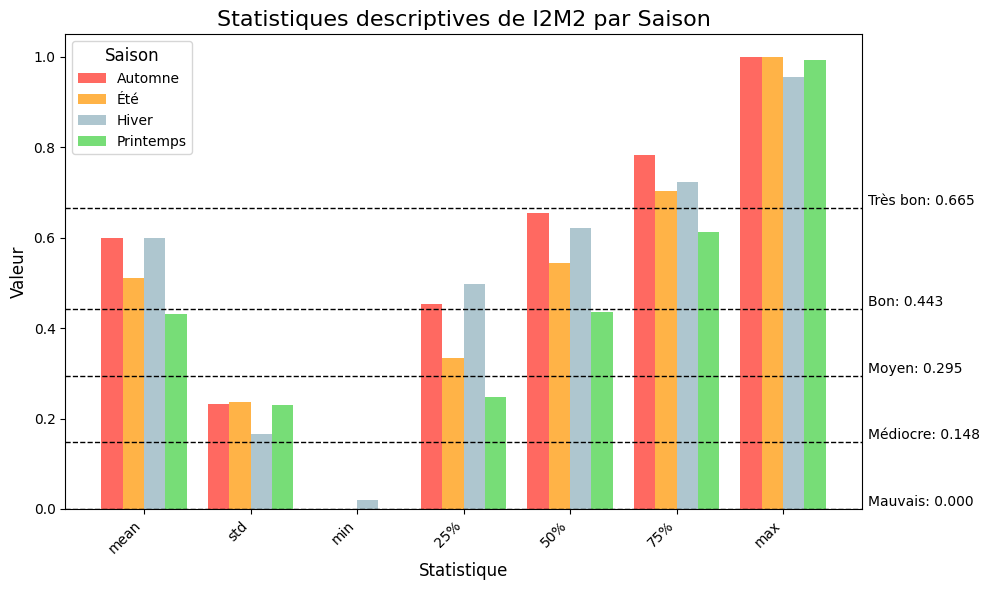

In [91]:
desc_stats_saison = df_hydrobio_saison.groupby('saison')['I2M2'].describe()
desc_stats_saison = desc_stats_saison.drop(columns=['count']).transpose()

plt.figure(figsize=(10, 6))

x_indices = np.arange(len(desc_stats_saison.index))
bar_width = 0.2
for i, saison in enumerate(saisons):
    plt.bar(x_indices + i * bar_width, desc_stats_saison[saison], width=bar_width, label=saison, color=season_colors.get(saison, 'gray'))

for etat, valeur in seuils_I2M2.items():
    plt.axhline(y=valeur,  color='black',  linestyle='--',  linewidth=1)

for etat, valeur in seuils_I2M2.items():
    plt.text(len(desc_stats_saison.index) + 0.1,  valeur,  f"{etat}: {valeur:.3f}",  fontsize=10,  color="black", verticalalignment='bottom', horizontalalignment='left')

plt.title("Statistiques descriptives de I2M2 par Saison", fontsize=16)
plt.xlabel("Statistique", fontsize=12)
plt.ylabel("Valeur", fontsize=12)
plt.xticks(x_indices + (len(saisons) - 1) * bar_width / 2, desc_stats_saison.index, rotation=45, ha='right')
plt.legend(title="Saison", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()


Nous pouvons voir que les saisons influencent clairement l'indice biologique I2M2, avec une qualité biologique généralement plus favorable en été et en automne.  
Ce résultat pourrait être lié à des variations naturelles des conditions environnementales, des paramètres physicochimiques, ou à des variations des activités humaines impactant la qualité de l'eau.

### Ajout d'un décalage temporelle

Pour notre analyse, nous avons introduit un décalage temporel initial arbitraire de 1 mois entre les données physicochimiques et hydrobiologiques. 

Ce choix repose sur l'hypothèse que les variations des paramètres physicochimiques influencent l'indice I2M2, mais que cet impact n'est pas immédiat. En effet, les changements physicochimiques, comme une hausse de la température ou une variation des nutriments, nécessitent un certain temps pour se refléter dans la composition biologique de l'eau.

Nous prévoyons également de tester des décalages supplémentaires de 3 mois, 6 mois afin d'explorer l'effet différé des variations physicochimiques sur la qualité biologique, et d'identifier le délai optimal reflétant le mieux ces interactions. 

Puisque les données physicochimiques sont censées avoir un impact sur les données biologiques, 
on simule un "retour dans le temps" pour les données hydrobiologiques 
c'est à dire que si on fait un relevé en décembre des données hydrobiologiques, 
on veut l'associer aux données de novembre des données physcochimiques
si le lag est de 1 mois.

In [92]:
df_hydrobio['date_lag_1_month'] = df_hydrobio['date'] - pd.Timedelta(days=30)
df_hydrobio['date_lag_3_month'] = df_hydrobio['date'] - pd.Timedelta(days=90)
df_hydrobio['date_lag_6_month'] = df_hydrobio['date'] - pd.Timedelta(days=180)

In [93]:
df_hydrobio_lag_1_month = df_hydrobio.copy()
df_hydrobio_lag_3_month = df_hydrobio.copy()
df_hydrobio_lag_6_month = df_hydrobio.copy()

df_hydrobio_lag_1_month['année'] = df_hydrobio_lag_1_month['date_lag_1_month'].dt.year + (df_hydrobio_lag_1_month['date_lag_1_month'].dt.month == 12)
df_hydrobio_lag_1_month['saison'] = df_hydrobio_lag_1_month['date_lag_1_month'].dt.month.map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Été', 7: 'Été', 8: 'Été',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})

df_hydrobio_lag_3_month['année'] = df_hydrobio_lag_3_month['date_lag_3_month'].dt.year + (df_hydrobio_lag_3_month['date_lag_3_month'].dt.month == 12)
df_hydrobio_lag_3_month['saison'] = df_hydrobio_lag_3_month['date_lag_3_month'].dt.month.map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Été', 7: 'Été', 8: 'Été',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})

df_hydrobio_lag_6_month['année'] = df_hydrobio_lag_6_month['date_lag_6_month'].dt.year + (df_hydrobio_lag_6_month['date_lag_6_month'].dt.month == 12)
df_hydrobio_lag_6_month['saison'] = df_hydrobio_lag_6_month['date_lag_6_month'].dt.month.map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Été', 7: 'Été', 8: 'Été',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})

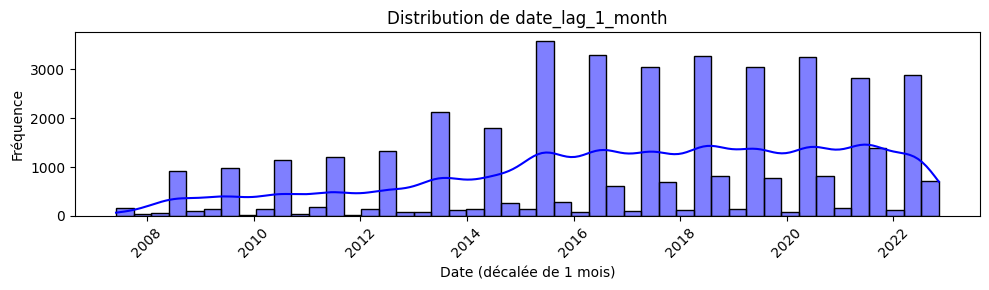

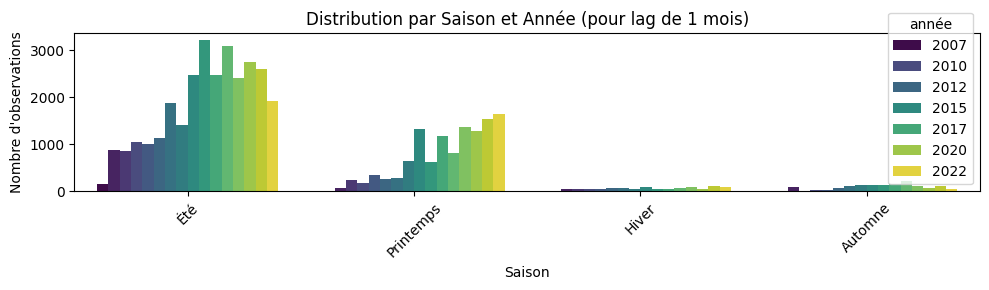

In [94]:
# Distribution de df_hydrobio['date_lag_1_month']
plt.figure(figsize=(10, 3))
sns.histplot(df_hydrobio['date_lag_1_month'], kde=True, color='blue')
plt.title('Distribution de date_lag_1_month')
plt.xlabel('Date (décalée de 1 mois)')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Distribution par saison et année
plt.figure(figsize=(10, 3))
sns.countplot(x='saison', hue='année', data=df_hydrobio_lag_1_month, palette='viridis')
plt.title('Distribution par Saison et Année (pour lag de 1 mois)')
plt.xlabel('Saison')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


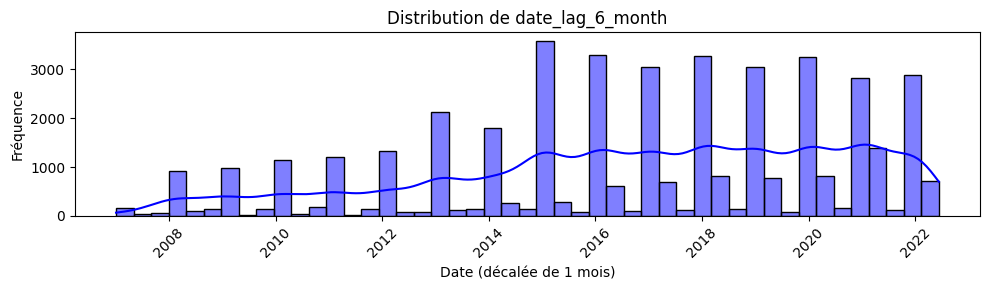

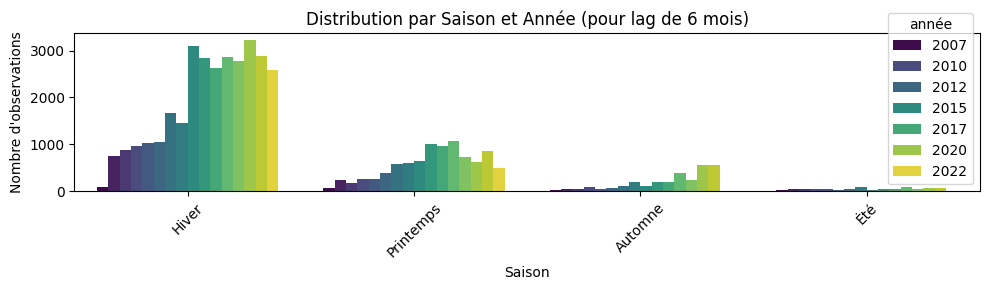

In [95]:
# Distribution de df_hydrobio['date_lag_6_month']
plt.figure(figsize=(10, 3))
sns.histplot(df_hydrobio['date_lag_6_month'], kde=True, color='blue')
plt.title('Distribution de date_lag_6_month')
plt.xlabel('Date (décalée de 1 mois)')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Distribution par saison et année
plt.figure(figsize=(10, 3))
sns.countplot(x='saison', hue='année', data=df_hydrobio_lag_6_month, palette='viridis')
plt.title('Distribution par Saison et Année (pour lag de 6 mois)')
plt.xlabel('Saison')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Les lags ont bien l'air effectifs.

In [96]:
df_hydrobio_lag_1_month_median = df_hydrobio_lag_1_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'median'}).reset_index()
df_hydrobio_lag_3_month_median = df_hydrobio_lag_3_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'median'}).reset_index()
df_hydrobio_lag_6_month_median = df_hydrobio_lag_6_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'median'}).reset_index()
df_hydrobio_lag_1_month_mean = df_hydrobio_lag_1_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'mean'}).reset_index()
df_hydrobio_lag_3_month_mean = df_hydrobio_lag_3_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'mean'}).reset_index()
df_hydrobio_lag_6_month_mean = df_hydrobio_lag_6_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'mean'}).reset_index()

In [97]:
df_hydrobio_lag_1_month_median.head(5)

station  année     saison   I2M2
0  1000274   2016        Été  0.243
1  1000274   2017  Printemps  0.231
2  1000274   2018        Été  0.205
3  1000274   2019  Printemps  0.236
4  1000274   2020        Été  0.096

## Intégration des données : Jointure des tables physicochimiques, hydrobiologiques, stations

### Démarche

Nous avons joint les différentes tables de données (physicochimiques, hydrobiologiques, stations) pour constituer un dataset complet destiné aux analyses.

La première étape a consisté à nettoyer les colonnes relatives aux stations (`CdStationMesureEauxSurface` et  `LbStationMesureEauxSurface`) dans chaque dataset, en corrigeant les identifiants et en vérifiant la cohérence des libellés. Ce nettoyage a été appliqué à l’ensemble des tables pour garantir leur compatibilité.

Nous avons ensuite utilisé le dataset `df_pc_median_bio_median_1_month`, qui regroupe les données physicochimiques et hydrobiologiques agrégées par médiane, avec un décalage temporel de 1 mois pour les indices hydrobiologiques, comme base pour toutes les étapes suivantes de l'analyse.

Enfin, le dataset nettoyé `df_pc_median_bio_median_1_month` a été joint aux données des hydroécorégions en fonction des coordonnées géographiques des stations, permettant ainsi de localiser les stations dans leurs hydroécorégions respectives.

### Observation et nettoyage des colonnes relatives aux stations

In [98]:
# copie des dataframes pour nettoyer les colonnes station
# on garde juste cd et lb pour les stations
df_stations_join = df_stations.copy()
df_stations_join = df_stations_join[['CdStationMesureEauxSurface', 'LbStationMesureEauxSurface']].copy()
df_pc_join = df_pc.copy()
df_pc_join = df_pc[['CdStationMesureEauxSurface', 'LbStationMesureEauxSurface']].copy()
df_hydrobio_join = df_hydrobio.copy()
df_hydrobio_join = df_hydrobio[['station', 'LbStationMesureEauxSurface']].copy()
df_hydrobio_join.rename(columns={'station': 'CdStationMesureEauxSurface'}, inplace=True)

In [99]:
# afficher un échantillon des station pour chaque dataset
print("Stations dans df_stations")
print(df_stations_join['CdStationMesureEauxSurface'].dtype)
print(df_stations_join['CdStationMesureEauxSurface'].unique())
print()
print("Stations dans df_pc")
print(df_pc_join['CdStationMesureEauxSurface'].dtype)
print(df_pc_join['CdStationMesureEauxSurface'].unique())
print()
print("Stations dans df_hydrobio")
print(df_hydrobio_join['CdStationMesureEauxSurface'].dtype)
print(df_hydrobio_join['CdStationMesureEauxSurface'].unique())

Stations dans df_stations
object
['01000477' '01000602' '01000605' ... 'Y9205023' 'Y9715083' 'Y9905043']

Stations dans df_pc
category
['05005600', '05200115', '05001800', '05004000', '05005000', ..., '06001219', '03137810', '03271785', '03113000', '06148115']
Length: 8809
Categories (8810, object): ['05001800', '05004000', '05005000', '05005350', ..., '06001219', '03271785', '03113000', '06148115']

Stations dans df_hydrobio
int64
[2000990 2001000 2001025 ... 6580040 6710037 6820126]


Ces colonnes doivent être modifiées pour être compatibles.  
Selon la documentation, les codes des stations devraient être des entiers composés de 8 chiffres.  
Nous avons donc décidé de nettoyer les identifiants pour respecter ce format.

In [100]:
def clean_station_column(df, column_name):
    df[column_name] = df[column_name].astype(str).str.extract(r'(\d+)')[0]
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    return df
df_stations_join = clean_station_column(df_stations_join, 'CdStationMesureEauxSurface')
df_pc_join = clean_station_column(df_pc_join, 'CdStationMesureEauxSurface')
df_hydrobio_join = clean_station_column(df_hydrobio_join, 'CdStationMesureEauxSurface')

In [101]:
# on crée un dataframe avec l'identifiant de chaque station, et pour les 3 datasets
# on affiche le libellé associé, de cette manière on peut vérifier si les stations sont les mêmes
merged_data = pd.merge(df_pc_join, df_hydrobio_join, on='CdStationMesureEauxSurface', how='inner',  suffixes=('_pc', '_hydrobio'))
merged_all = pd.merge(merged_data, df_stations_join, on='CdStationMesureEauxSurface', how='inner' )
# caster tous les Lb en object
merged_all['LbStationMesureEauxSurface_pc'] = merged_all['LbStationMesureEauxSurface_pc'].astype(str).str.strip()
merged_all['LbStationMesureEauxSurface'] = merged_all['LbStationMesureEauxSurface'].astype(str).str.strip()
merged_all['LbStationMesureEauxSurface_hydrobio'] = merged_all['LbStationMesureEauxSurface_hydrobio'].astype(str).str.strip()
merged_all.dtypes

CdStationMesureEauxSurface              int64
LbStationMesureEauxSurface_pc          object
LbStationMesureEauxSurface_hydrobio    object
LbStationMesureEauxSurface             object
dtype: object

#### Étude des cas où les libellés sont différents

In [102]:
label_diff_pc_hydrobio = merged_all[merged_all['LbStationMesureEauxSurface_pc'] != merged_all['LbStationMesureEauxSurface_hydrobio']]
label_diff_pc_hydrobio = label_diff_pc_hydrobio.drop_duplicates()
label_diff_pc_hydrobio

CdStationMesureEauxSurface  \
142208                       5197200   
468800                       6083000   
490122                       6800003   
645026                       6208900   
1980639                      6580640   
2024300                      6139405   
2595740                      5068920   
6148279                      6830030   
10095956                     6080995   
13028690                     6014250   
15703808                     6213230   
16150583                     3250952   
26405099                     6009020   

                              LbStationMesureEauxSurface_pc  \
142208                                     Le Majesq à Azur   
468800                                   BOURBRE A CHAVANOZ   
490122         EYGUES A ST-MAURICE/EYGUES - LES CIVARDIERES   
645026                                MOURACHONNE A PEGOMAS   
1980639             BIEF D'ENFER A ST ETIENNE SUR REYSSOUZE   
2024300                                 BUGEON A LA-CHAMBRE   
2595740   La Véronne en aval de Riom-ès-Montagnes (Amont...   
6148279                                  TORRENSON A ST-CYR   
10095956                            AGNY A NIVOLAS-VERMELLE   
13028690                           SANSFOND A SAULON-LA-RUE   
15703808             RUISSEAU LE THOUX A CURIS AU MONT D'OR   
16150583  LE COURS D'EAU NUMÉRO 01 DE LA BÉLINIÈRE A CON...   
26405099                              REAL MARTIN A PIGNANS   

                        LbStationMesureEauxSurface_hydrobio  \
142208                        Le ruisseau de Magescq à Azur   
468800                                 BOURBRE A CHAVANOZ 1   
490122                     EYGUES A ST-MAURICE-SUR-EYGUES 1   
645026                              MOURACHONNE A PEGOMAS 1   
1980639           BIEF D'ENFER A ST ETIENNE SUR REYSSOUZE 1   
2024300                               BUGEON A LA-CHAMBRE 1   
2595740   La VÃ©ronne en aval de Riom-Ã¨s-Montagnes (Amo...   
6148279                                TORRENSON A THORRENC   
10095956                          AGNY A NIVOLAS-VERMELLE 1   
13028690                       CENT FONDS A SAULON-LA-RUE 1   
15703808           RUISSEAU LE THOUX A CURIS AU MONT D'OR 2   
16150583  LE COURS D'EAU NUMÃRO 01 DE LA BÃLINIÃRE A ...   
26405099                            REAL MARTIN A PIGNANS 1   

                                 LbStationMesureEauxSurface  
142208                                     Le Majesq à Azur  
468800                                   BOURBRE A CHAVANOZ  
490122         EYGUES A ST-MAURICE/EYGUES - LES CIVARDIERES  
645026                                MOURACHONNE A PEGOMAS  
1980639             BIEF D'ENFER A ST ETIENNE SUR REYSSOUZE  
2024300                                 BUGEON A LA-CHAMBRE  
2595740   La Véronne en aval de Riom-ès-Montagnes (Amont...  
6148279                                  TORRENSON A ST-CYR  
10095956                            AGNY A NIVOLAS-VERMELLE  
13028690                           SANSFOND A SAULON-LA-RUE  
15703808             RUISSEAU LE THOUX A CURIS AU MONT D'OR  
16150583  LE COURS D'EAU NUMÉRO 01 DE LA BÉLINIÈRE A CON...  
26405099                              REAL MARTIN A PIGNANS

Les labels sont différents mais ont l'air de correspondre à la même chose.

In [103]:
label_diff_pc_station = merged_all[merged_all['LbStationMesureEauxSurface_pc'] != merged_all['LbStationMesureEauxSurface']]
label_diff_pc_station = label_diff_pc_station.loc[:, ['CdStationMesureEauxSurface', 'LbStationMesureEauxSurface_pc', 'LbStationMesureEauxSurface']]
label_diff_pc_station = label_diff_pc_station.drop_duplicates()
label_diff_pc_station

CdStationMesureEauxSurface    LbStationMesureEauxSurface_pc  \
6156                         5010000           Le Pharaon à St-Pardon   
11396                        5015100          Le Charreau à St-Michel   
77052                        5116100              La Séoune à Montjoi   
475147                       6580578           AIGUE NOIRE A DOMESSIN   
505611                       6010000                 OGNON A PESMES 1   
...                              ...                              ...   
24098987                     1000602  COLOGNE À BUIRE COURCELLES (80)   
24105377                     1001131  HELPE MINEURE À GRAND FAYT (59)   
26676374                     4108492    LONG À DISSAY-SOUS-COURCILLON   
26687107                     4406063            LE BONSON A PERIGNEUX   
42300999                     6446330            BLUSSANS A BLUSSANS 1   

                 LbStationMesureEauxSurface  
6156                  Le Pharon à St-Pardon  
11396               Le Charraud à St-Michel  
77052                  La Séoune à Montjoie  
475147    RUISSEAU D'AIGUE NOIRE A DOMESSIN  
505611                       OGNON A PESMES  
...                                     ...  
24098987    COLOGNE à BUIRE COURCELLES (80)  
24105377    HELPE MINEURE à GRAND FAYT (59)  
26676374    R LONG À DISSAY-SOUS-COURCILLON  
26687107                             TURLET  
42300999    RUISSEAU DE BLUSSANS A BLUSSANS  

[71 rows x 3 columns]

In [104]:
label_diff_pc_station.head(20)

CdStationMesureEauxSurface  \
6156                        5010000   
11396                       5015100   
77052                       5116100   
475147                      6580578   
505611                      6010000   
545763                      6143950   
597663                      6135350   
598125                      6070460   
611335                      6144900   
644341                      6078500   
668593                      6106935   
677174                      6580563   
700205                      6055000   
706232                      6202100   
723439                      6065675   
1082462                     5015250   
1629659                     6085500   
1667982                     6047500   
1692218                     6580582   
1719834                     6167000   

                       LbStationMesureEauxSurface_pc  \
6156                          Le Pharaon à St-Pardon   
11396                        Le Charreau à St-Michel   
77052                            La Séoune à Montjoi   
475147                        AIGUE NOIRE A DOMESSIN   
505611                              OGNON A PESMES 1   
545763   ROMANCHE A BOURG D'OISANS - LE PONT ROUGE 2   
597663                             PLANAY A MEGEVE 1   
598125                 NANT AILLON A AILLON-LE-VIEUX   
611335                           ROMANCHE A JARRIE 1   
644341                     TIER A BELMONT-TRAMONET 1   
668593                              DORNE A DORNAS 2   
677174                       BONNARD A SAINT-BERON 1   
700205                         BREVENNE A SAIN-BEL 1   
706232                             GAPEAU A SIGNES 1   
723439                   COPPY A MAXILLY-SUR-LEMAN 1   
1082462                         Le Charreau à Torsac   
1629659                            BIENNE A JEURRE 1   
1667982                      PETITE GROSNE A MACON 1   
1692218                            VIERAN A ANNECY 1   
1719834                              TECH A REYNES 1   

                        LbStationMesureEauxSurface  
6156                         Le Pharon à St-Pardon  
11396                      Le Charraud à St-Michel  
77052                         La Séoune à Montjoie  
475147           RUISSEAU D'AIGUE NOIRE A DOMESSIN  
505611                              OGNON A PESMES  
545763   ROMANCHE A BOURG D'OISANS - LE PONT ROUGE  
597663                             PLANAY A MEGEVE  
598125             NANT D'AILLON A AILLON-LE-VIEUX  
611335                           ROMANCHE A JARRIE  
644341                     TIER A BELMONT-TRAMONET  
668593                              DORNE A DORNAS  
677174              RUISSEAU DE BONNARD A ST-BERON  
700205                         BREVENNE A SAIN-BEL  
706232                             GAPEAU A SIGNES  
723439       RUISSEAU DE COPPY A MAXILLY-SUR-LEMAN  
1082462                       Le Charraud à Torsac  
1629659                            BIENNE A JEURRE  
1667982                      PETITE GROSNE A MACON  
1692218                           VIERAN A MEYTHET  
1719834                              TECH A REYNES

In [105]:
# afficher les données de 20 à 40
label_diff_pc_station[20:40]

CdStationMesureEauxSurface  \
1733672                     6178800   
2029742                     6176130   
2595740                     5068920   
2606716                     5074920   
3071988                     6115080   
3174351                     6084360   
3299210                     6182120   
3327085                     6179550   
3334156                     6464800   
3346565                     6580960   
3528228                     6178050   
3534277                     6830180   
3634331                     6168200   
3635010                     6148850   
3969301                     3096650   
5600749                     6107760   
5869307                     6165700   
5933441                     6830800   
6102244                     6300056   
6131780                     6470900   

                             LbStationMesureEauxSurface_pc  \
1733672                                ORBIEL A LES-MARTYS   
2029742                                    AUDE A LIMOUX 1   
2595740  La Véronne en aval de Riom-ès-Montagnes (Amont...   
2606716                          Le Gat-Mort à Villagrains   
3071988                                   IBIE A LAGORCE 1   
3174351                                    AIN A MESNOIS 1   
3299210                              HERAULT A PUECHABON 1   
3327085                           ARGENT DOUBLE A AZILLE 1   
3334156                                 CLAUGE A LA-LOYE 1   
3346565               GRESSE A VARCES-ALLIERES-ET-RISSET 3   
3528228                                   SOUPEX A SOUILHE   
3534277                                RISSE A ST-JEOIRE 1   
3634331                        MASSANE A ARGELES-SUR-MER 1   
3635010                       SAVASSE A ROMANS-SUR-ISERE 2   
3969301                                LA CHEE A MERLAUT 1   
5600749                                 DUNIERE A SILHAC 1   
5869307                                    EZE A PERTUIS 3   
5933441                                MORGE A VALLIERES 2   
6102244                               MOSSON A MONTPELLIER   
6131780                             GROZONNE A NEUVILLEY 1   

                                LbStationMesureEauxSurface  
1733672                               ORBIEL A LES-MARTYRS  
2029742                                      AUDE A LIMOUX  
2595740  La Véronne en aval de Riom-ès-Montagnes (Amont...  
2606716                          Le Gat Mort à Villagrains  
3071988                           IBIE A VALLON-PONT-D'ARC  
3174351                                      AIN A MESNOIS  
3299210                                HERAULT A PUECHABON  
3327085                             ARGENT DOUBLE A AZILLE  
3334156                                   CLAUGE A LA-LOYE  
3346565                 GRESSE A VARCES-ALLIERES-ET-RISSET  
3528228                                 FRESQUEL A SOUILHE  
3534277                    RISSE A ST-JEOIRE-EN-FAUCIGNY 1  
3634331                          MASSANA A ARGELES-SUR-MER  
3635010                        SAVASSE A ROMANS-SUR-SERE 2  
3969301                                LA CHÉE A MERLAUT 1  
5600749                                   DUNIERE A SILHAC  
5869307                                   LEZE A PERTUIS 3  
5933441                                MORGE A VAL-DE-FIER  
6102244                               MOSSON A PONTPELLIER  
6131780                               GROZONNE A NEUVILLEY

In [106]:
# 40 à 60
label_diff_pc_station[40:60]

CdStationMesureEauxSurface  \
6175174                      6041700   
7416343                      6820139   
7422432                      6580794   
7550442                      6820144   
7718952                      6580793   
7837573                      6436900   
10399011                     6084210   
10627070                     6070750   
10660253                     6041280   
10674197                     6830122   
12499089                     6491650   
12500544                     6440850   
12996658                     6440770   
13050103                     6440750   
13071231                     6440950   
14008955                     5211550   
16150583                     3250952   
17055614                     2077150   
17063317                     2106815   
17620063                     6028110   

                              LbStationMesureEauxSurface_pc  \
6175174                          BRENNE A SENS-SUR-SEILLE 1   
7416343                                    GIER A L'HORME 1   
7422432                                JANON A ST-CHAMOND 1   
7550442                             MORNANTE A ST-CHAMOND 1   
7718952                              RICOLIN A ST-CHAMOND 1   
7837573                                 CORCELLE A RIGNEY 1   
10399011                             DROUVENANT A BOISSIA 1   
10627070                                  DADON A RUMILLY 1   
10660253                   LEMME A LAC DES ROUGES TRUITES 1   
10674197                              FILLIERE A FILLIERE 1   
12499089                               SEDAN A VILLEVIEUX 1   
12500544                              GRAVELLON A THERVAY 1   
12996658                      FONTAINE DE MAGNEY A SORNAY 1   
13050103                    FONTAINE DE DOUIS RU A MARNAY 1   
13071231                                   VEZE A VITREUX 1   
14008955                                   La Lèze à Monein   
16150583  LE COURS D'EAU NUMÉRO 01 DE LA BÉLINIÈRE A CON...   
17055614                        LE RUPT DE MAD À RAMBUCOURT   
17063317                          LA SAÔNNELLE À FRÉBÉCOURT   
17620063                          GRANDS TERREAUX A SAONE 2   

                                 LbStationMesureEauxSurface  
6175174                            BRENNE A SENS-SUR-SEILLE  
7416343                                      GIER A L'HORME  
7422432                                  JANON A ST-CHAMOND  
7550442                               MORNANTE A ST-CHAMOND  
7718952                                RICOLIN A ST-CHAMOND  
7837573                                   CORCELLE A RIGNEY  
10399011                               DROUVENANT A BOISSIA  
10627070                                    DADON A RUMILLY  
10660253                     LEMME A LAC DES ROUGES TRUITES  
10674197                       FILLIERE A THORENS-GLIERES 1  
12499089                                    SEDAN A LARNAUD  
12500544                                GRAVELLON A THERVAY  
12996658         RUISSEAU DE LA FONTAINE DE MAGNEY A SORNAY  
13050103                      FONTAINE DE DOUIS RU A MARNAY  
13071231                    RUISSEAU DE LA VEZE A VITREUX 1  
14008955                                 Le Luzoué à Monein  
16150583  LE COURS D'EAU NUMÉRO 01 DE LA BÉLINIÈRE A CON...  
17055614                        LE RUPT-DE-MAD À RAMBUCOURT  
17063317                          LA SAONNELLE À FRÉBÉCOURT  
17620063               RUISSEAU DES GRANDS TERREAUX A SAONE

In [107]:
# 60 à la fin
label_diff_pc_station[60:]

CdStationMesureEauxSurface     LbStationMesureEauxSurface_pc  \
17816874                     6028100                  MARAIS A SAONE 1   
18204892                     6461520         BREVILLIERS A HERICOURT 2   
22555554                     6083710        LEMME A ENTRE DEUX MONTS 1   
23433166                     6068410                 DORCHE A CHANAY 1   
24028092                     1002228  LA TERNOISE À TILLY CAPELLE (62)   
24097129                     1002222    LA RIVIERETTE À LE FAVRIL (59)   
24098987                     1000602   COLOGNE À BUIRE COURCELLES (80)   
24105377                     1001131   HELPE MINEURE À GRAND FAYT (59)   
26676374                     4108492     LONG À DISSAY-SOUS-COURCILLON   
26687107                     4406063             LE BONSON A PERIGNEUX   
42300999                     6446330             BLUSSANS A BLUSSANS 1   

                     LbStationMesureEauxSurface  
17816874          RUISSEAU DES MARAIS A SAONE 1  
18204892  RUISSEAU DE BREVILLIERS A HERICOURT 2  
22555554               LEMME A ENTRE DEUX MONTS  
23433166                   LA DORCHE A CHANAY 1  
24028092       LA TERNOISE A TILLY CAPELLE (62)  
24097129         LA RIVIERETTE A LE FAVRIL (59)  
24098987        COLOGNE à BUIRE COURCELLES (80)  
24105377        HELPE MINEURE à GRAND FAYT (59)  
26676374        R LONG À DISSAY-SOUS-COURCILLON  
26687107                                 TURLET  
42300999        RUISSEAU DE BLUSSANS A BLUSSANS

Les différences entre les labels des stations semblent être uniquement dues à des fautes de frappe ou à des abréviations différentes.

Pour vérifier, nous avons localisé les stations sur une carte afin de confirmer leur correspondance :
- 16580582 : vérifié, correspond bien.
- 6115080 : vérifié, correspond bien.
- 6178050 : vérifié, correspond bien.
- 6830800 : vérifié, correspond bien.
- 6830122 : vérifié, correspond bien.

Cependant, pour le code 4406063, nous n'avons pas pu vérifier, nous avons donc décidé de la supprimer par précaution.

#### Appliquer le nettoyage aux différents dataframes

In [108]:
# On applique à df_stations, au dataframe de physicochimique et au dataframe d'hydrobiologie la préparation
df_stations.rename(columns={'CdStationMesureEauxSurface': 'station'}, inplace=True)
df_stations = clean_station_column(df_stations, 'station')
df_pc_pivot_saison_mean = clean_station_column(df_pc_pivot_saison_mean, 'station')
df_pc_pivot_saison_median = clean_station_column(df_pc_pivot_saison_median, 'station')
df_hydrobio_lag_1_month_median = clean_station_column(df_hydrobio_lag_1_month_median, 'station')
df_hydrobio_lag_3_month_median = clean_station_column(df_hydrobio_lag_3_month_median, 'station')
df_hydrobio_lag_6_month_median = clean_station_column(df_hydrobio_lag_6_month_median, 'station')
df_hydrobio_lag_1_month_mean = clean_station_column(df_hydrobio_lag_1_month_mean, 'station')
df_hydrobio_lag_3_month_mean = clean_station_column(df_hydrobio_lag_3_month_mean, 'station')
df_hydrobio_lag_6_month_mean = clean_station_column(df_hydrobio_lag_6_month_mean, 'station')
# supprimer les lignes avec 4406063
df_stations = df_stations[df_stations['station'] != 4406063]
df_pc_pivot_saison_mean = df_pc_pivot_saison_mean[df_pc_pivot_saison_mean['station'] != 4406063]
df_pc_pivot_saison_median = df_pc_pivot_saison_median[df_pc_pivot_saison_median['station'] != 4406063]
df_hydrobio_lag_1_month_median = df_hydrobio_lag_1_month_median[df_hydrobio_lag_1_month_median['station'] != 4406063]
df_hydrobio_lag_3_month_median = df_hydrobio_lag_3_month_median[df_hydrobio_lag_3_month_median['station'] != 4406063]
df_hydrobio_lag_6_month_median = df_hydrobio_lag_6_month_median[df_hydrobio_lag_6_month_median['station'] != 4406063]
df_hydrobio_lag_1_month_mean = df_hydrobio_lag_1_month_mean[df_hydrobio_lag_1_month_mean['station'] != 4406063]
df_hydrobio_lag_3_month_mean = df_hydrobio_lag_3_month_mean[df_hydrobio_lag_3_month_mean['station'] != 4406063]
df_hydrobio_lag_6_month_mean = df_hydrobio_lag_6_month_mean[df_hydrobio_lag_6_month_mean['station'] != 4406063]

### Aggrégation des données physicochimiques et hydrobiologiques

Nous avons fusionné les données physicochimiques et hydrobiologiques (avec un décalage d'un mois) agrégées par médiane dans un seul dataset, en utilisant les colonnes communes `station`, `année`, et `saison`. 

💡 À partir de cette étape, toutes les analyses seront effectuées sur ce dataset fusionné `df_pc_median_bio_median_1_month`.

In [109]:
df_pc_median_bio_median_1_month = pd.merge(df_pc_pivot_saison_median, df_hydrobio_lag_1_month_median, on=['station', 'année', 'saison'], how='inner')

In [110]:
df_pc_median_bio_median_1_month.head(5)

station  année saison  Ammonium - Eau  Azote Kjeldahl - Eau  \
0  5001800   2007    Été            0.04                   1.0   
1  5001800   2008    Été            0.04                   1.0   
2  5001800   2009    Été            0.02                   1.0   
3  5004000   2007    Été            0.04                   1.0   
4  5004000   2008    Été            0.03                   1.0   

   Carbone Organique - Eau  Conductivité à 25°C - Eau  \
0                      3.5                      765.0   
1                      2.7                      765.0   
2                      2.2                      736.0   
3                      2.8                      683.0   
4                      2.1                      689.0   

   Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau  Diuron - Eau  \
0                                                0.5                  0.01   
1                                                0.6                   NaN   
2                                                1.0                  0.02   
3                                                0.5                  0.01   
4                                                0.5                   NaN   

   Matières en suspension - Eau  Nitrates - Eau  Nitrites - Eau  \
0                           3.0            36.2            0.09   
1                           4.0            40.3            0.07   
2                           6.0            37.9            0.07   
3                           3.0            26.4            0.06   
4                           3.0            32.3            0.06   

   Orthophosphates (PO4) - Eau  Oxygène dissous - Eau  Phosphore total - Eau  \
0                         0.05                    8.1                   0.05   
1                         0.05                    8.3                   0.11   
2                         0.05                    7.4                   0.07   
3                         0.05                    7.3                   0.06   
4                         0.05                    6.1                   0.09   

   Potentiel en Hydrogène (pH) - Eau  Taux de saturation en oxygène - Eau  \
0                                7.9                                 89.0   
1                                7.9                                 90.0   
2                                8.0                                 83.0   
3                                7.7                                 77.0   
4                                7.6                                 63.0   

   Température de l'Eau - Eau  Turbidité Formazine Néphélométrique - Eau  \
0                        18.6                                        NaN   
1                        20.5                                        NaN   
2                        20.6                                        NaN   
3                        17.8                                        NaN   
4                        17.3                                        NaN   

     I2M2  
0  0.3004  
1  0.3848  
2  0.5756  
3  0.3992  
4  0.3383

In [111]:
df_pc_median_bio_median_1_month.shape

(37966, 20)

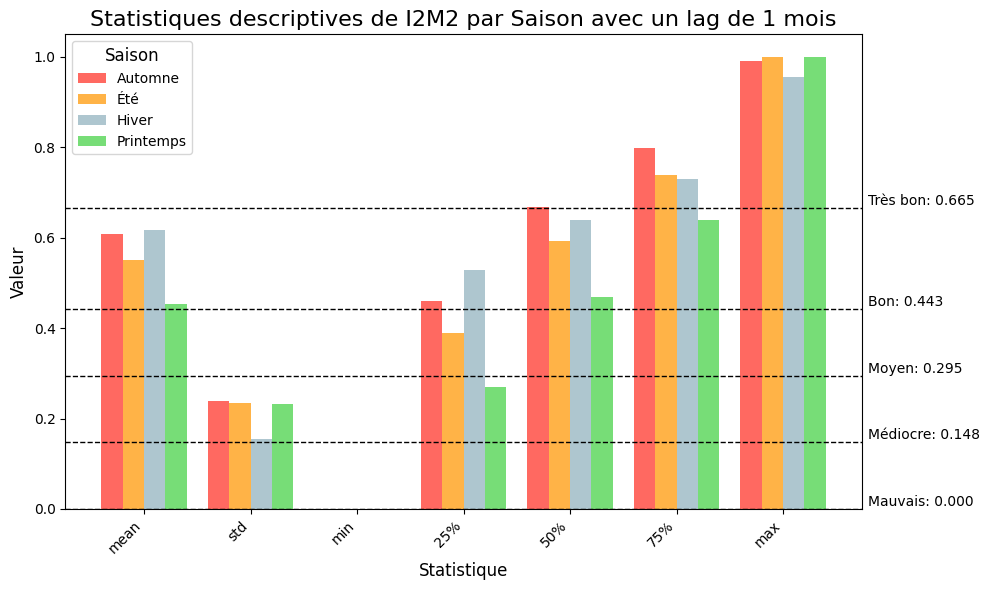

In [112]:
# Statistiques descriptives
desc_stats_saison = df_pc_median_bio_median_1_month.groupby('saison')['I2M2'].describe()
desc_stats_saison = desc_stats_saison.drop(columns=['count']).transpose()

plt.figure(figsize=(10, 6))

x_indices = np.arange(len(desc_stats_saison.index))
bar_width = 0.2
for i, saison in enumerate(saisons):
    plt.bar(x_indices + i * bar_width, desc_stats_saison[saison], width=bar_width, label=saison, color=season_colors.get(saison, 'gray'))

for etat, valeur in seuils_I2M2.items():
    plt.axhline(y=valeur,  color='black',  linestyle='--',  linewidth=1)

for etat, valeur in seuils_I2M2.items():
    plt.text(len(desc_stats_saison.index) + 0.1,  valeur,  f"{etat}: {valeur:.3f}",  fontsize=10,  color="black", verticalalignment='bottom', horizontalalignment='left')

plt.title("Statistiques descriptives de I2M2 par Saison avec un lag de 1 mois", fontsize=16)
plt.xlabel("Statistique", fontsize=12)
plt.ylabel("Valeur", fontsize=12)
plt.xticks(x_indices + (len(saisons) - 1) * bar_width / 2, desc_stats_saison.index, rotation=45, ha='right')
plt.legend(title="Saison", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

Après la fusion des datasets, les statistiques descriptives de l'I2M2 restent assez similaires. La fusion n'a donc pas altéré les tendances principales de l'I2M2.

### Aggrégation du dataset avec les données des stations et des hydroécorégions

Nous allons maintenant fusionner notre dataset avec celui des stations afin de récupérer les coordonnées géographiques des stations et déterminer leur appartenance aux hydroécorégions.

Ensuite, nous vérifierons le nombre de stations restantes dans les hydroécorégions après la fusion de tous les datasets. Cette étape de fusion a réduit le nombre total de stations en raison des différences dans les codes de stations, qui n'étaient pas toujours compatibles pour faire une jointure.

In [113]:
# Fusion avec le dataset des stations pour récupérer les coordonnées des stations
df_pc_median_bio_median_1_month_with_coords = pd.merge(
    df_pc_median_bio_median_1_month,
    df_stations[['station', 'CoordXStationMesureEauxSurface', 'CoordYStationMesureEauxSurface']],
    on='station',
    how='inner'
)

#### Observation de la répartition des stations dans les hydroécorégions

In [114]:
df_to_count = df_pc_median_bio_median_1_month_with_coords.copy()

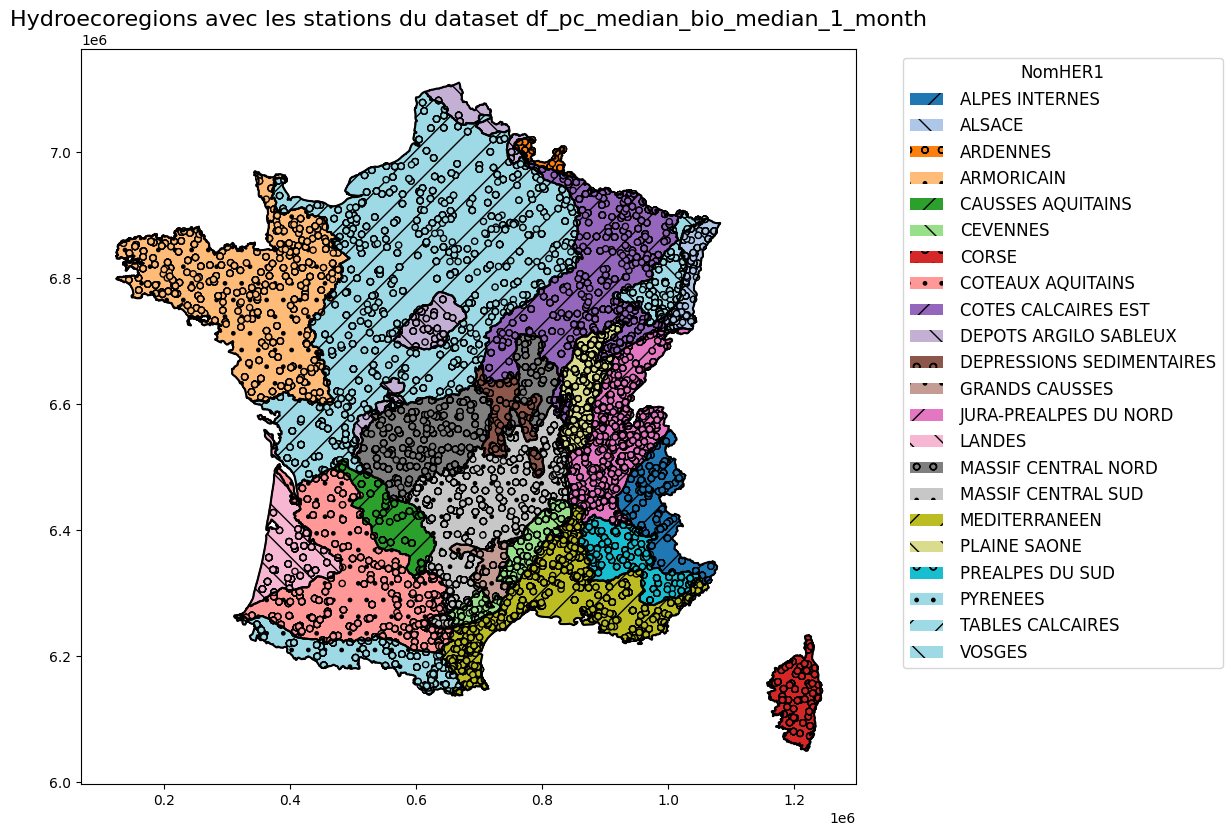

In [115]:
# Représentation des stations sur la carte des hydroécorégions
crs_lambert = 'PROJCS["RGF_1993_Lambert_93",GEOGCS["GCS_RGF_1993",DATUM["D_RGF_1993",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",700000.0],PARAMETER["False_Northing",6600000.0],PARAMETER["Central_Meridian",3.0],PARAMETER["Standard_Parallel_1",49.0],PARAMETER["Standard_Parallel_2",44.0],PARAMETER["Latitude_Of_Origin",46.5],UNIT["Meter",1.0]]'
x_col = 'CoordXStationMesureEauxSurface'
y_col = 'CoordYStationMesureEauxSurface'
carto_i2m2 = gpd.GeoDataFrame(df_to_count,crs=crs_lambert ,
                        geometry = gpd.GeoSeries(df_to_count.agg(lambda x:geom.Point(x.loc[x_col],x.loc[y_col])  ,axis=1)))
# Récupération des hydroécorégions pour les stations
HER_stations=carto_i2m2.sjoin(df_hydroregions.to_crs(crs_lambert),predicate='within').to_crs(crs_lambert)
fig, ax = plt.subplots(1, 1, figsize=(10, 30))
colors = plt.colormaps['tab20']
hatches = ['/', '\\', 'o', '.']
legend_elements = []
color_mapping = {}
for i, (name, region) in enumerate(df_hydroregions.groupby('NomHER1')):
    region = region.to_crs(crs_lambert)
    patch = region.plot(ax=ax, color=colors(i), hatch=hatches[i % len(hatches)], edgecolor='black', label=name)
    legend_elements.append(Patch(facecolor=colors(i), hatch=hatches[i % len(hatches)], label=name))
    color_mapping[name] = colors(i)
station_colors = HER_stations['NomHER1'].map(color_mapping)
HER_stations.plot(ax=ax, color=station_colors, markersize=20, edgecolor='black')
HER_lambert = df_hydroregions.to_crs(crs_lambert)
HER_lambert.boundary.plot(ax=ax, color='black')
ax.legend(handles=legend_elements, title='NomHER1', bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize='large', title_fontsize='large', handletextpad=1)
ax.set_title('Hydroecoregions avec les stations du dataset df_pc_median_bio_median_1_month', fontsize=16)
plt.show()

On observe ici des régions plus peuplées que d'autres.
Par exemple, les Landes comportent moins de stations que les Tables Calcaires.

In [116]:
print(f"Nombre de doublons dans df_stations : {df_stations.duplicated(subset='station').sum()}")
print(f"Nombre de doublons dans df_pc_median_bio_median_1_month_with_coords : {df_to_count.duplicated(subset='station').sum()}")

Nombre de doublons dans df_stations : 7
Nombre de doublons dans df_pc_median_bio_median_1_month_with_coords : 18909


In [117]:
df_stations.drop_duplicates(subset='station', inplace=True)
df_to_count.drop_duplicates(subset='station', inplace=True)

In [118]:
# Récupération des hydroécorégions pour les stations dans df_stations
carto_i2m2_1 = gpd.GeoDataFrame(df_stations,crs=crs_lambert, geometry = gpd.GeoSeries(df_stations.agg(lambda x:geom.Point(x.loc['CoordXStationMesureEauxSurface'],x.loc['CoordYStationMesureEauxSurface'])  ,axis=1)))
HER_stations_1=carto_i2m2_1.sjoin(df_hydroregions.to_crs(crs_lambert),predicate='within').to_crs(crs_lambert)
# Récupération des hydroécorégions pour les stations dans df_pc_median_bio_median_1_month_with_coords
carto_i2m2_2 = gpd.GeoDataFrame(df_to_count,crs=crs_lambert, geometry = gpd.GeoSeries(df_to_count.agg(lambda x:geom.Point(x.loc['CoordXStationMesureEauxSurface'],x.loc['CoordYStationMesureEauxSurface'])  ,axis=1)))
HER_stations_2=carto_i2m2_2.sjoin(df_hydroregions.to_crs(crs_lambert),predicate='within').to_crs(crs_lambert)

In [119]:
print(f"Nombre de doublons après jointure spatiale dans HER_stations_1 : {HER_stations_1.duplicated(subset='station').sum()}")
print(f"Nombre de doublons après jointure spatiale dans HER_stations : {HER_stations_2.duplicated(subset='station').sum()}")

Nombre de doublons après jointure spatiale dans HER_stations_1 : 0
Nombre de doublons après jointure spatiale dans HER_stations : 0


In [120]:
# Nombre de stations par région hydroécologique dans df_stations et dans df_pc_median_bio_median_1_month
# df_stations
stations_count_by_region_1 = HER_stations_1.groupby('NomHER1').size().reset_index(name='count')
# df_pc_median_bio_median_1_month
stations_count_by_region_2 = HER_stations_2.groupby('NomHER1').size().reset_index(name='count')
# comparaison du nombre de stations entre les deux dataframes
comparison = pd.merge(stations_count_by_region_1, stations_count_by_region_2, on='NomHER1', how='outer', suffixes=('_df_stations', '_df_pc_median'))
print(comparison)

                      NomHER1  count_df_stations  count_df_pc_median
0              ALPES INTERNES                156                  84
1                      ALSACE                352                  97
2                    ARDENNES                 63                  15
3                  ARMORICAIN                445                 249
4           CAUSSES AQUITAINS                 47                  31
5                    CEVENNES                106                  81
6                       CORSE                 63                  47
7           COTEAUX AQUITAINS                265                 188
8         COTES CALCAIRES EST               1008                 269
9       DEPOTS ARGILO SABLEUX                 47                  35
10  DEPRESSIONS SEDIMENTAIRES                 63                  43
11             GRANDS CAUSSES                 25                  18
12      JURA-PREALPES DU NORD                628                 390
13                     LANDES     

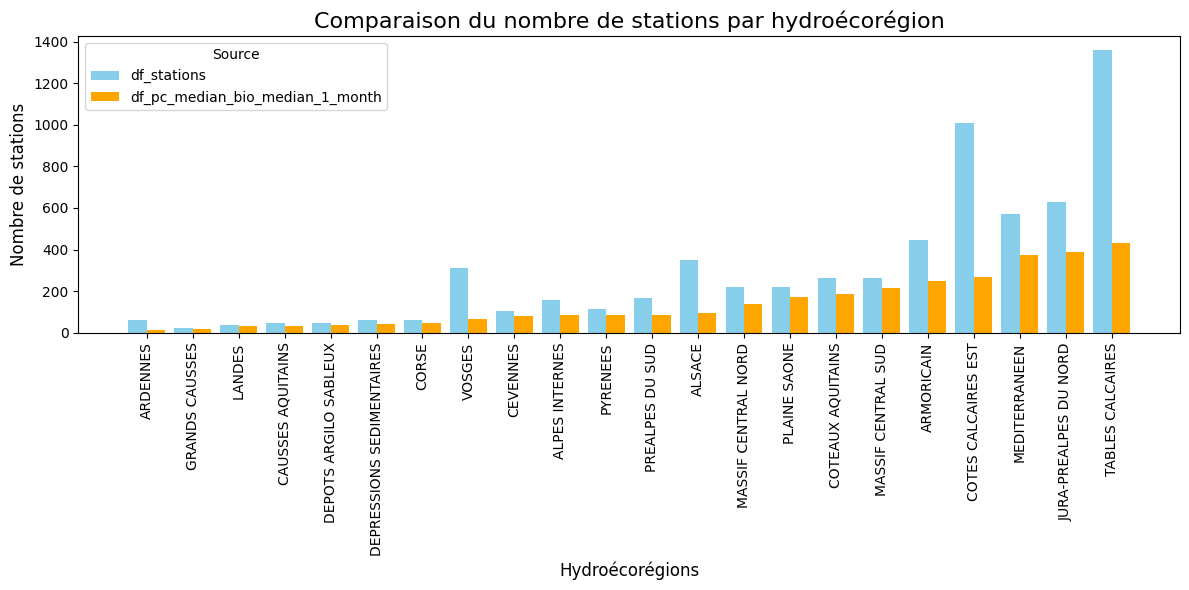

In [121]:
# Affichage du nombre de stations par hydroécorégion dans les 2 dataframes
comparison_sorted = comparison.sort_values('count_df_pc_median', ascending=True)

hydroecoregions = comparison_sorted['NomHER1']
count_df_stations = comparison_sorted['count_df_stations']
count_df_pc_median = comparison_sorted['count_df_pc_median']
x_indices = np.arange(len(hydroecoregions))
bar_width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x_indices - bar_width / 2, count_df_stations, width=bar_width, label='df_stations', color='skyblue')
plt.bar(x_indices + bar_width / 2, count_df_pc_median, width=bar_width, label='df_pc_median_bio_median_1_month', color='orange')
plt.title("Comparaison du nombre de stations par hydroécorégion", fontsize=16)
plt.xlabel("Hydroécorégions", fontsize=12)
plt.ylabel("Nombre de stations", fontsize=12)
plt.xticks(x_indices, hydroecoregions, rotation=90)
plt.legend(title="Source", fontsize=10)
plt.tight_layout()
plt.show()

Certaines hydrorégions sont très sous représentées, et les plus représentées ont au maximum 430 stations ce qui reste peu.

In [122]:
# Calcul de la perte
comparison['percentage_loss'] = ((comparison['count_df_stations'] - comparison['count_df_pc_median'])/ comparison['count_df_stations']) * 100
comparison['percentage_loss'] = comparison['percentage_loss'].fillna(0)
comparison.sort_values('percentage_loss', inplace=True)

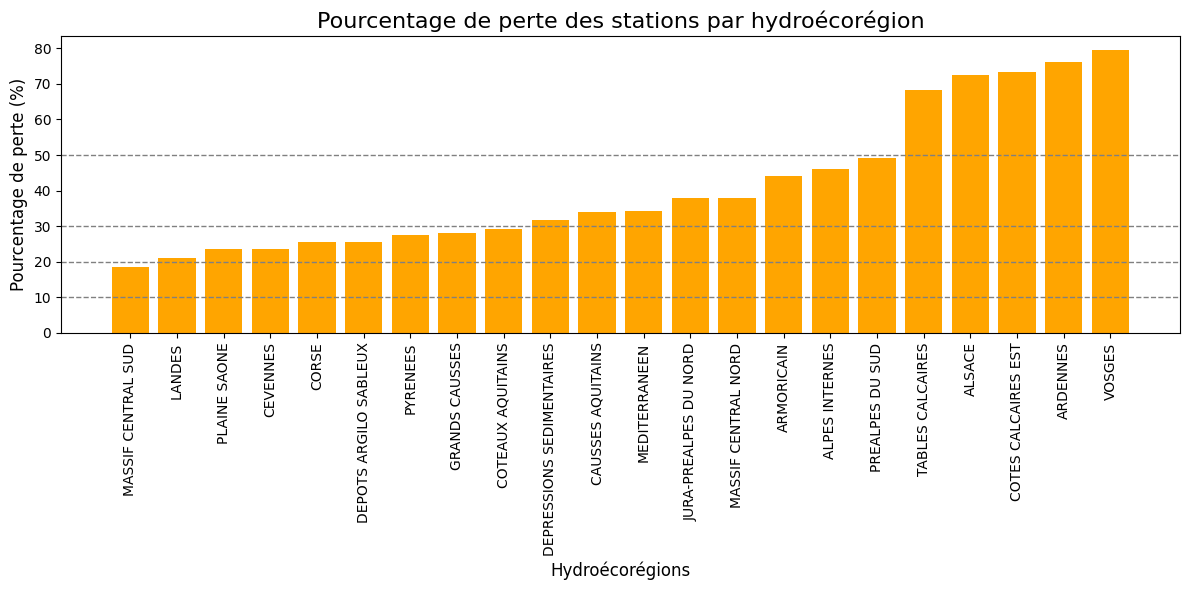

In [123]:
# Affichage du pourcentage de perte du nombre de stations par hydroécorégion
hydroecoregions = comparison['NomHER1']
percentage_loss = comparison['percentage_loss']

plt.figure(figsize=(12, 6))
plt.bar(hydroecoregions, percentage_loss, color='orange', label='Pourcentage de perte')

seuils = [10, 20, 30, 50]
for seuil in seuils:
    plt.axhline(y=seuil, color='gray', linestyle='--', linewidth=1, label=f'Seuil {seuil}%')

plt.title("Pourcentage de perte des stations par hydroécorégion", fontsize=16)
plt.xlabel("Hydroécorégions", fontsize=12)
plt.ylabel("Pourcentage de perte (%)", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [124]:
# Calcul du nombre de stations perdues au total
total_stations_initial = comparison['count_df_stations'].sum()
total_stations_final = comparison['count_df_pc_median'].sum()
total_stations_perdue = total_stations_initial - total_stations_final
print(f"Nombre total de stations perdues : {total_stations_perdue}")
print(f"Pourcentage de stations perdues : {round((total_stations_perdue / total_stations_initial) * 100, 2)}%")


Nombre total de stations perdues : 3401
Pourcentage de stations perdues : 52.0%


Suite à la fusion des différents datasets, nous constatons une perte significative de stations par rapport au dataset initial. Au total, plus de 3000 stations, soit environ 50 % des stations, ont été perdues. 

La distribution des pertes par hydroécorégion montre que certaines régions, comme les Vosges et les Ardennes, ont perdu une proportion importante de leurs stations, tandis que d'autres, comme le Massif Central Sud et la Plaine de la Saône, en ont conservé une plus grande partie, avec cependant environ 20% de perte.  
Ces disparités régionales pourraient influencer les résultats de nos analyses.

### Analyse des corrélations entre les caractéristiques

In [125]:
df_correl = df_pc_median_bio_median_1_month_with_coords.copy()

In [126]:
# Ajout des hydrorégions pour voir si des caractéristiques y sont corrélées
carto_i2m2_correl = gpd.GeoDataFrame(df_correl,crs=crs_lambert, geometry = gpd.GeoSeries(df_correl.agg(lambda x:geom.Point(x.loc['CoordXStationMesureEauxSurface'],x.loc['CoordYStationMesureEauxSurface'])  ,axis=1)))
HER_stations_correl=carto_i2m2_correl.sjoin(df_hydroregions.to_crs(crs_lambert),predicate='within').to_crs(crs_lambert)
df_correl = HER_stations_correl.drop(columns=['geometry', 'index_right', 'NomHER1', 'gid']) 

In [127]:
df_correl['saison'] = df_correl['saison'].factorize()[0]

In [128]:
# Mapping des colonnes pour pouvoir afficher la matrice de corrélation correctement
column_mapping = {
    'Ammonium - Eau': 'NH4',
    'Azote Kjeldahl - Eau': 'NKjeldahl',
    'Carbone Organique - Eau': 'CO',
    'Conductivité à 25°C - Eau': 'Cond25',
    'Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau': 'DBO5',
    'Matières en suspension - Eau': 'MES',
    'Nitrates - Eau': 'NO3',
    'Nitrites - Eau': 'NO2',
    'Orthophosphates (PO4) - Eau': 'PO4',
    'Oxygène dissous - Eau': 'O2',
    'Phosphore total - Eau': 'Ptot',
    'Potentiel en Hydrogène (pH) - Eau': 'pH',
    'Taux de saturation en oxygène - Eau': 'O2_sat',
    'Température de l\'Eau - Eau': 'TempEau',
    'Turbidité Formazine Néphélométrique - Eau': 'Turbidité',
    'I2M2': 'I2M2',
    'CoordXStationMesureEauxSurface': 'CoordX',
    'CoordYStationMesureEauxSurface': 'CoordY'
}
df_correl = df_correl.rename(columns=column_mapping, index=column_mapping)

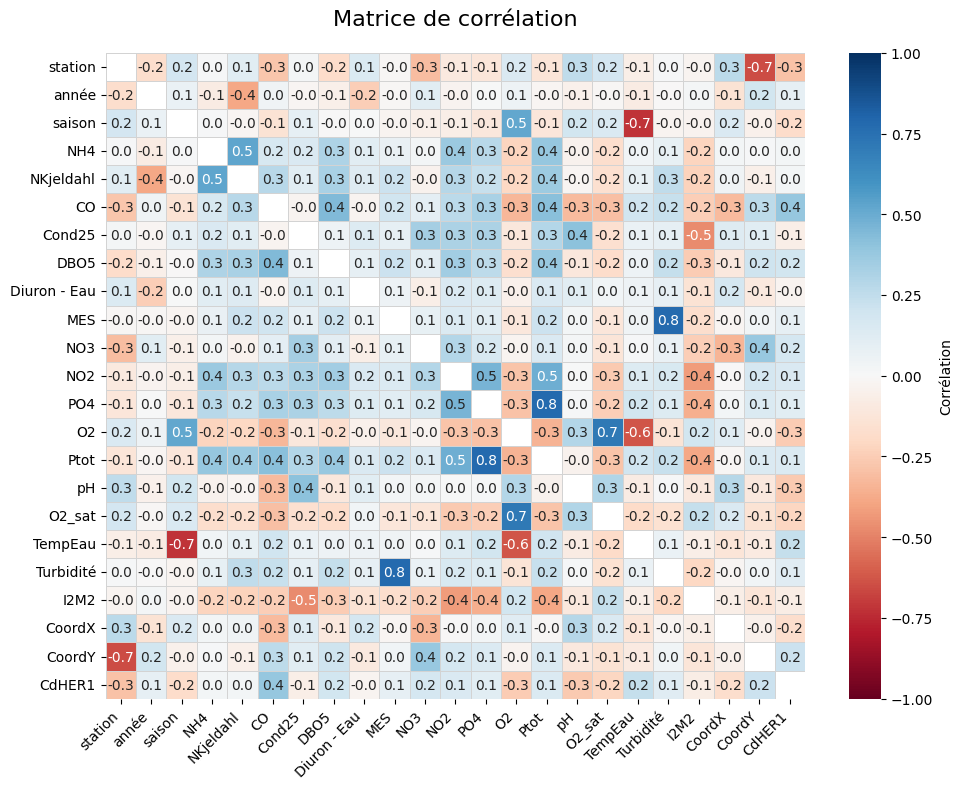

In [129]:
# Création de la matrice de corrélation
correlation_matrix = df_correl.corr()
np.fill_diagonal(correlation_matrix.values, np.nan)

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="RdBu", vmin=-1, vmax=1, cbar_kws={"label": "Corrélation"}, linewidths=0.5, linecolor='lightgray', mask=np.isnan(correlation_matrix))

plt.title("Matrice de corrélation", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Cette matrice de corrélation révèle des relations entre plusieurs caractéristiques. Notamment : 

**I2M2** : Corrélé négativement à Cond25, NO2, PO4 et Ptot, indiquant une dégradation biologique lorsque ces paramètres augmentent. Positivement corrélé à l’oxygène dissous et son taux de saturation, soulignant leur importance pour la qualité biologique.

## Clustering des stations

### Démarche

Dans cette partie, nous cherchons à répondre à la question :  
**Est-il possible de retrouver les hydroécorégions à partir des données physicochimiques et hydrobiologiques ?**

Pour cela, nous avons réalisé un clustering pour regrouper les stations en fonction de leurs caractéristiques. Cette approche nous permet d’identifier des regroupements naturels basés sur les données, susceptibles de refléter les hydroécorégions, tout en capturant des relations complexes et non linéaires que les corrélations simples ne révèlent pas.

Nous avons commencé par un nettoyage des données, incluant la gestion des valeurs manquantes et des variables non numériques. Les données ont été normalisées.

Ensuite, nous avons déterminé le nombre optimal de clusters en utilisant deux méthodes : la méthode du coude (basée sur la diminution de l'inertie) et le coefficient Davies-Bouldin (évaluant la séparation et la compacité des clusters). Un peu plus loin, on a aussi utilisé le score de la silhouette.

Une fois le nombre de clusters défini, nous avons appliqué l’algorithme K-means pour attribuer un cluster à chaque station. 

Enfin, nous avons analysé les résultats en comparant les clusters obtenus avec les hydroécorégions afin d’évaluer leur cohérence.

### Préparation des données

#### Gestion des données manquantes

In [130]:
df_pc_median_bio_median_1_month_with_coords.isnull().sum()

station                                                         0
année                                                           0
saison                                                          0
Ammonium - Eau                                               2109
Azote Kjeldahl - Eau                                         2512
Carbone Organique - Eau                                      1748
Conductivité à 25°C - Eau                                     351
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    2015
Diuron - Eau                                                 9367
Matières en suspension - Eau                                  371
Nitrates - Eau                                               2022
Nitrites - Eau                                               2019
Orthophosphates (PO4) - Eau                                  1957
Oxygène dissous - Eau                                         407
Phosphore total - Eau                                        1633
Potentiel 

In [131]:
missing_percentage = df_pc_median_bio_median_1_month_with_coords.isnull().mean() * 100
print(missing_percentage)

station                                                       0.000000
année                                                         0.000000
saison                                                        0.000000
Ammonium - Eau                                                9.557257
Azote Kjeldahl - Eau                                         11.383514
Carbone Organique - Eau                                       7.921330
Conductivité à 25°C - Eau                                     1.590610
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau     9.131282
Diuron - Eau                                                 42.447999
Matières en suspension - Eau                                  1.681243
Nitrates - Eau                                                9.163004
Nitrites - Eau                                                9.149409
Orthophosphates (PO4) - Eau                                   8.868446
Oxygène dissous - Eau                                         1.844383
Phosph

In [132]:
# plus de 40 % de données manquantes pour Diuron - Eau
# on peut supprimer cette colonne
df_pc_median_bio_median_1_month_with_coords.drop(columns=['Diuron - Eau'], inplace=True)

In [133]:
# Calculer le nombre de valeurs manquantes par ligne
missing_values_per_row = df_pc_median_bio_median_1_month_with_coords.isnull().sum(axis=1)
missing_summary = missing_values_per_row.value_counts().reset_index()
missing_summary.columns = ['Nombre de valeurs manquantes', 'Nombre de lignes']
print(missing_summary.sort_values('Nombre de valeurs manquantes'))

    Nombre de valeurs manquantes  Nombre de lignes
0                              0             11776
1                              1              7137
3                              2               823
5                              3               197
9                              4                97
4                              5               261
8                              6               127
7                              7               144
2                              8              1087
12                             9                42
6                             10               193
11                            11                81
15                            12                 1
13                            13                 8
10                            14                87
14                            15                 6


Nous avons imputé les données manquantes par leur médiane. Nous avons également testé d'imputer ces données par leur moyenne mais les résultats de clusterings étaient légèrement moins bons.

In [134]:
# Imputation des valeurs manquantes avec la médiane
imputer = SimpleImputer(strategy='median') # ici on pourrait aussi mettre mean
colonnes = df_pc_median_bio_median_1_month_with_coords.columns
colonnes = colonnes.drop('station')
colonnes = colonnes.drop('année')
colonnes = colonnes.drop('saison')
colonnes = colonnes.drop('I2M2')
df_pc_median_bio_median_1_month_with_coords[colonnes] = imputer.fit_transform(df_pc_median_bio_median_1_month_with_coords[colonnes])
df_pc_median_bio_median_1_month_with_coords.isnull().sum()

station                                                      0
année                                                        0
saison                                                       0
Ammonium - Eau                                               0
Azote Kjeldahl - Eau                                         0
Carbone Organique - Eau                                      0
Conductivité à 25°C - Eau                                    0
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    0
Matières en suspension - Eau                                 0
Nitrates - Eau                                               0
Nitrites - Eau                                               0
Orthophosphates (PO4) - Eau                                  0
Oxygène dissous - Eau                                        0
Phosphore total - Eau                                        0
Potentiel en Hydrogène (pH) - Eau                            0
Taux de saturation en oxygène - Eau                    

#### Gestion des données non numériques

In [135]:
# Mapper chaque saison à un trimestre
saison_to_quarter = {
    "Hiver": 1,
    "Printemps": 2,
    "Été": 3,
    "Automne": 4
}
df_pc_median_bio_median_1_month_with_coords['trimestre'] = df_pc_median_bio_median_1_month_with_coords['saison'].map(saison_to_quarter)
# drop saison
df_pc_median_bio_median_1_month_with_coords.drop(columns=['saison'], inplace=True)
df_pc_median_bio_median_1_month_with_coords.head(5)

station  année  Ammonium - Eau  Azote Kjeldahl - Eau  \
0  5001800   2007            0.04                   1.0   
1  5001800   2008            0.04                   1.0   
2  5001800   2009            0.02                   1.0   
3  5005350   2007            0.04                   1.0   
4  5005350   2008            0.03                   1.0   

   Carbone Organique - Eau  Conductivité à 25°C - Eau  \
0                      3.5                      765.0   
1                      2.7                      765.0   
2                      2.2                      736.0   
3                      1.6                      600.0   
4                      1.6                      610.0   

   Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau  \
0                                                0.5           
1                                                0.6           
2                                                1.0           
3                                                1.9           
4                                                1.0           

   Matières en suspension - Eau  Nitrates - Eau  Nitrites - Eau  ...  \
0                           3.0            36.2            0.09  ...   
1                           4.0            40.3            0.07  ...   
2                           6.0            37.9            0.07  ...   
3                          22.0            41.7            0.07  ...   
4                          40.0            40.5            0.07  ...   

   Oxygène dissous - Eau  Phosphore total - Eau  \
0                    8.1                   0.05   
1                    8.3                   0.11   
2                    7.4                   0.07   
3                    7.3                   0.33   
4                    8.9                   0.25   

   Potentiel en Hydrogène (pH) - Eau  Taux de saturation en oxygène - Eau  \
0                                7.9                                 89.0   
1                                7.9                                 90.0   
2                                8.0                                 83.0   
3                                8.1                                 76.0   
4                                8.1                                 86.0   

   Température de l'Eau - Eau  Turbidité Formazine Néphélométrique - Eau  \
0                        18.6                                        4.3   
1                        20.5                                        4.3   
2                        20.6                                        4.3   
3                        18.6                                        4.3   
4                        14.2                                        4.3   

     I2M2  CoordXStationMesureEauxSurface  CoordYStationMesureEauxSurface  \
0  0.3004                        399856.0                       6531980.0   
1  0.3848                        399856.0                       6531980.0   
2  0.5756                        399856.0                       6531980.0   
3  0.4851                        450151.0                       6572920.0   
4  0.3488                        450151.0                       6572920.0   

   trimestre  
0          3  
1          3  
2          3  
3          3  
4          3  

[5 rows x 21 columns]

In [136]:
# Convertir l'identifiant de station en variable catégorielle (cela crée un encodage numérique)
df_pc_median_bio_median_1_month_with_coords['station'] = df_pc_median_bio_median_1_month_with_coords['station'].astype(str)
df_pc_median_bio_median_1_month_with_coords['trimestre'] = df_pc_median_bio_median_1_month_with_coords['trimestre'].astype(int)
df_pc_median_bio_median_1_month_with_coords['année'] = df_pc_median_bio_median_1_month_with_coords['année'].astype(int)
df_pc_median_bio_median_1_month_with_coords.dtypes

station                                                       object
année                                                          int64
Ammonium - Eau                                               float64
Azote Kjeldahl - Eau                                         float64
Carbone Organique - Eau                                      float64
Conductivité à 25°C - Eau                                    float64
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    float64
Matières en suspension - Eau                                 float64
Nitrates - Eau                                               float64
Nitrites - Eau                                               float64
Orthophosphates (PO4) - Eau                                  float64
Oxygène dissous - Eau                                        float64
Phosphore total - Eau                                        float64
Potentiel en Hydrogène (pH) - Eau                            float64
Taux de saturation en oxygène - Ea

#### Suppression des colonnes

Nous supprimons les colonnes des coordonnées, afin de ne pas influencer le clustering.

In [137]:
df_pc_median_bio_median_1_month_c = df_pc_median_bio_median_1_month_with_coords.copy()

In [138]:
df_pc_median_bio_median_1_month_c = df_pc_median_bio_median_1_month_with_coords.drop(columns=['CoordXStationMesureEauxSurface', 'CoordYStationMesureEauxSurface'])
df_clustering = df_pc_median_bio_median_1_month_c.copy()

#### Normalisation et encodage des données

Pour préserver l'information relative aux stations, essentielle pour suivre l'évolution de leurs caractéristiques physicochimiques et hydrobiologiques sur plusieurs trimestres, nous avons choisi de conserver cette colonne dans le processus de clustering.

Pour minimiser tout biais lié aux identifiants de stations, nous avons encodé cette colonne avec des valeurs numériques arbitraires. Ensuite, comme pour les autres caractéristiques, nous avons normalisé ses valeurs afin d’assurer une contribution équilibrée au clustering.

Nous avons également testé la suppression de la colonne station, mais cela a légèrement dégradé les résultats. Par ailleurs, perdre le lien temporel qu’offre cette information entre les enregistrements nous semblait non pertinent. Nous avons donc décidé de conserver la colonne station, en sachant qu'elle introduit un léger biais.

In [139]:
df_clustering.head(5)

station  année  Ammonium - Eau  Azote Kjeldahl - Eau  \
0  5001800   2007            0.04                   1.0   
1  5001800   2008            0.04                   1.0   
2  5001800   2009            0.02                   1.0   
3  5005350   2007            0.04                   1.0   
4  5005350   2008            0.03                   1.0   

   Carbone Organique - Eau  Conductivité à 25°C - Eau  \
0                      3.5                      765.0   
1                      2.7                      765.0   
2                      2.2                      736.0   
3                      1.6                      600.0   
4                      1.6                      610.0   

   Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau  \
0                                                0.5           
1                                                0.6           
2                                                1.0           
3                                                1.9           
4                                                1.0           

   Matières en suspension - Eau  Nitrates - Eau  Nitrites - Eau  \
0                           3.0            36.2            0.09   
1                           4.0            40.3            0.07   
2                           6.0            37.9            0.07   
3                          22.0            41.7            0.07   
4                          40.0            40.5            0.07   

   Orthophosphates (PO4) - Eau  Oxygène dissous - Eau  Phosphore total - Eau  \
0                         0.05                    8.1                   0.05   
1                         0.05                    8.3                   0.11   
2                         0.05                    7.4                   0.07   
3                         0.54                    7.3                   0.33   
4                         0.27                    8.9                   0.25   

   Potentiel en Hydrogène (pH) - Eau  Taux de saturation en oxygène - Eau  \
0                                7.9                                 89.0   
1                                7.9                                 90.0   
2                                8.0                                 83.0   
3                                8.1                                 76.0   
4                                8.1                                 86.0   

   Température de l'Eau - Eau  Turbidité Formazine Néphélométrique - Eau  \
0                        18.6                                        4.3   
1                        20.5                                        4.3   
2                        20.6                                        4.3   
3                        18.6                                        4.3   
4                        14.2                                        4.3   

     I2M2  trimestre  
0  0.3004          3  
1  0.3848          3  
2  0.5756          3  
3  0.4851          3  
4  0.3488          3

Nous utilisons LabelEncoder plutôt que One-Hot Encoding en raison du volume important de données. One-Hot Encoding aurait entraîné une explosion du nombre de colonnes, ce qui aurait considérablement alourdi le traitement et augmenté la complexité du modèle. LabelEncoder permet de représenter les catégories sous forme d'entiers, ce qui est plus efficace en termes de mémoire et de calcul.

Étant donné que nous travaillons avec des données dont la distribution est bornée et sans connaître précisément leur forme, nous utilisons le MinMaxScaler. Ce dernier est plus adapté pour redimensionner les données dans une plage spécifique lorsque celles-ci sont déjà bornées.

In [140]:
# Encodage des stations
le = LabelEncoder()
df_clustering['station_encoded'] = le.fit_transform(df_clustering['station'])
df_clustering.drop(columns=['station'], inplace=True)
# Normalisation des données pour qu'elles aient toutes la même importance
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_clustering)
normalized_data = pd.DataFrame(normalized_data, columns=df_clustering.columns)

In [141]:
normalized_data.head(5)

année  Ammonium - Eau  Azote Kjeldahl - Eau  Carbone Organique - Eau  \
0  0.000000        0.006169              0.190283                 0.220588   
1  0.066667        0.006169              0.190283                 0.167112   
2  0.133333        0.002742              0.190283                 0.133690   
3  0.000000        0.006169              0.190283                 0.093583   
4  0.066667        0.004455              0.190283                 0.093583   

   Conductivité à 25°C - Eau  \
0                   0.423398   
1                   0.423398   
2                   0.407242   
3                   0.331476   
4                   0.337047   

   Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau  \
0                                           0.000000           
1                                           0.007407           
2                                           0.037037           
3                                           0.103704           
4                                           0.037037           

   Matières en suspension - Eau  Nitrates - Eau  Nitrites - Eau  \
0                      0.005657        0.614274        0.096045   
1                      0.007833        0.683942        0.073446   
2                      0.012185        0.643161        0.073446   
3                      0.046997        0.707732        0.073446   
4                      0.086162        0.687341        0.073446   

   Orthophosphates (PO4) - Eau  Oxygène dissous - Eau  Phosphore total - Eau  \
0                     0.018265               0.456140               0.032258   
1                     0.018265               0.467836               0.075269   
2                     0.018265               0.415205               0.046595   
3                     0.242009               0.409357               0.232975   
4                     0.118721               0.502924               0.175627   

   Potentiel en Hydrogène (pH) - Eau  Taux de saturation en oxygène - Eau  \
0                           0.516854                             0.453039   
1                           0.516854                             0.464088   
2                           0.539326                             0.386740   
3                           0.561798                             0.309392   
4                           0.561798                             0.419890   

   Température de l'Eau - Eau  Turbidité Formazine Néphélométrique - Eau  \
0                    0.588571                                   0.012003   
1                    0.642857                                   0.012003   
2                    0.645714                                   0.012003   
3                    0.588571                                   0.012003   
4                    0.462857                                   0.012003   

     I2M2  trimestre  station_encoded  
0  0.3004   0.666667         0.380424  
1  0.3848   0.666667         0.380424  
2  0.5756   0.666667         0.380424  
3  0.4851   0.666667         0.380741  
4  0.3488   0.666667         0.380741

### Recherche du nombre de clusters optimal

In [142]:
nb_hydroecoregions = df_hydroregions['CdHER1'].nunique()
print("Nombre d'hydroécorégions : ", nb_hydroecoregions)

Nombre d'hydroécorégions :  22


In [143]:
# Plage des valeurs de k à tester
k_values = range(nb_hydroecoregions-5, nb_hydroecoregions+5)

In [144]:
# Calcule de l'inertie et du score de Davies-Bouldin pour chaque valeur de k
davies_bouldin_scores = []
inertia = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)
    cluster_labels = kmeans.fit_predict(normalized_data)
    davies_bouldin_scores.append(davies_bouldin_score(normalized_data, cluster_labels))

#### Méthode du coude

La méthode du coude consiste à observer la diminution de l'inertie (somme des erreurs quadratiques intra-clusters) en fonction du nombre de clusters. Le point où la diminution devient moins significative peut indiquer le nombre optimal de clusters.

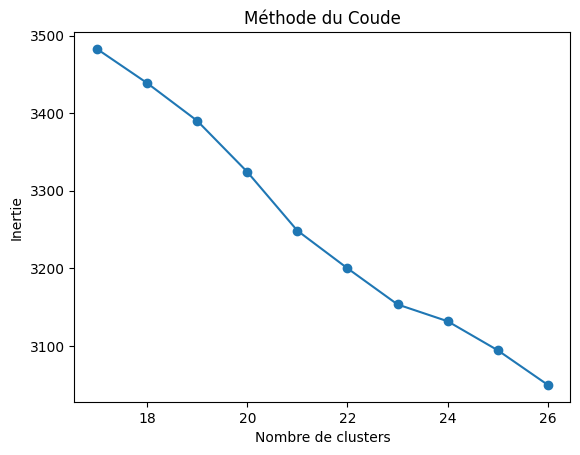

In [145]:
# Tracer l'inertie pour observer le coude
plt.plot(k_values, inertia, marker='o')
plt.title('Méthode du Coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

Nous n'arrivons pas à voir de coude, cela rend impossible à déterminer le nombre optimal de clusters. Nous allons donc utiliser le coefficient Davies-Bouldin pour faire notre choix.

#### Coefficient Davies-Bouldin

Le coefficient Davies-Bouldin évalue la qualité des clusters en mesurant leur compacité et leur séparation. Une valeur plus faible indique des clusters mieux définis.

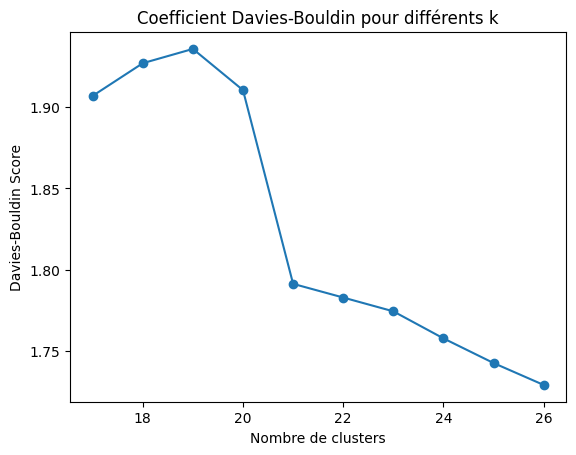

In [146]:
plt.plot(k_values, davies_bouldin_scores, marker='o')
plt.title('Coefficient Davies-Bouldin pour différents k')
plt.xlabel('Nombre de clusters')
plt.ylabel('Davies-Bouldin Score')
plt.show()

On voit tout de même une nette amélioration autour de 21. Le score continue de décroître.
Nous allons tout de même utiliser k = 22 pour notre clustering, car le but est de retrouver les hydroécorégions.

### Réalisation du clustering avec K-Means

#### Clustering

In [147]:
nb_clusters = 22 # c'est le nombre d'hydroecoregions

In [148]:
kmeans = KMeans(n_clusters=nb_clusters, random_state=42)
kmeans.fit(normalized_data)

KMeans(n_clusters=22, random_state=42)

#### Analyse des caractéristiques des clusters

In [149]:
# Analyse des centres des clusters
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_clustering.columns)
print("Centres des clusters :")
print(cluster_centers)
# Variabilité des caractéristiques par cluster
influence = cluster_centers.std(axis=0)
print("\nInfluence des caractéristiques :")
print(influence.sort_values(ascending=False))

Centres des clusters :
       année  Ammonium - Eau  Azote Kjeldahl - Eau  Carbone Organique - Eau  \
0   0.772329        0.005064              0.095821                 0.172983   
1   0.817114        0.003512              0.097321                 0.087083   
2   0.754424        0.012040              0.113979                 0.150117   
3   0.745901        0.003743              0.097118                 0.076335   
4   0.780175        0.012830              0.146526                 0.326294   
5   0.302173        0.017037              0.176025                 0.133773   
6   0.284585        0.009985              0.173107                 0.080147   
7   0.549403        0.005554              0.100586                 0.127999   
8   0.763867        0.008149              0.093550                 0.112734   
9   0.240414        0.017779              0.181317                 0.207181   
10  0.760026        0.013039              0.107987                 0.148376   
11  0.191924        0.008992 

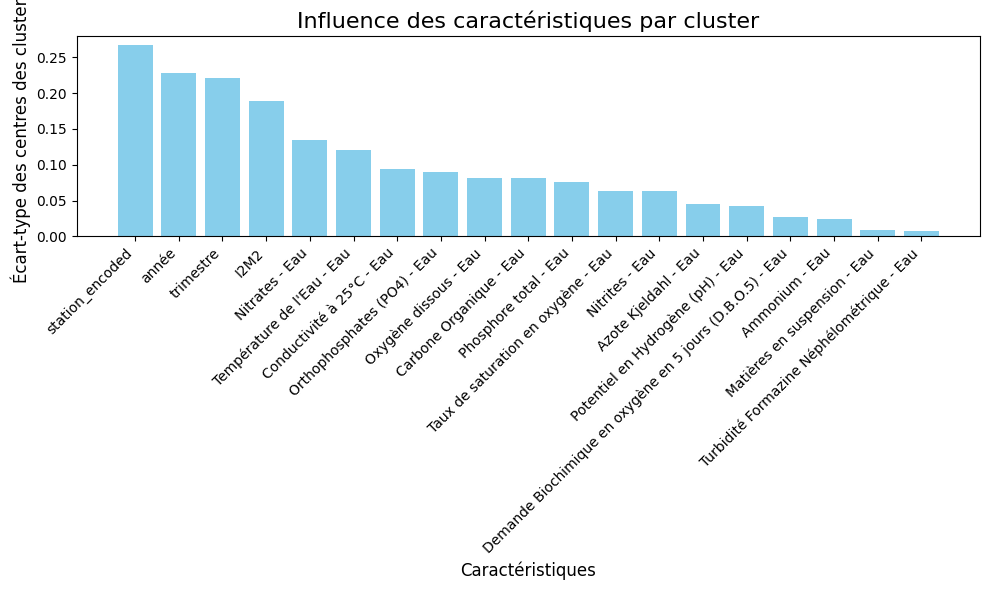

In [150]:
# Affichage des caractéristiques avec les plus grandes variabilités entre clusters
# = Caractéristiques les plus influentes
influence_sorted = influence.sort_values(ascending=False)

plt.figure(figsize=(10, 6))

plt.bar(influence_sorted.index, influence_sorted.values, color='skyblue')

plt.title("Influence des caractéristiques par cluster", fontsize=16)
plt.xlabel("Caractéristiques", fontsize=12)
plt.ylabel("Écart-type des centres des clusters", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

En dehors des données spatio-temporelles, les paramètres ayant le plus d'impact sont l'indice I2M2, les Nitrates, la Température de l'eau et la Conductivité à 25°C.

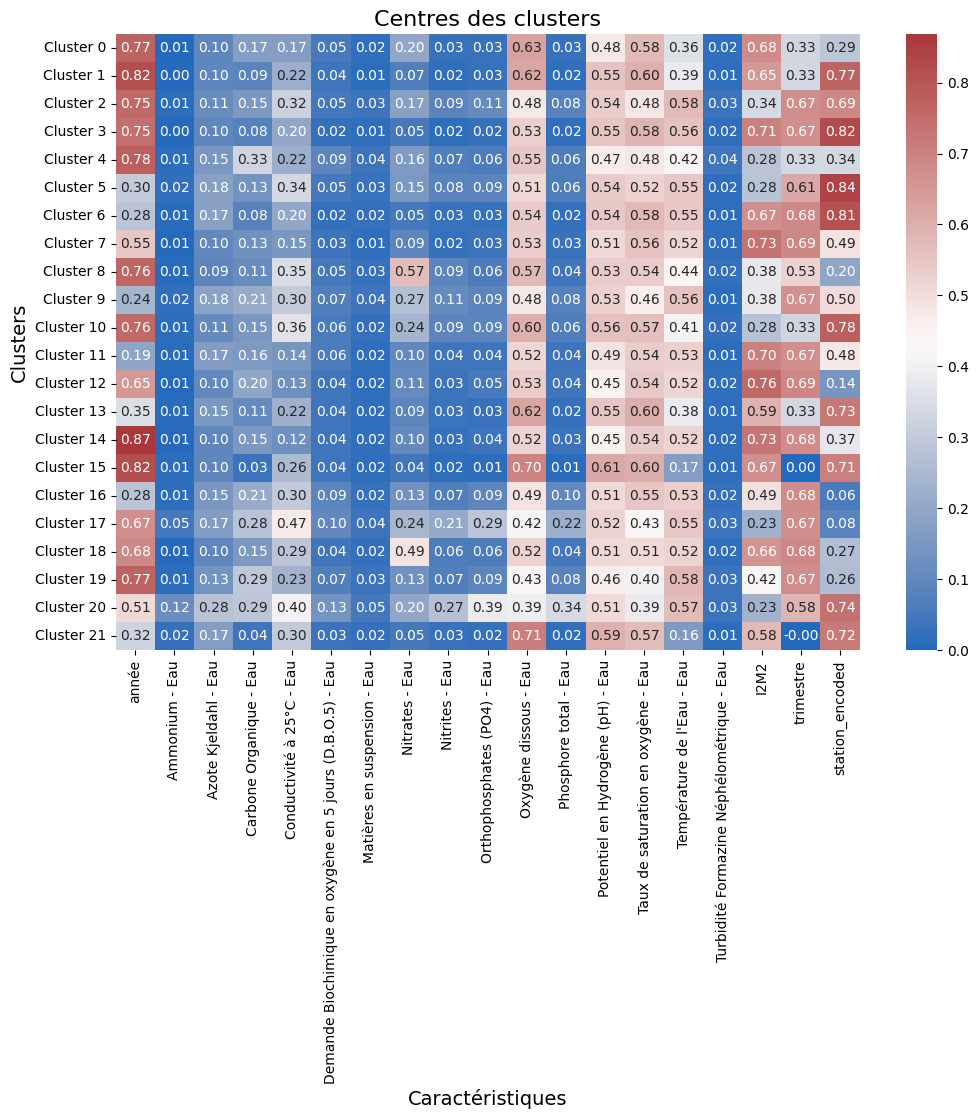

In [151]:
# Matrice des centres des clusters
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centers, annot=True, fmt=".2f", cmap="vlag", xticklabels=df_clustering.columns, yticklabels=[f'Cluster {i}' for i in range(len(cluster_centers))])
plt.title("Centres des clusters", fontsize=16)
plt.xlabel("Caractéristiques", fontsize=14)
plt.ylabel("Clusters", fontsize=14)
plt.show()

La matrice des centres des clusters révèle des valeurs disparates pour l'indice I2M2, les Nitrates, le Carbone organique et la Conductivité de l'eau. En revanche, pour certaines colonnes, nous obtenons des valeurs identiques, avec une ou deux valeurs dominantes dans l'ensemble des clusters.

On note que cela est en correspondance avec l'influence des caractéristiques par cluster.

#### Attribution des clusters

In [152]:
df_pc_median_bio_median_1_month_with_clusters = df_pc_median_bio_median_1_month_c.copy()

In [153]:
df_pc_median_bio_median_1_month_with_clusters['cluster'] = kmeans.labels_

In [154]:
df_pc_median_bio_median_1_month_with_clusters.head(5)

station  année  Ammonium - Eau  Azote Kjeldahl - Eau  \
0  5001800   2007            0.04                   1.0   
1  5001800   2008            0.04                   1.0   
2  5001800   2009            0.02                   1.0   
3  5005350   2007            0.04                   1.0   
4  5005350   2008            0.03                   1.0   

   Carbone Organique - Eau  Conductivité à 25°C - Eau  \
0                      3.5                      765.0   
1                      2.7                      765.0   
2                      2.2                      736.0   
3                      1.6                      600.0   
4                      1.6                      610.0   

   Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau  \
0                                                0.5           
1                                                0.6           
2                                                1.0           
3                                                1.9           
4                                                1.0           

   Matières en suspension - Eau  Nitrates - Eau  Nitrites - Eau  \
0                           3.0            36.2            0.09   
1                           4.0            40.3            0.07   
2                           6.0            37.9            0.07   
3                          22.0            41.7            0.07   
4                          40.0            40.5            0.07   

   Orthophosphates (PO4) - Eau  Oxygène dissous - Eau  Phosphore total - Eau  \
0                         0.05                    8.1                   0.05   
1                         0.05                    8.3                   0.11   
2                         0.05                    7.4                   0.07   
3                         0.54                    7.3                   0.33   
4                         0.27                    8.9                   0.25   

   Potentiel en Hydrogène (pH) - Eau  Taux de saturation en oxygène - Eau  \
0                                7.9                                 89.0   
1                                7.9                                 90.0   
2                                8.0                                 83.0   
3                                8.1                                 76.0   
4                                8.1                                 86.0   

   Température de l'Eau - Eau  Turbidité Formazine Néphélométrique - Eau  \
0                        18.6                                        4.3   
1                        20.5                                        4.3   
2                        20.6                                        4.3   
3                        18.6                                        4.3   
4                        14.2                                        4.3   

     I2M2  trimestre  cluster  
0  0.3004          3        9  
1  0.3848          3        9  
2  0.5756          3        9  
3  0.4851          3        9  
4  0.3488          3        9

#### Calcul du score de silhouette

In [155]:
# Calculer le score de la silhouette
score = silhouette_score(normalized_data, df_pc_median_bio_median_1_month_with_clusters['cluster'])
print(f"Silhouette score: {score}")

Silhouette score: 0.1251427074415718


Le score de silhouette obtenu est plutôt faible, ce qui indique que les stations ne sont pas clairement regroupées dans leurs clusters respectifs, et que certaines stations sont plus proches des centres d'autres clusters.

In [156]:
# Recherche du meilleur nombre de clusters selon le score de silhouette
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)
    
    score = silhouette_score(normalized_data, cluster_labels)
    silhouette_scores.append(score)

best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Le meilleur nombre de clusters est : {best_k}")

Le meilleur nombre de clusters est : 26


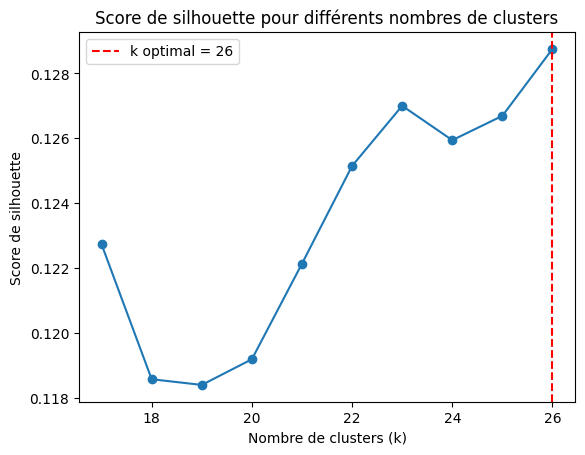

In [157]:
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Score de silhouette pour différents nombres de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score de silhouette")
plt.axvline(x=best_k, color='r', linestyle='--', label=f"k optimal = {best_k}")
plt.legend()
plt.show()

Le score de silhouette est le meilleur quand k = 26. Nous conservons k = 22, afin de rester alignée avec notre problématique de correspondance avec les hydroécorégions.

### Etude des résultats obtenus

#### Chaque station a-t-elle été assignée à un seul cluster ?

In [158]:
# Créer un DataFrame pour calculer le pourcentage d'appartenance des stations aux clusters
cluster_distribution = df_pc_median_bio_median_1_month_with_clusters.groupby('station')['cluster'].value_counts(normalize=True).unstack().fillna(0) * 100
print(cluster_distribution)

cluster         0    1           2     3    4          5    6    7   \
station                                                               
1000477  16.666667  0.0    0.000000   0.0  0.0   0.000000  0.0  0.0   
1000602   0.000000  0.0    0.000000   0.0  0.0   0.000000  0.0  0.0   
1000605   0.000000  0.0    0.000000   0.0  0.0   0.000000  0.0  0.0   
1001122   0.000000  0.0    0.000000   0.0  0.0   0.000000  0.0  0.0   
1001131   0.000000  0.0    0.000000   0.0  0.0   0.000000  0.0  0.0   
...            ...  ...         ...   ...  ...        ...  ...  ...   
6999125   0.000000  0.0    7.142857   0.0  0.0  28.571429  0.0  0.0   
6999137   0.000000  0.0   20.000000  60.0  0.0  20.000000  0.0  0.0   
6999153   0.000000  0.0   60.000000   0.0  0.0  40.000000  0.0  0.0   
6999176   0.000000  0.0  100.000000   0.0  0.0   0.000000  0.0  0.0   
6999178   0.000000  0.0  100.000000   0.0  0.0   0.000000  0.0  0.0   

cluster          8    9   ...         12        13   14   15   16         17

In [159]:
# combien de lignes dans le dataframe ?
df_pc_median_bio_median_1_month_with_clusters.shape[0]

22067

In [160]:
# combien de stations différentes ?
df_pc_median_bio_median_1_month_with_clusters['station'].nunique()

3158

In [161]:
stations_100_percent = cluster_distribution[cluster_distribution.eq(100.0).sum(axis=1) == 1]
print("Stations à 100% dans un seul cluster :", end=' ')
print(stations_100_percent.shape[0])
print("Pourcentage de stations 100% dans le même cluster : ", round(stations_100_percent.shape[0] / df_pc_median_bio_median_1_month_with_clusters['station'].nunique() * 100,2), "%")

Stations à 100% dans un seul cluster : 778
Pourcentage de stations 100% dans le même cluster :  24.64 %


Nous voyons qu'un quart des stations sont classées dans le même cluster pour tous les trimestres et toutes les années. Bien que cela ne soit pas beaucoup, cela montre que le clustering prend en compte la station et s'en sert pour relier les enregistrement et suivre les varations trimestrielles.

#### Combien d'enregistrements classés dans la bonne hydrorégion ? 

In [162]:
# Attribution des clusters au dataset contenant les coordonnées des stations
df_pc_median_bio_median_1_month_with_clusters_with_coord = df_pc_median_bio_median_1_month_with_coords.copy()
df_pc_median_bio_median_1_month_with_clusters_with_coord['cluster'] = kmeans.labels_

In [163]:
# Attribution du cluster dominant à chaque station
station_cluster_counts = df_pc_median_bio_median_1_month_with_clusters_with_coord.groupby(['station', 'cluster']).size().reset_index(name='count')
dominant_cluster_per_station = station_cluster_counts.loc[station_cluster_counts.groupby('station')['count'].idxmax()]
df_pc_median_bio_median_1_month_with_clusters_with_coord = df_pc_median_bio_median_1_month_with_clusters_with_coord.merge(dominant_cluster_per_station[['station', 'cluster']], on='station', how='left', suffixes=('', '_dominant'))
df_pc_median_bio_median_1_month_with_clusters_with_coord.rename(columns={'cluster_dominant': 'cluster_dominant_station'}, inplace=True)

In [164]:
# Conservation des colonnes nécessaires
df_analyse = df_pc_median_bio_median_1_month_with_clusters_with_coord[['station', 'année', 'CoordXStationMesureEauxSurface', 'CoordYStationMesureEauxSurface', 'trimestre', 'cluster_dominant_station']].copy()

In [165]:
# Ajout de l'hydroécorégion réelle pour chaque station
carto_i2m2_her = gpd.GeoDataFrame(df_analyse, crs=crs_lambert, 
                                  geometry=gpd.GeoSeries(df_analyse.agg(lambda x: geom.Point(x.loc['CoordXStationMesureEauxSurface'], x.loc['CoordYStationMesureEauxSurface']), axis=1)))
HER_stations_her = carto_i2m2_her.sjoin(df_hydroregions.to_crs(crs_lambert), predicate='within').to_crs(crs_lambert)
df_analyse_etude = HER_stations_her.drop(columns=['geometry', 'index_right', 'gid'])
df_analyse_etude.rename(columns={'CdHER1': 'hydroecoregion'}, inplace=True)

In [166]:
# Pour chaque cluster, nous déterminons quelle est l'hydrorégion dominante
dominant_class_per_cluster = df_analyse_etude.groupby('cluster_dominant_station')['hydroecoregion'].agg(lambda x: x.mode()[0]).reset_index()
dominant_class_per_cluster.columns = ['cluster_dominant_station', 'dominant_hydroecoregion_cluster']
df_analyse_etude = df_analyse_etude.merge(dominant_class_per_cluster, on='cluster_dominant_station', how='left')

In [167]:
df_analyse_etude.head(5)

station  année  CoordXStationMesureEauxSurface  \
0  5001800   2007                        399856.0   
1  5001800   2008                        399856.0   
2  5001800   2009                        399856.0   
3  5005350   2007                        450151.0   
4  5005350   2008                        450151.0   

   CoordYStationMesureEauxSurface  trimestre  cluster_dominant_station  \
0                       6531980.0          3                         9   
1                       6531980.0          3                         9   
2                       6531980.0          3                         9   
3                       6572920.0          3                         9   
4                       6572920.0          3                         9   

   hydroecoregion           NomHER1  dominant_hydroecoregion_cluster  
0               9  TABLES CALCAIRES                                9  
1               9  TABLES CALCAIRES                                9  
2               9  TABLES CALCAIRES                                9  
3               9  TABLES CALCAIRES                                9  
4               9  TABLES CALCAIRES                                9

In [168]:
# On garde qu'une ligne par station
df_analyse_etude.drop_duplicates(subset='station', inplace=True)

In [169]:
# Quel cluster est associé à quelle hydroécorégion ?
clusters_hydroregions = df_analyse_etude.groupby('cluster_dominant_station')['hydroecoregion'].apply(lambda x: x.mode()[0]).reset_index()
clusters_hydroregions.columns = ['cluster_dominant_station', 'dominant_hydroecoregion_cluster']
clusters_hydroregions['dominant_hydroecoregion_cluster'] = clusters_hydroregions['dominant_hydroecoregion_cluster'].astype(str)
df_hydroregions['CdHER1'] = df_hydroregions['CdHER1'].astype(str)
clusters_hydroregions_with_names = clusters_hydroregions.merge(df_hydroregions[['CdHER1', 'NomHER1']], left_on='dominant_hydroecoregion_cluster', right_on='CdHER1', how='left')
clusters_hydroregions_with_names = clusters_hydroregions_with_names.rename(columns={'NomHER1': 'nom_dominant_hydroecoregion_cluster'})
print(clusters_hydroregions_with_names[['cluster_dominant_station', 'dominant_hydroecoregion_cluster', 'nom_dominant_hydroecoregion_cluster']])

    cluster_dominant_station dominant_hydroecoregion_cluster  \
0                          0                               6   
1                          1                               6   
2                          2                               5   
3                          3                               6   
4                          4                              12   
5                          5                              14   
6                          6                               6   
7                          7                               5   
8                          8                               9   
9                          9                               9   
10                        10                               5   
11                        11                               3   
12                        12                              10   
13                        13                               6   
14                        14            

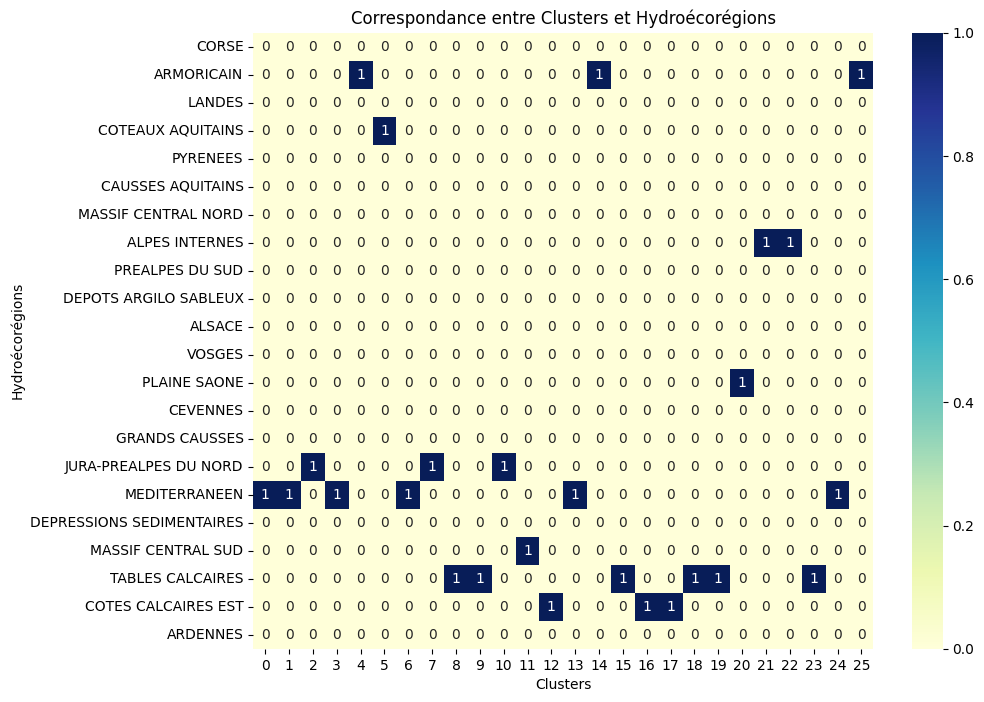

In [170]:
all_hydroecoregions = df_hydroregions['NomHER1'].unique()
cross_tab = pd.crosstab(clusters_hydroregions_with_names['nom_dominant_hydroecoregion_cluster'], clusters_hydroregions_with_names['cluster_dominant_station']).reindex(index=all_hydroecoregions, fill_value=0)
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title("Correspondance entre Clusters et Hydroécorégions")
plt.xlabel("Clusters")
plt.ylabel("Hydroécorégions")
plt.show()


Nous observons que certaines hydroécorégions sont associées à plusieurs clusters, tandis que d'autres ne sont pas représentées dans les résultats du clustering. 

Cela peut s'expliquer par des similarités entre les caractéristiques physicochimiques et hydrobiologiques de stations appartenant à des hydroécorégions différentes, ou par des variations internes importantes au sein d'une même hydroécorégion. 

De plus, nous voyons que parmi les 22 clusters définis, seuls 9 des hydroécorégions sont identifiées dans les données.

Cela peut s'expliquer par le nombre différents de stations par hydroécorégions. Comme vu précédemment, on a plus de données liées aux stations en Mediterranéen, Jura et Tables Calcaires. C'est dans ces régions qu'on situe plusieurs des clusters. 


In [171]:
# Ajouter une colonne qui indique si l'enregistrement a bien été classée
# On vérifie pour chaque ligne si le cluster correspond à l'hydroécorégion dominante
df_analyse_etude['correct_classification'] = df_analyse_etude['hydroecoregion'] == df_analyse_etude['dominant_hydroecoregion_cluster']

In [172]:
num_correctly_classified = df_analyse_etude['correct_classification'].sum()
total_stations = df_analyse_etude.shape[0]
accuracy = num_correctly_classified / total_stations
print(f"Nombre de stations bien classées: {num_correctly_classified}/{total_stations}")
print(f"Taux de classification correcte: {accuracy * 100:.2f}%")

Nombre de stations bien classées: 1091/3139
Taux de classification correcte: 34.76%


#### Quels trimestres présentent le plus de stations bien classées ?

In [173]:
df_analyse_etude['annee_trimestre'] = df_analyse_etude['année'].astype(str) + "-T" + df_analyse_etude['trimestre'].astype(str)

In [174]:
stations_correct = df_analyse_etude[df_analyse_etude['correct_classification']]
stations_correct_count = stations_correct.groupby('annee_trimestre')['station'].nunique().reset_index()
stations_correct_count.columns = ['annee_trimestre', 'stations_correctement_classées']

In [175]:
total_stations_count = df_analyse_etude.groupby('annee_trimestre')['station'].nunique().reset_index()
total_stations_count.columns = ['annee_trimestre', 'stations_totales']

In [176]:
merged_counts = pd.merge(total_stations_count, stations_correct_count, on='annee_trimestre', how='left')
merged_counts['stations_correctement_classées'] = merged_counts['stations_correctement_classées'].fillna(0)  # Remplir les valeurs manquantes par 0
merged_counts['pourcentage_correct'] = (merged_counts['stations_correctement_classées'] / merged_counts['stations_totales']) * 100

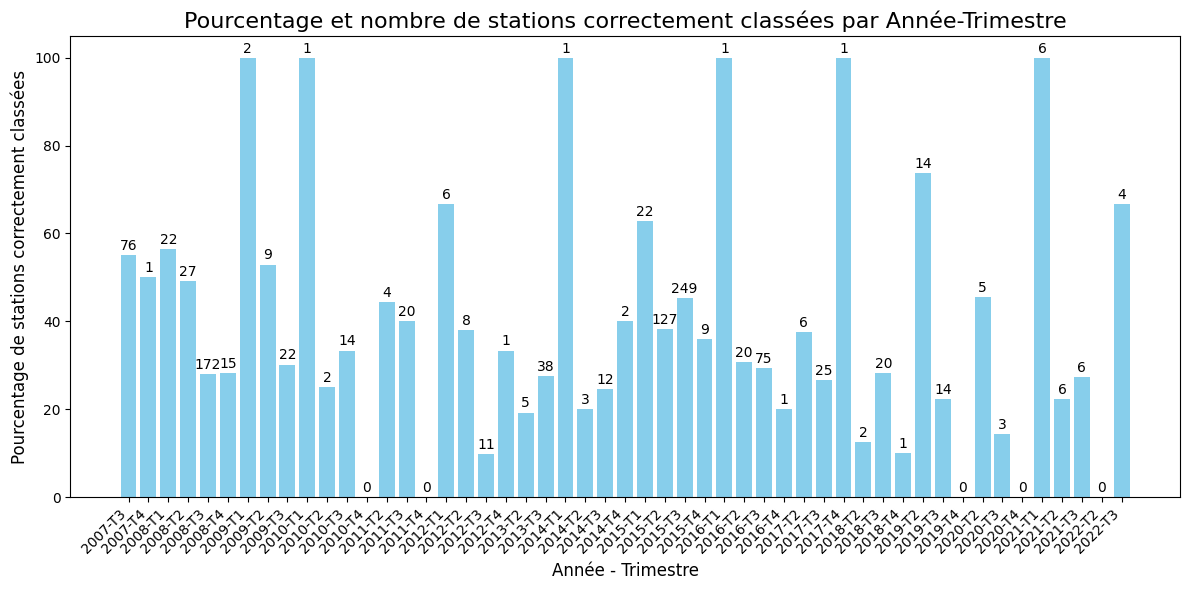

In [177]:
plt.figure(figsize=(12, 6))
bars = plt.bar(merged_counts['annee_trimestre'], merged_counts['pourcentage_correct'], color='skyblue')
[plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{int(text)}', ha='center', va='bottom', fontsize=10) 
for bar, text in zip(bars, merged_counts['stations_correctement_classées'])]
plt.title('Pourcentage et nombre de stations correctement classées par Année-Trimestre', fontsize=16)
plt.xlabel('Année - Trimestre', fontsize=12)
plt.ylabel('Pourcentage de stations correctement classées', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualisation du clustering sur les stations

C:\Users\charl\AppData\Local\Temp\ipykernel_15644\1842718937.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_clusters))


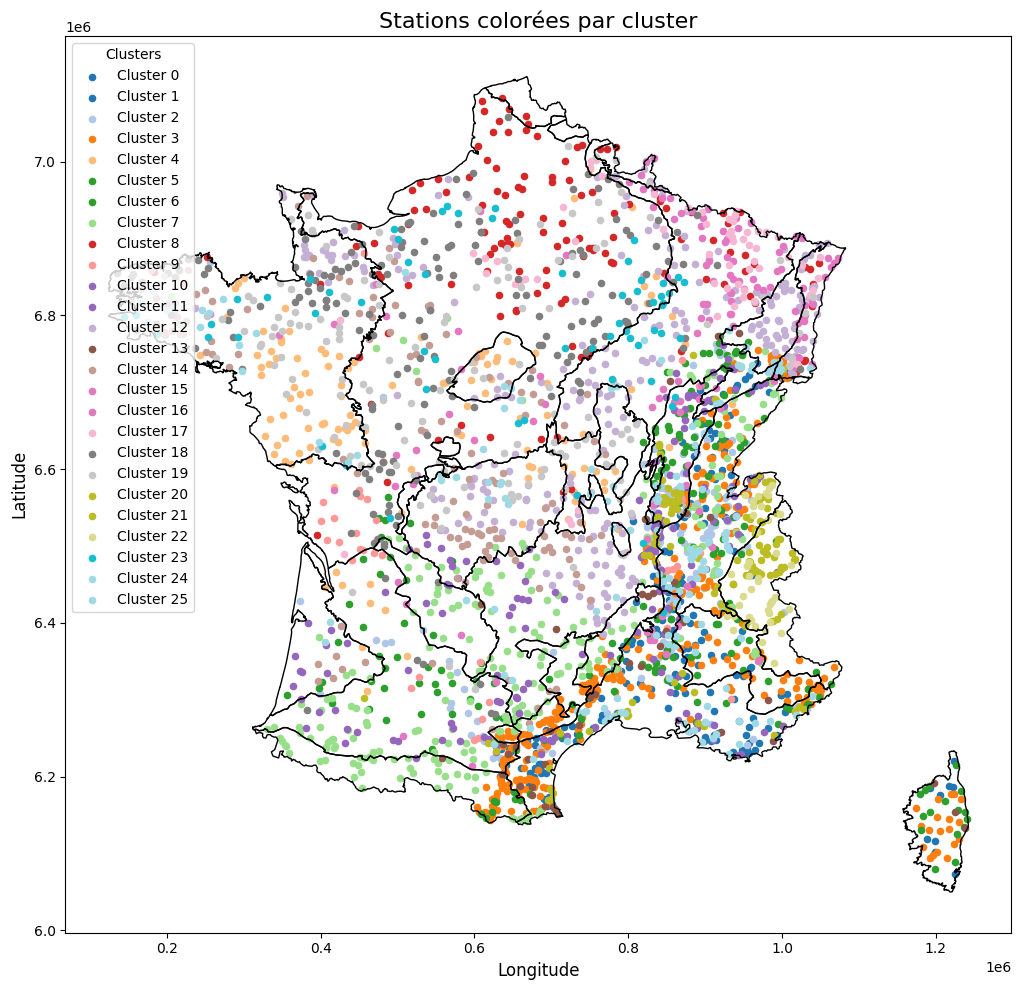

In [178]:
# Représentation des stations avec la couleur de leur cluster dominant
crs_lambert = 'PROJCS["RGF_1993_Lambert_93",GEOGCS["GCS_RGF_1993",DATUM["D_RGF_1993",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",700000.0],PARAMETER["False_Northing",6600000.0],PARAMETER["Central_Meridian",3.0],PARAMETER["Standard_Parallel_1",49.0],PARAMETER["Standard_Parallel_2",44.0],PARAMETER["Latitude_Of_Origin",46.5],UNIT["Meter",1.0]]'
x_col = 'CoordXStationMesureEauxSurface'
y_col = 'CoordYStationMesureEauxSurface'
cluster_col = 'cluster_dominant_station'
carto_i2m2 = gpd.GeoDataFrame(df_analyse_etude, crs=crs_lambert, geometry=gpd.GeoSeries(df_analyse_etude.apply(lambda x: geom.Point(x[x_col], x[y_col]), axis=1)))
HER_lambert = df_hydroregions.to_crs(crs_lambert)
unique_clusters = carto_i2m2[cluster_col].unique()
unique_clusters = sorted(unique_clusters)
cmap = cm.get_cmap('tab20', len(unique_clusters))
cluster_colors = {cluster: mcolors.to_hex(cmap(i)) for i, cluster in enumerate(unique_clusters)}
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
HER_lambert.boundary.plot(ax=ax, color='black', linewidth=1)
for cluster, color in cluster_colors.items():
    cluster_data = carto_i2m2[carto_i2m2[cluster_col] == cluster]
    cluster_data.plot(ax=ax, color=color, markersize=20, label=f"Cluster {cluster}")
ax.legend(loc='upper left', fontsize='medium', title='Clusters')
plt.title('Stations colorées par cluster', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\charl\AppData\Local\Temp\ipykernel_15644\811036617.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_clusters))


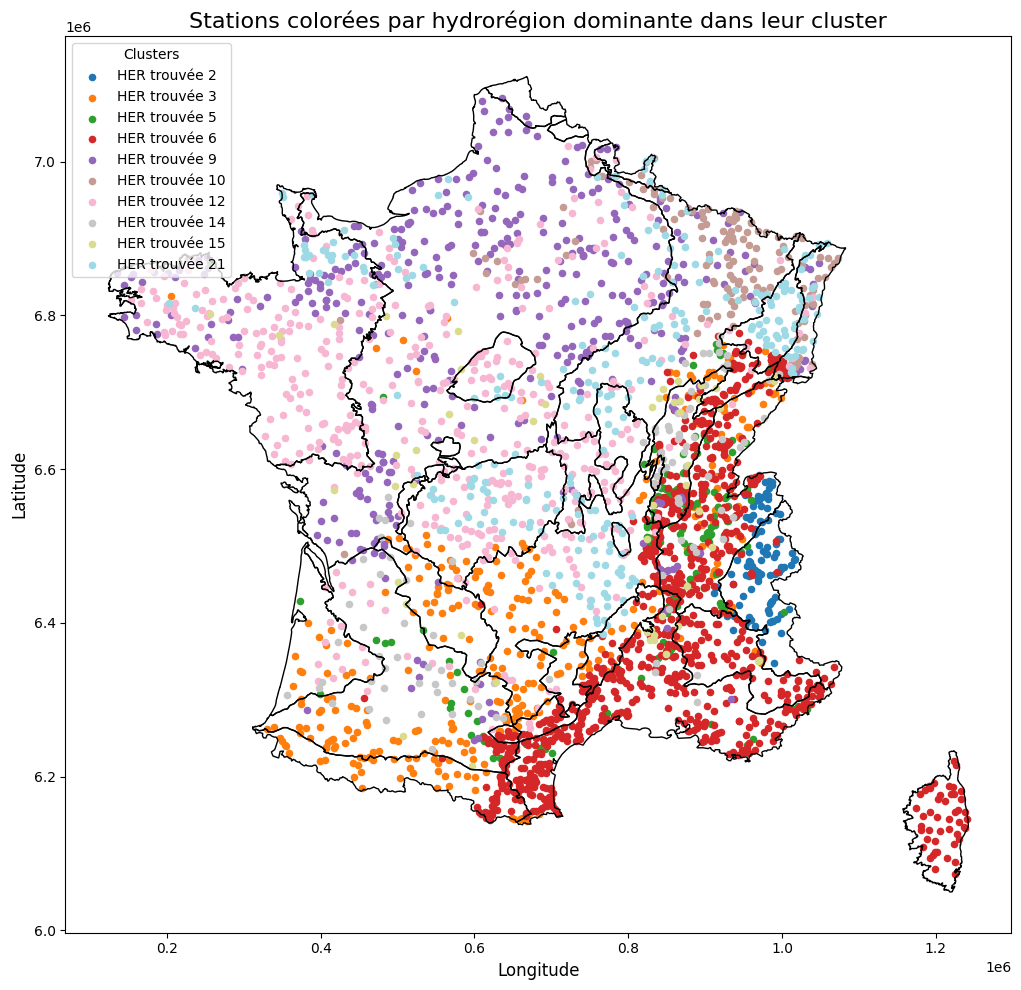

In [180]:
# Représentation des stations avec la couleur de l'hydrorégion dominante dans le cluster
crs_lambert = 'PROJCS["RGF_1993_Lambert_93",GEOGCS["GCS_RGF_1993",DATUM["D_RGF_1993",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",700000.0],PARAMETER["False_Northing",6600000.0],PARAMETER["Central_Meridian",3.0],PARAMETER["Standard_Parallel_1",49.0],PARAMETER["Standard_Parallel_2",44.0],PARAMETER["Latitude_Of_Origin",46.5],UNIT["Meter",1.0]]'
x_col = 'CoordXStationMesureEauxSurface'
y_col = 'CoordYStationMesureEauxSurface'
cluster_col = 'dominant_hydroecoregion_cluster'
carto_i2m2 = gpd.GeoDataFrame(df_analyse_etude, crs=crs_lambert, geometry=gpd.GeoSeries(df_analyse_etude.apply(lambda x: geom.Point(x[x_col], x[y_col]), axis=1)))
HER_lambert = df_hydroregions.to_crs(crs_lambert)
unique_clusters = carto_i2m2[cluster_col].unique()
unique_clusters = sorted(unique_clusters)
cmap = cm.get_cmap('tab20', len(unique_clusters))
cluster_colors = {cluster: mcolors.to_hex(cmap(i)) for i, cluster in enumerate(unique_clusters)}
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
HER_lambert.boundary.plot(ax=ax, color='black', linewidth=1)
for cluster, color in cluster_colors.items():
    cluster_data = carto_i2m2[carto_i2m2[cluster_col] == cluster]
    cluster_data.plot(ax=ax, color=color, markersize=20, label=f"HER trouvée {cluster}")
ax.legend(loc='upper left', fontsize='medium', title='Clusters')
plt.title('Stations colorées par hydrorégion dominante dans leur cluster', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\charl\AppData\Local\Temp\ipykernel_15644\1846449924.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_clusters_correct))


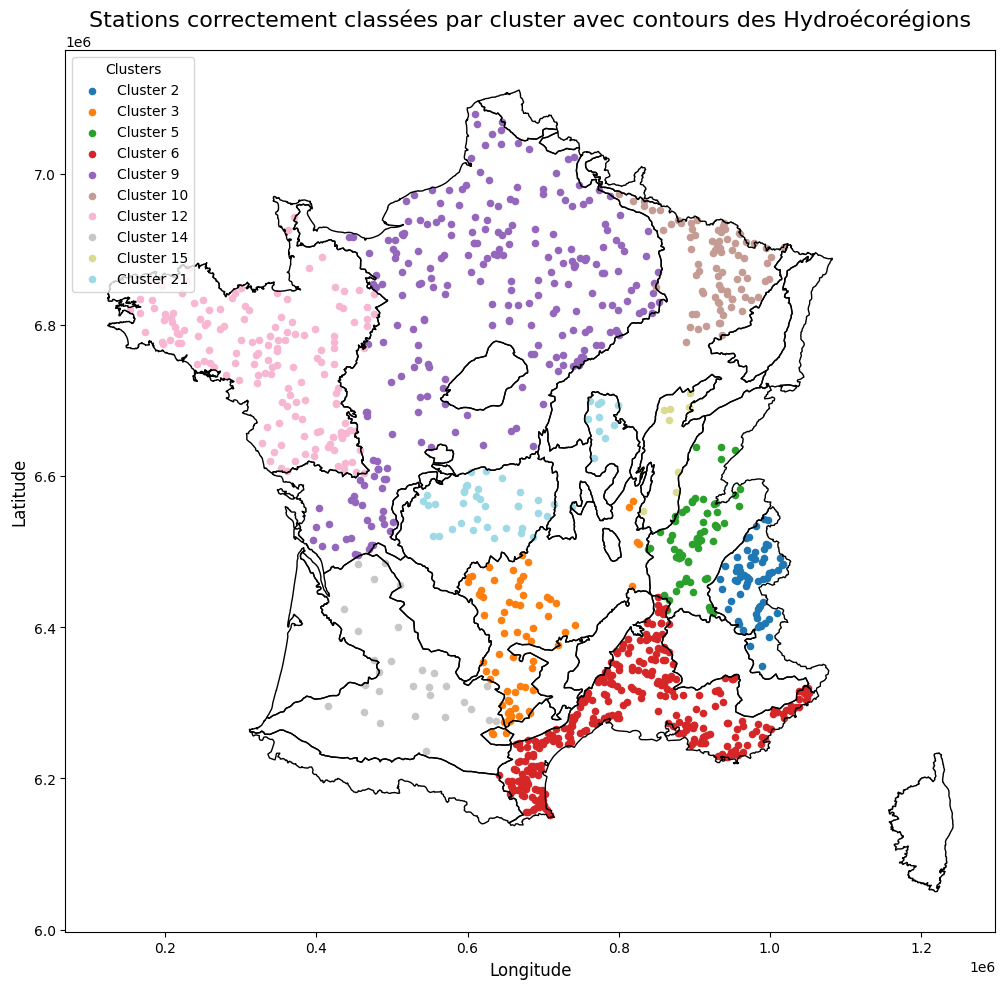

In [181]:
# Représentation des stations bien classées
correct_stations = df_analyse_etude[df_analyse_etude['correct_classification']]
carto_correct_i2m2 = gpd.GeoDataFrame(correct_stations, crs=crs_lambert, 
                                      geometry=gpd.GeoSeries(correct_stations.apply(lambda x: geom.Point(x[x_col], x[y_col]), axis=1)))
HER_lambert = df_hydroregions.to_crs(crs_lambert)
unique_clusters_correct = carto_correct_i2m2[cluster_col].unique()
unique_clusters_correct = sorted(unique_clusters_correct)
cmap = cm.get_cmap('tab20', len(unique_clusters_correct))
cluster_colors_correct = {cluster: mcolors.to_hex(cmap(i)) for i, cluster in enumerate(unique_clusters_correct)}
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
HER_lambert.boundary.plot(ax=ax, color='black', linewidth=1)
for cluster, color in cluster_colors_correct.items():
    cluster_data = carto_correct_i2m2[carto_correct_i2m2[cluster_col] == cluster]
    cluster_data.plot(ax=ax, color=color, markersize=20, label=f"Cluster {cluster}")
ax.legend(loc='upper left', fontsize='medium', title='Clusters')
plt.title('Stations correctement classées par cluster avec contours des Hydroécorégions', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

# Décalage temporel de 6 mois

Après avoir effectué le clustering avec un décalage temporel de 1 mois, les premiers résultats nous ont permis d'évaluer les regroupements de stations en fonction des données physico-chimiques et biologiques. Pour approfondir cette analyse, nous allons explorer un décalage temporel plus important, de 6 mois, afin d'examiner si un lag différent peut améliorer la qualité des clusters, mieux refléter le délai entre les variations physico-chimiques et leurs répercussions biologiques, et enrichir notre compréhension des relations spatio-temporelles entre les données physicochimiques et hydrobiologiques.

In [182]:
df_pc_median_bio_median_6_month = pd.merge(df_pc_pivot_saison_median, df_hydrobio_lag_6_month_median, on=['station', 'année', 'saison'], how='inner')

In [183]:
df_pc_median_bio_median_6_month.shape 

(35275, 20)

In [184]:
# Fusion avec le dataset des stations
df_pc_median_bio_median_6_month_with_coords = pd.merge(
    df_pc_median_bio_median_6_month,
    df_stations[['station', 'CoordXStationMesureEauxSurface', 'CoordYStationMesureEauxSurface']],
    on='station',
    how='inner'
)

In [185]:
df_correl_6 = df_pc_median_bio_median_6_month_with_coords.copy()

In [186]:
# Ajout des hydrorégions pour voir si des caractéristiques y sont corrélées
carto_i2m2_correl_6 = gpd.GeoDataFrame(df_correl_6,crs=crs_lambert, geometry = gpd.GeoSeries(df_correl_6.agg(lambda x:geom.Point(x.loc['CoordXStationMesureEauxSurface'],x.loc['CoordYStationMesureEauxSurface'])  ,axis=1)))
HER_stations_correl_6=carto_i2m2_correl_6.sjoin(df_hydroregions.to_crs(crs_lambert),predicate='within').to_crs(crs_lambert)
df_correl_6 = HER_stations_correl_6.drop(columns=['geometry', 'index_right', 'NomHER1', 'gid'])
df_correl_6['saison'] = df_correl_6['saison'].factorize()[0]
# Mapping des colonnes pour pouvoir afficher la matrice de corrélation correctement
column_mapping = {
    'Ammonium - Eau': 'NH4',
    'Azote Kjeldahl - Eau': 'NKjeldahl',
    'Carbone Organique - Eau': 'CO',
    'Conductivité à 25°C - Eau': 'Cond25',
    'Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau': 'DBO5',
    'Matières en suspension - Eau': 'MES',
    'Nitrates - Eau': 'NO3',
    'Nitrites - Eau': 'NO2',
    'Orthophosphates (PO4) - Eau': 'PO4',
    'Oxygène dissous - Eau': 'O2',
    'Phosphore total - Eau': 'Ptot',
    'Potentiel en Hydrogène (pH) - Eau': 'pH',
    'Taux de saturation en oxygène - Eau': 'O2_sat',
    'Température de l\'Eau - Eau': 'TempEau',
    'Turbidité Formazine Néphélométrique - Eau': 'Turbidité',
    'I2M2': 'I2M2',
    'CoordXStationMesureEauxSurface': 'CoordX',
    'CoordYStationMesureEauxSurface': 'CoordY'
}
df_correl_6 = df_correl_6.rename(columns=column_mapping, index=column_mapping)

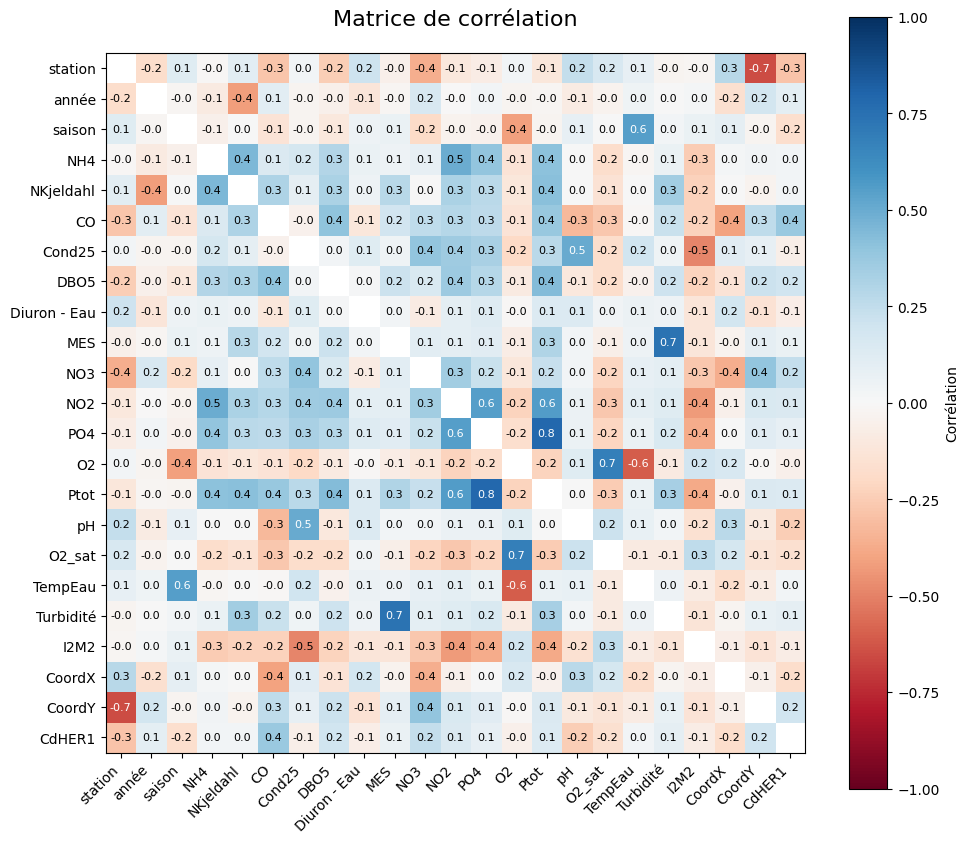

In [187]:
# Matrice de corrélation
correlation_matrix_6 = df_correl_6.corr()
np.fill_diagonal(correlation_matrix_6.values, np.nan)

fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(correlation_matrix_6, cmap='RdBu', vmin=-1, vmax=1)

for (i, j), val in np.ndenumerate(correlation_matrix_6.values):
    if not np.isnan(val):
        ax.text(j, i, f"{val:.1f}", ha='center', va='center', 
                color='white' if abs(val) > 0.5 else 'black', fontsize=8)

ax.set_xticks(np.arange(correlation_matrix_6.shape[1]))
ax.set_yticks(np.arange(correlation_matrix_6.shape[0]))
ax.set_xticklabels(correlation_matrix_6.columns, rotation=45, ha='right')
ax.set_yticklabels(correlation_matrix_6.index)
plt.title("Matrice de corrélation", fontsize=16, pad=20)
fig.colorbar(cax, label="Corrélation", shrink=0.8)
plt.tight_layout()
plt.show()

Les mêmes observations qu'auparavant sont présentes  :
**I2M2** reste négativement corrélé avec Cond25, NO2, PO et Ptot, et ce, malgré le décalage de 6 mois. Cela suggère que ces paramètres sont probablement les principaux facteurs influençant l'état hydrobiologique de l'eau, indépendamment de l'impact des saisons.

## Clustering pour 6 mois de lag

In [188]:
df_pc_median_bio_median_6_month_with_coords.isnull().sum()

station                                                         0
année                                                           0
saison                                                          0
Ammonium - Eau                                               1942
Azote Kjeldahl - Eau                                         2117
Carbone Organique - Eau                                      1602
Conductivité à 25°C - Eau                                     195
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    1843
Diuron - Eau                                                 7569
Matières en suspension - Eau                                  382
Nitrates - Eau                                               1791
Nitrites - Eau                                               1803
Orthophosphates (PO4) - Eau                                  1784
Oxygène dissous - Eau                                         199
Phosphore total - Eau                                        1491
Potentiel 

In [189]:
missing_percentage_6 = df_pc_median_bio_median_6_month_with_coords.isnull().mean() * 100
print(missing_percentage_6)

station                                                       0.000000
année                                                         0.000000
saison                                                        0.000000
Ammonium - Eau                                                9.141835
Azote Kjeldahl - Eau                                          9.965636
Carbone Organique - Eau                                       7.541308
Conductivité à 25°C - Eau                                     0.917949
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau     8.675799
Diuron - Eau                                                 35.630561
Matières en suspension - Eau                                  1.798239
Nitrates - Eau                                                8.431013
Nitrites - Eau                                                8.487502
Orthophosphates (PO4) - Eau                                   8.398061
Oxygène dissous - Eau                                         0.936779
Phosph

In [190]:
# on supprime aussi Diuron - Eau 
df_pc_median_bio_median_6_month_with_coords.drop(columns=['Diuron - Eau'], inplace=True)

In [191]:
# Calculer le nombre de valeurs manquantes par ligne 
missing_values_per_row_6 = df_pc_median_bio_median_6_month_with_coords.isnull().sum(axis=1)
missing_summary_6 = missing_values_per_row_6.value_counts().reset_index()
missing_summary_6.columns = ['Nombre de valeurs manquantes', 'Nombre de lignes']
print(missing_summary_6.sort_values('Nombre de valeurs manquantes'))

    Nombre de valeurs manquantes  Nombre de lignes
0                              0             11844
1                              1              6833
3                              2               552
7                              3               137
9                              4                64
5                              5               204
6                              6               157
8                              7               133
2                              8               903
10                             9                47
4                             10               277
12                            11                34
14                            12                 1
15                            13                 1
11                            14                46
13                            15                10


In [192]:
# Imputation des valeurs manquantes par la médiane
imputer = SimpleImputer(strategy='median') # ici on pourrait aussi mettre mean
colonnes = df_pc_median_bio_median_6_month_with_coords.columns
colonnes = colonnes.drop('station')
colonnes = colonnes.drop('année')
colonnes = colonnes.drop('saison')
colonnes = colonnes.drop('I2M2')
df_pc_median_bio_median_6_month_with_coords[colonnes] = imputer.fit_transform(df_pc_median_bio_median_6_month_with_coords[colonnes])
df_pc_median_bio_median_6_month_with_coords.isnull().sum()

station                                                      0
année                                                        0
saison                                                       0
Ammonium - Eau                                               0
Azote Kjeldahl - Eau                                         0
Carbone Organique - Eau                                      0
Conductivité à 25°C - Eau                                    0
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    0
Matières en suspension - Eau                                 0
Nitrates - Eau                                               0
Nitrites - Eau                                               0
Orthophosphates (PO4) - Eau                                  0
Oxygène dissous - Eau                                        0
Phosphore total - Eau                                        0
Potentiel en Hydrogène (pH) - Eau                            0
Taux de saturation en oxygène - Eau                    

In [193]:
df_pc_median_bio_median_6_month_with_coords_for_regression = df_pc_median_bio_median_6_month_with_coords.copy()

In [194]:
# Mapper chaque saison à un trimestre
saison_to_quarter = {
    "Hiver": 1,
    "Printemps": 2,
    "Été": 3,
    "Automne": 4
}
df_pc_median_bio_median_6_month_with_coords['trimestre'] = df_pc_median_bio_median_6_month_with_coords['saison'].map(saison_to_quarter)
# drop saison
df_pc_median_bio_median_6_month_with_coords.drop(columns=['saison'], inplace=True)
df_pc_median_bio_median_6_month_with_coords.head(5)

station  année  Ammonium - Eau  Azote Kjeldahl - Eau  \
0  5001800   2007            0.04                   1.0   
1  5001800   2008            0.04                   1.0   
2  5001800   2009            0.06                   1.0   
3  5005350   2007            0.12                   1.0   
4  5005350   2008            0.04                   1.0   

   Carbone Organique - Eau  Conductivité à 25°C - Eau  \
0                     6.60                      895.0   
1                     5.50                      803.5   
2                     4.60                      833.5   
3                     1.65                      593.0   
4                     1.50                      632.5   

   Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau  \
0                                               0.50           
1                                               0.65           
2                                               0.50           
3                                               0.90           
4                                               1.60           

   Matières en suspension - Eau  Nitrates - Eau  Nitrites - Eau  ...  \
0                          11.0           45.60           0.070  ...   
1                           7.5           39.25           0.070  ...   
2                          10.0           41.20           0.060  ...   
3                          15.0           45.40           0.135  ...   
4                          21.0           44.40           0.050  ...   

   Oxygène dissous - Eau  Phosphore total - Eau  \
0                  11.05                   0.05   
1                   9.15                   0.05   
2                  10.70                   0.06   
3                   8.30                   0.16   
4                  10.35                   0.13   

   Potentiel en Hydrogène (pH) - Eau  Taux de saturation en oxygène - Eau  \
0                               7.75                                100.5   
1                               7.85                                 90.0   
2                               7.95                                 91.5   
3                               7.90                                 80.0   
4                               8.00                                 95.0   

   Température de l'Eau - Eau  Turbidité Formazine Néphélométrique - Eau  \
0                       11.35                                        5.0   
1                       12.85                                        5.0   
2                        8.25                                        5.0   
3                       11.80                                        5.0   
4                       10.70                                        5.0   

     I2M2  CoordXStationMesureEauxSurface  CoordYStationMesureEauxSurface  \
0  0.3004                        399856.0                       6531980.0   
1  0.3848                        399856.0                       6531980.0   
2  0.5756                        399856.0                       6531980.0   
3  0.4851                        450151.0                       6572920.0   
4  0.3488                        450151.0                       6572920.0   

   trimestre  
0          1  
1          2  
2          1  
3          2  
4          1  

[5 rows x 21 columns]

In [195]:
# Convertir l'identifiant de station en variable catégorielle (cela crée un encodage numérique)
df_pc_median_bio_median_6_month_with_coords['station'] = df_pc_median_bio_median_6_month_with_coords['station'].astype(str)
df_pc_median_bio_median_6_month_with_coords['trimestre'] = df_pc_median_bio_median_6_month_with_coords['trimestre'].astype(int)
df_pc_median_bio_median_6_month_with_coords['année'] = df_pc_median_bio_median_6_month_with_coords['année'].astype(int)
df_pc_median_bio_median_6_month_with_coords.dtypes

station                                                       object
année                                                          int64
Ammonium - Eau                                               float64
Azote Kjeldahl - Eau                                         float64
Carbone Organique - Eau                                      float64
Conductivité à 25°C - Eau                                    float64
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    float64
Matières en suspension - Eau                                 float64
Nitrates - Eau                                               float64
Nitrites - Eau                                               float64
Orthophosphates (PO4) - Eau                                  float64
Oxygène dissous - Eau                                        float64
Phosphore total - Eau                                        float64
Potentiel en Hydrogène (pH) - Eau                            float64
Taux de saturation en oxygène - Ea

In [196]:
# drop les coordonnées
df_pc_median_bio_median_6_month_c = df_pc_median_bio_median_6_month_with_coords.copy()
df_pc_median_bio_median_6_month_c = df_pc_median_bio_median_6_month_with_coords.drop(columns=['CoordXStationMesureEauxSurface', 'CoordYStationMesureEauxSurface'])
df_clustering_6 = df_pc_median_bio_median_6_month_c.copy()

In [197]:
# Encodage des stations
le = LabelEncoder()
df_clustering_6['station_encoded'] = le.fit_transform(df_clustering_6['station'])
df_clustering_6.drop(columns=['station'], inplace=True)
# Normalisation des données pour qu'elles aient toutes la même importance
scaler = MinMaxScaler()
normalized_data_6 = scaler.fit_transform(df_clustering_6)
normalized_data_6 = pd.DataFrame(normalized_data_6, columns=df_clustering_6.columns)

On teste ici directement avec 22 clusters, qui est le nombre d'hydroécorégions.

In [198]:
kmeans = KMeans(n_clusters=22, random_state=42)
kmeans.fit(normalized_data_6)

KMeans(n_clusters=22, random_state=42)

In [199]:
# Analyse des centres des clusters
cluster_centers_6 = pd.DataFrame(kmeans.cluster_centers_, columns=df_clustering_6.columns)
print("Centres des clusters :")
print(cluster_centers_6)
# Variabilité des caractéristiques par cluster
influence_6 = cluster_centers_6.std(axis=0)
print("\nInfluence des caractéristiques :")
print(influence_6.sort_values(ascending=False))

Centres des clusters :
       année  Ammonium - Eau  Azote Kjeldahl - Eau  Carbone Organique - Eau  \
0   0.698467        0.003703              0.103479                 0.090523   
1   0.328105        0.015226              0.141999                 0.165752   
2   0.485039        0.153096              0.295034                 0.259995   
3   0.726435        0.006011              0.106410                 0.155199   
4   0.295109        0.009563              0.167491                 0.111694   
5   0.728114        0.003733              0.102967                 0.053176   
6   0.765597        0.007173              0.108304                 0.156238   
7   0.565142        0.007076              0.108252                 0.128290   
8   0.622577        0.016792              0.143201                 0.164365   
9   0.225716        0.010606              0.196300                 0.060238   
10  0.718125        0.026329              0.130423                 0.197367   
11  0.797656        0.008145 

Après les paramètres de spatio-temporalité, les caractéristiques les plus influentes sont :

- I2M2
- Nitrates
- Conductivité à 25°C
- Carbone Organique
- Température de l'eau

Ces paramètres suggèrent des indicateurs clés de l'état de l'eau, permettant ainsi de détecter les hydroécorégions.

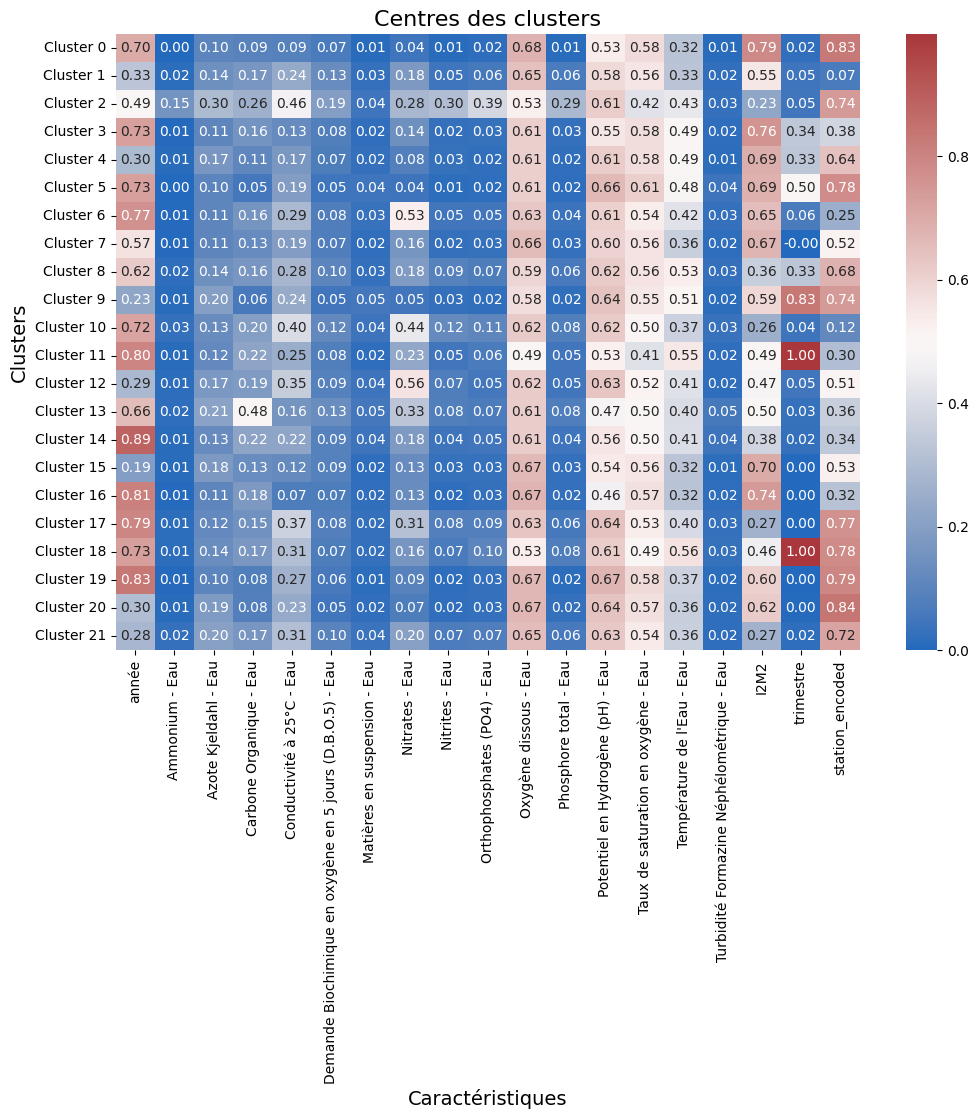

In [200]:
# Matrice des centres des clusters
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centers_6, annot=True, fmt=".2f", cmap="vlag", xticklabels=df_clustering_6.columns, yticklabels=[f'Cluster {i}' for i in range(len(cluster_centers_6))])
plt.title("Centres des clusters", fontsize=16)
plt.xlabel("Caractéristiques", fontsize=14)
plt.ylabel("Clusters", fontsize=14)
plt.show()

In [201]:
df_pc_median_bio_median_6_month_with_clusters = df_pc_median_bio_median_6_month_c.copy()
df_pc_median_bio_median_6_month_with_clusters['cluster'] = kmeans.labels_

In [202]:
# Calcul du score de silhouette
score_6 = silhouette_score(normalized_data_6, df_pc_median_bio_median_6_month_with_clusters['cluster'])
print(f"Silhouette score: {score_6}")

Silhouette score: 0.1370000820490834


In [203]:
# Recherche du meilleur nombre de clusters selon le score de silhouette
silhouette_scores_6 = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data_6)
    score = silhouette_score(normalized_data_6, cluster_labels)
    silhouette_scores_6.append(score)
best_k_6 = k_values[silhouette_scores_6.index(max(silhouette_scores_6))]
print(f"Le meilleur nombre de clusters est : {best_k_6}")

Le meilleur nombre de clusters est : 22


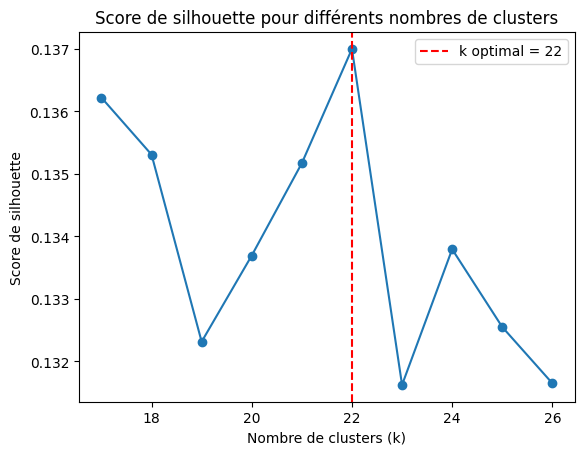

In [204]:
plt.plot(k_values, silhouette_scores_6, marker='o')
plt.title("Score de silhouette pour différents nombres de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score de silhouette")
plt.axvline(x=best_k_6, color='r', linestyle='--', label=f"k optimal = {best_k_6}")
plt.legend()
plt.show()

Cette fois ci, le meilleur score de silhouette est exactement le nombre d'hydroécorégions.

In [205]:
cluster_distribution = df_pc_median_bio_median_6_month_with_clusters.groupby('station')['cluster'].value_counts(normalize=True).unstack().fillna(0) * 100
print(cluster_distribution)
stations_100_percent = cluster_distribution[cluster_distribution.eq(100.0).sum(axis=1) == 1]
print("Stations à 100% dans un seul cluster :", end=' ')
print(stations_100_percent.shape[0])
print("Pourcentage de stations 100% dans le même cluster : ", round(stations_100_percent.shape[0] / df_pc_median_bio_median_6_month_with_clusters['station'].nunique() * 100,2), "%")

cluster   0          1          2          3    4          5          6    7   \
station                                                                         
1000477  0.0   0.000000   0.000000   0.000000  0.0   0.000000  14.285714  0.0   
1000602  0.0   0.000000   0.000000   0.000000  0.0   0.000000   0.000000  0.0   
1000605  0.0   0.000000   0.000000  16.666667  0.0   0.000000  50.000000  0.0   
1001122  0.0  28.571429   0.000000   0.000000  0.0   0.000000  14.285714  0.0   
1001131  0.0  28.571429   0.000000   0.000000  0.0   0.000000   0.000000  0.0   
...      ...        ...        ...        ...  ...        ...        ...  ...   
6999125  0.0   0.000000  16.666667   0.000000  0.0   0.000000   0.000000  0.0   
6999137  0.0   0.000000   0.000000   0.000000  0.0  16.666667   0.000000  0.0   
6999153  0.0   0.000000   0.000000   0.000000  0.0   0.000000   0.000000  0.0   
6999176  0.0   0.000000   0.000000   0.000000  0.0   0.000000   0.000000  0.0   
6999178  0.0   0.000000   0.

In [206]:
df_pc_median_bio_median_6_month_with_clusters_with_coord = df_pc_median_bio_median_6_month_with_coords.copy()
df_pc_median_bio_median_6_month_with_clusters_with_coord['cluster'] = kmeans.labels_
# Attribution du cluster dominant à chaque station
station_cluster_counts = df_pc_median_bio_median_6_month_with_clusters_with_coord.groupby(['station', 'cluster']).size().reset_index(name='count')
dominant_cluster_per_station = station_cluster_counts.loc[station_cluster_counts.groupby('station')['count'].idxmax()]
df_pc_median_bio_median_6_month_with_clusters_with_coord = df_pc_median_bio_median_6_month_with_clusters_with_coord.merge(dominant_cluster_per_station[['station', 'cluster']], on='station', how='left', suffixes=('', '_dominant'))
df_pc_median_bio_median_6_month_with_clusters_with_coord.rename(columns={'cluster_dominant': 'cluster_dominant_station'}, inplace=True)
df_analyse_6 = df_pc_median_bio_median_6_month_with_clusters_with_coord[['station', 'année', 'CoordXStationMesureEauxSurface', 'CoordYStationMesureEauxSurface', 'trimestre', 'cluster_dominant_station']].copy()

In [207]:
carto_correct_i2m2_6 = gpd.GeoDataFrame(df_analyse_6, crs=crs_lambert,
                                        geometry=gpd.GeoSeries(df_analyse_6.agg(lambda x: geom.Point(x.loc['CoordXStationMesureEauxSurface'], x.loc['CoordYStationMesureEauxSurface']), axis=1)))
HER_stations_correct_6 = carto_correct_i2m2_6.sjoin(df_hydroregions.to_crs(crs_lambert), predicate='within').to_crs(crs_lambert)
df_analyse_etude_6 = HER_stations_correct_6.drop(columns=['geometry', 'index_right', 'gid'])
df_analyse_etude_6.rename(columns={'CdHER1': 'hydroecoregion'}, inplace=True)
# hydroécorégion dominante par cluster
dominant_class_per_cluster_6 = df_analyse_etude_6.groupby('cluster_dominant_station')['hydroecoregion'].agg(lambda x: x.mode()[0]).reset_index()
dominant_class_per_cluster_6.columns = ['cluster_dominant_station', 'dominant_hydroecoregion_cluster']
df_analyse_etude_6 = df_analyse_etude_6.merge(dominant_class_per_cluster_6, on='cluster_dominant_station', how='left')
df_analyse_etude_6.drop_duplicates(subset='station', inplace=True)

In [208]:
# association cluster - hydroécorégion
clusters_hydroregions_6 = df_analyse_etude_6.groupby('cluster_dominant_station')['hydroecoregion'].apply(lambda x: x.mode()[0]).reset_index()
clusters_hydroregions_6.columns = ['cluster_dominant_station', 'dominant_hydroecoregion_cluster']
clusters_hydroregions_6['dominant_hydroecoregion_cluster'] = clusters_hydroregions_6['dominant_hydroecoregion_cluster'].astype(str)
df_hydroregions['CdHER1'] = df_hydroregions['CdHER1'].astype(str)
clusters_hydroregions_with_names_6 = clusters_hydroregions_6.merge(df_hydroregions[['CdHER1', 'NomHER1']], left_on='dominant_hydroecoregion_cluster', right_on='CdHER1', how='left')
clusters_hydroregions_with_names_6 = clusters_hydroregions_with_names_6.rename(columns={'NomHER1': 'nom_dominant_hydroecoregion_cluster'})
print(clusters_hydroregions_with_names_6[['cluster_dominant_station', 'dominant_hydroecoregion_cluster', 'nom_dominant_hydroecoregion_cluster']])

    cluster_dominant_station dominant_hydroecoregion_cluster  \
0                          0                              16   
1                          1                              10   
2                          2                              14   
3                          3                              21   
4                          4                               5   
5                          5                               2   
6                          6                               9   
7                          7                              21   
8                          8                               5   
9                          9                               6   
10                        10                               9   
11                        11                              12   
12                        12                               1   
13                        13                              12   
14                        14            

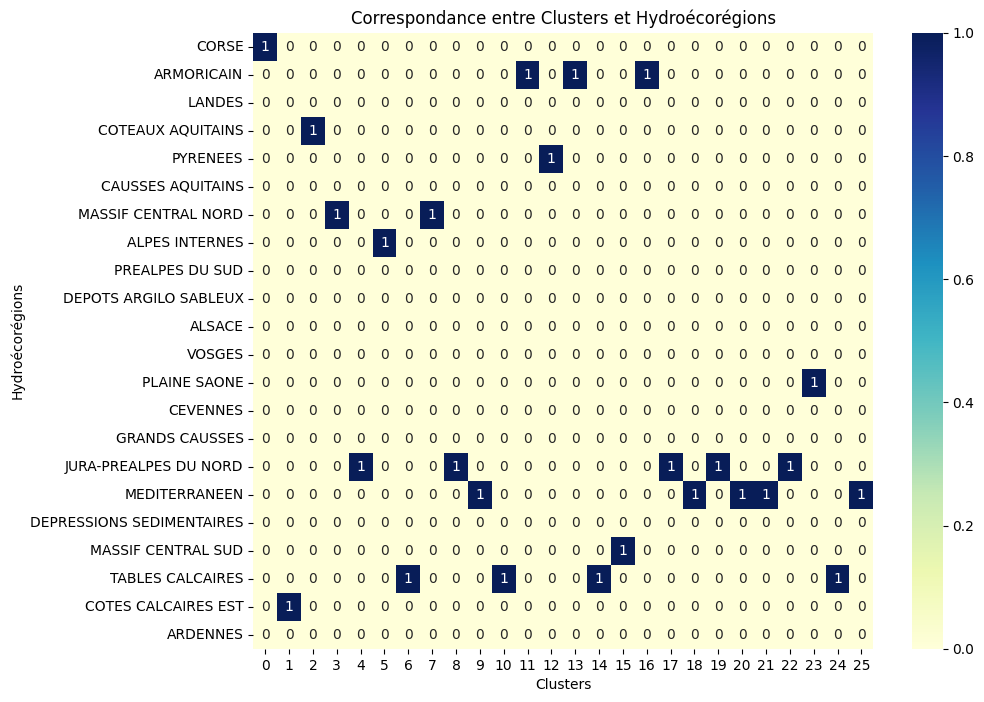

In [209]:
all_hydroecoregions = df_hydroregions['NomHER1'].unique()
cross_tab_6 = pd.crosstab(clusters_hydroregions_with_names_6['nom_dominant_hydroecoregion_cluster'], clusters_hydroregions_with_names_6['cluster_dominant_station']).reindex(index=all_hydroecoregions, fill_value=0)
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab_6, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title("Correspondance entre Clusters et Hydroécorégions")
plt.xlabel("Clusters")
plt.ylabel("Hydroécorégions")
plt.show()

Cette fois ci 12 hydroécorégions sont indentifiés.

Comme pour le clustering avec décalage temporel d'1 mois, on observe des hydroécorégions associés à plusieurs clusters, et les mêmes que pou le précédent clustering, notamment l'hydroécorégion méditeranéen.

In [210]:
df_analyse_etude_6['correct_classification'] = df_analyse_etude_6['hydroecoregion'] == df_analyse_etude_6['dominant_hydroecoregion_cluster']
num_correctly_classified_6 = df_analyse_etude_6['correct_classification'].sum()
total_stations_6 = df_analyse_etude_6.shape[0]
accuracy_6 = num_correctly_classified_6 / total_stations_6
print(f"Nombre de stations bien classées: {num_correctly_classified_6}/{total_stations_6}")
print(f"Taux de classification correcte: {accuracy_6 * 100:.2f}%")

Nombre de stations bien classées: 1071/2836
Taux de classification correcte: 37.76%


On a 3% de stations mieux classés qu'avec le lag d'1 mois.

C:\Users\charl\AppData\Local\Temp\ipykernel_15644\3498149462.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_clusters_correct_6))


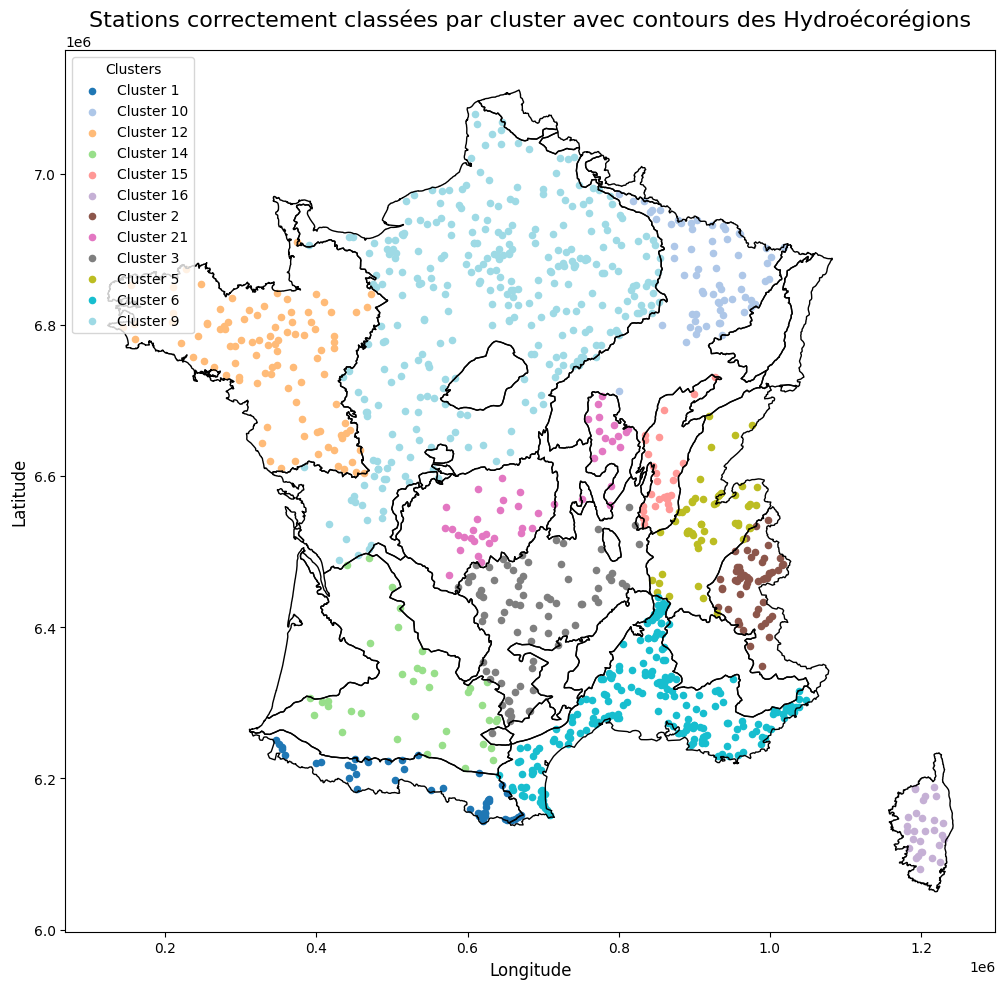

In [211]:
# Représentation des stations bien classés
correct_stations_6 = df_analyse_etude_6[df_analyse_etude_6['correct_classification']]
carto_correct_i2m2_6 = gpd.GeoDataFrame(correct_stations_6, crs=crs_lambert,
                                        geometry=gpd.GeoSeries(correct_stations_6.apply(lambda x: geom.Point(x[x_col], x[y_col]), axis=1)))
HER_lambert = df_hydroregions.to_crs(crs_lambert)
unique_clusters_correct_6 = carto_correct_i2m2_6[cluster_col].unique()
unique_clusters_correct_6 = sorted(unique_clusters_correct_6)
cmap = cm.get_cmap('tab20', len(unique_clusters_correct_6))
cluster_colors_correct_6 = {cluster: mcolors.to_hex(cmap(i)) for i, cluster in enumerate(unique_clusters_correct_6)}
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
HER_lambert.boundary.plot(ax=ax, color='black', linewidth=1)
for cluster, color in cluster_colors_correct_6.items():
    cluster_data = carto_correct_i2m2_6[carto_correct_i2m2_6[cluster_col] == cluster]
    cluster_data.plot(ax=ax, color=color, markersize=20, label=f"Cluster {cluster}")
ax.legend(loc='upper left', fontsize='medium', title='Clusters')
plt.title('Stations correctement classées par cluster avec contours des Hydroécorégions', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

On observe que dans les deux clusterings, certaines régions sont plus facilement identifiables, notamment à l'ouest, dans la région de Lyon, autour de la Méditerranée, et dans le nord de la Lorraine. La Corse n'est détectée qu'avec le lag de 6 mois, tout comme la région au sud-ouest.

Les zones couvertes avec le lag de 6 mois montrent une amélioration de la précision dans la détection des hydroécorégions. En effet, le lag de 6 mois semble plus pertinent que celui de 1 mois pour étudier l'impact de I2M2 dans la caractérisation des hydroécorégions. Nous espérons également que cette amélioration se reflète dans la régression qui sera réalisée par la suite, en posant l'hypothèse que 6 mois offre une meilleure base pour l'analyse.


--- 

# Régression : prédiction de I2M2

Dans cette section, nous explorons la possibilité de prédire l'état biologique de l'eau, représenté par l'indice I2M2, à partir des paramètres physico-chimiques, des informations spatiales (hydroécorégions) et de la dimension temporelle (saisons et années).  

En particulier, nous utilisons un lag de 6 mois pour les paramètres physico-chimiques, car les résultats du clustering précédemment réalisés avec cette configuration se sont révélés légèrement meilleurs. Cela nous conduit à supposer qu'un décalage temporel de 6 mois reflète plus fidèlement une relation sous-jacente entre les propriétés physico-chimiques et biologiques de l'eau qu'un lag d'1 mois.  

Ainsi, en réutilisant les données préalablement préparées et enrichies avec l'identifiant des hydroécorégions, nous construisons un modèle de régression pour évaluer dans quelle mesure ces variables permettent de prédire efficacement I2M2. Cette démarche vise à approfondir notre compréhension des interactions entre les propriétés physico-chimiques et biologiques, tout en testant la pertinence de ces paramètres comme facteurs explicatifs de l'état des écosystèmes aquatiques.


In [212]:
df_pc_median_bio_median_6_month_with_coords
df_for_regression = df_pc_median_bio_median_6_month_with_coords.copy()

In [213]:
# Pour rappel :
df_for_regression

station  année  Ammonium - Eau  Azote Kjeldahl - Eau  \
0      5001800   2007           0.040                   1.0   
1      5001800   2008           0.040                   1.0   
2      5001800   2009           0.060                   1.0   
3      5005350   2007           0.120                   1.0   
4      5005350   2008           0.040                   1.0   
...        ...    ...             ...                   ...   
21238  6453450   2022           0.010                   0.5   
21239  6446401   2021           0.025                   0.5   
21240  6446401   2022           0.020                   0.5   
21241  6446330   2021           0.020                   0.5   
21242  6446330   2022           0.010                   0.5   

       Carbone Organique - Eau  Conductivité à 25°C - Eau  \
0                         6.60                      895.0   
1                         5.50                      803.5   
2                         4.60                      833.5   
3                         1.65                      593.0   
4                         1.50                      632.5   
...                        ...                        ...   
21238                     2.25                      456.0   
21239                     1.50                      503.0   
21240                     2.50                      463.0   
21241                     1.30                      529.5   
21242                     1.60                      541.0   

       Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau  \
0                                                   0.50           
1                                                   0.65           
2                                                   0.50           
3                                                   0.90           
4                                                   1.60           
...                                                  ...           
21238                                               0.60           
21239                                               0.55           
21240                                               1.40           
21241                                               0.60           
21242                                               0.90           

       Matières en suspension - Eau  Nitrates - Eau  Nitrites - Eau  ...  \
0                             11.00           45.60           0.070  ...   
1                              7.50           39.25           0.070  ...   
2                             10.00           41.20           0.060  ...   
3                             15.00           45.40           0.135  ...   
4                             21.00           44.40           0.050  ...   
...                             ...             ...             ...  ...   
21238                         29.50           10.40           0.010  ...   
21239                          9.65           16.50           0.030  ...   
21240                         24.00           12.00           0.010  ...   
21241                         13.60           11.25           0.040  ...   
21242                          9.10            9.20           0.010  ...   

       Oxygène dissous - Eau  Phosphore total - Eau  \
0                      11.05                 0.0500   
1                       9.15                 0.0500   
2                      10.70                 0.0600   
3                       8.30                 0.1600   
4                      10.35                 0.1300   
...                      ...                    ...   
21238                  11.35                 0.0545   
21239                  10.85                 0.0360   
21240                  11.00                 0.0670   
21241                  11.05                 0.0335   
21242                  11.10                 0.0300   

       Potentiel en Hydrogène (pH) - Eau  Taux de saturation en oxygène - Eau  \
0                                   7.75     

In [214]:
# Ajouter le Code HER1
test= df_for_regression.copy()
carto_her = gpd.GeoDataFrame(test, crs=crs_lambert, geometry=gpd.GeoSeries(test.agg(lambda x: geom.Point(x.loc['CoordXStationMesureEauxSurface'], x.loc['CoordYStationMesureEauxSurface']), axis=1)))
HER_stations_her = carto_her.sjoin(df_hydroregions.to_crs(crs_lambert), predicate='within').to_crs(crs_lambert)
test = HER_stations_her.drop(columns=['geometry', 'index_right', 'gid', 'NomHER1'])
test.rename(columns={'CdHER1': 'hydroecoregion'}, inplace=True)
test.head(5)

station  année  Ammonium - Eau  Azote Kjeldahl - Eau  \
0  5001800   2007            0.04                   1.0   
1  5001800   2008            0.04                   1.0   
2  5001800   2009            0.06                   1.0   
3  5005350   2007            0.12                   1.0   
4  5005350   2008            0.04                   1.0   

   Carbone Organique - Eau  Conductivité à 25°C - Eau  \
0                     6.60                      895.0   
1                     5.50                      803.5   
2                     4.60                      833.5   
3                     1.65                      593.0   
4                     1.50                      632.5   

   Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau  \
0                                               0.50           
1                                               0.65           
2                                               0.50           
3                                               0.90           
4                                               1.60           

   Matières en suspension - Eau  Nitrates - Eau  Nitrites - Eau  ...  \
0                          11.0           45.60           0.070  ...   
1                           7.5           39.25           0.070  ...   
2                          10.0           41.20           0.060  ...   
3                          15.0           45.40           0.135  ...   
4                          21.0           44.40           0.050  ...   

   Phosphore total - Eau  Potentiel en Hydrogène (pH) - Eau  \
0                   0.05                               7.75   
1                   0.05                               7.85   
2                   0.06                               7.95   
3                   0.16                               7.90   
4                   0.13                               8.00   

   Taux de saturation en oxygène - Eau  Température de l'Eau - Eau  \
0                                100.5                       11.35   
1                                 90.0                       12.85   
2                                 91.5                        8.25   
3                                 80.0                       11.80   
4                                 95.0                       10.70   

   Turbidité Formazine Néphélométrique - Eau    I2M2  \
0                                        5.0  0.3004   
1                                        5.0  0.3848   
2                                        5.0  0.5756   
3                                        5.0  0.4851   
4                                        5.0  0.3488   

   CoordXStationMesureEauxSurface  CoordYStationMesureEauxSurface  trimestre  \
0                        399856.0                       6531980.0          1   
1                        399856.0                       6531980.0          2   
2                        399856.0                       6531980.0          1   
3                        450151.0                       6572920.0          2   
4                        450151.0                       6572920.0          1   

   hydroecoregion  
0               9  
1               9  
2               9  
3               9  
4               9  

[5 rows x 22 columns]

In [215]:
# drop les coordonnées
df_for_regression = test.copy()
df_for_regression.drop(columns=['CoordXStationMesureEauxSurface', 'CoordYStationMesureEauxSurface'], inplace=True)
df_for_regression.head(5)

station  année  Ammonium - Eau  Azote Kjeldahl - Eau  \
0  5001800   2007            0.04                   1.0   
1  5001800   2008            0.04                   1.0   
2  5001800   2009            0.06                   1.0   
3  5005350   2007            0.12                   1.0   
4  5005350   2008            0.04                   1.0   

   Carbone Organique - Eau  Conductivité à 25°C - Eau  \
0                     6.60                      895.0   
1                     5.50                      803.5   
2                     4.60                      833.5   
3                     1.65                      593.0   
4                     1.50                      632.5   

   Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau  \
0                                               0.50           
1                                               0.65           
2                                               0.50           
3                                               0.90           
4                                               1.60           

   Matières en suspension - Eau  Nitrates - Eau  Nitrites - Eau  \
0                          11.0           45.60           0.070   
1                           7.5           39.25           0.070   
2                          10.0           41.20           0.060   
3                          15.0           45.40           0.135   
4                          21.0           44.40           0.050   

   Orthophosphates (PO4) - Eau  Oxygène dissous - Eau  Phosphore total - Eau  \
0                        0.050                  11.05                   0.05   
1                        0.050                   9.15                   0.05   
2                        0.050                  10.70                   0.06   
3                        0.245                   8.30                   0.16   
4                        0.170                  10.35                   0.13   

   Potentiel en Hydrogène (pH) - Eau  Taux de saturation en oxygène - Eau  \
0                               7.75                                100.5   
1                               7.85                                 90.0   
2                               7.95                                 91.5   
3                               7.90                                 80.0   
4                               8.00                                 95.0   

   Température de l'Eau - Eau  Turbidité Formazine Néphélométrique - Eau  \
0                       11.35                                        5.0   
1                       12.85                                        5.0   
2                        8.25                                        5.0   
3                       11.80                                        5.0   
4                       10.70                                        5.0   

     I2M2  trimestre hydroecoregion  
0  0.3004          1              9  
1  0.3848          2              9  
2  0.5756          1              9  
3  0.4851          2              9  
4  0.3488          1              9

In [216]:
# valueur min et max de I2M2 : vérifier que c'est bien 0 et 1 
print(df_for_regression['I2M2'].min())
print(df_for_regression['I2M2'].max())

0.0
1.0


In [217]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# Encodage des stations
le = LabelEncoder()
df_for_regression['station_encoded'] = le.fit_transform(df_for_regression['station'])
df_for_regression["hydroecoregion_encoded"] = le.fit_transform(df_for_regression["hydroecoregion"])
df_for_regression.drop(columns=['station', 'hydroecoregion'], inplace=True)
# Normalisation des données pour qu'elles aient toutes la même importance
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_for_regression)
normalized_data = pd.DataFrame(normalized_data, columns=df_for_regression.columns)
# df_for_regression = pd.concat([df_for_regression[['station_encoded', 'hydroecoregion_encoded']], normalized_data], axis=1)

In [218]:
from sklearn.model_selection import train_test_split
X = normalized_data.drop(columns=['I2M2'])
y = normalized_data['I2M2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [219]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
model = LinearRegression()
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = -cv_scores.mean()
print(f"Mean CV score: {mean_cv_score}")

Mean CV score: 0.03133060488047302


Le fait que y soit compris entre 0 et 1 est à prendre en compte. 

Un score moyen de validation croisée (Mean CV score) dans une régression représente l'erreur quadratique moyenne (MSE) qui mesure la différence entre les valeurs réelles et les valeurs prédites par le modèle. Le MSE est exprimé dans les mêmes unités que la variable cible. 

Puisque la plage de 
y est de 0 à 1, un MSE de 0.03 signifie que, en moyenne, l'écart quadratique entre les valeurs réelles et prédites est de 0.03, ce qui est relativement faible par rapport à l'échelle totale (0 à 1, soit 3%).

In [220]:
model.fit(X_train, y_train)
coefficiens = model.coef_
features = X_train.columns
coef_df = pd.DataFrame(coefficiens, index=features, columns=['Coefficient'])
coef_df = coef_df.sort_values('Coefficient', ascending=False)
print(coef_df)

                                                    Coefficient
Taux de saturation en oxygène - Eau                    0.216832
Potentiel en Hydrogène (pH) - Eau                      0.064725
trimestre                                              0.027391
Température de l'Eau - Eau                             0.007042
année                                                 -0.005469
hydroecoregion_encoded                                -0.008531
Nitrates - Eau                                        -0.013270
Oxygène dissous - Eau                                 -0.015859
Azote Kjeldahl - Eau                                  -0.039886
Turbidité Formazine Néphélométrique - Eau             -0.063309
Matières en suspension - Eau                          -0.078234
station_encoded                                       -0.089366
Ammonium - Eau                                        -0.100480
Orthophosphates (PO4) - Eau                           -0.108816
Phosphore total - Eau                   

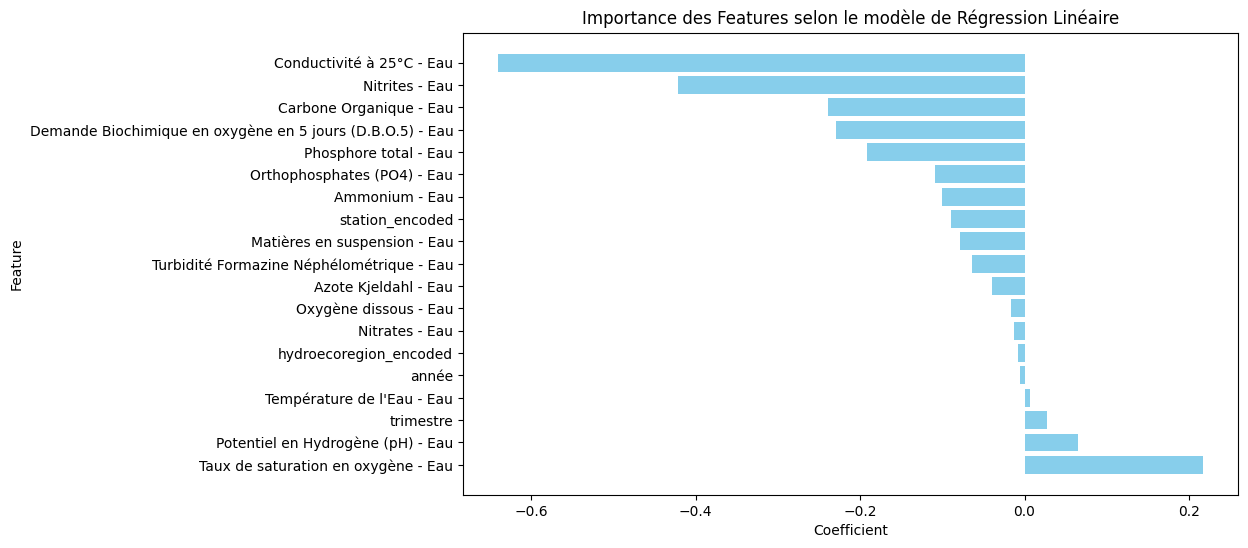

In [221]:
# Visualisation des coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df.index, coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Importance des Features selon le modèle de Régression Linéaire')
plt.show()


On regarde les caractéristiques qui participent le plus à la détermination de l'indice I2M2 en regardant les valeurs absolues des différens paramètres.

In [222]:
coef_df_sorted_abs = coef_df.abs().sort_values('Coefficient', ascending=False)
print(coef_df_sorted_abs)

                                                    Coefficient
Conductivité à 25°C - Eau                              0.640112
Nitrites - Eau                                         0.420908
Carbone Organique - Eau                                0.238602
Demande Biochimique en oxygène en 5 jours (D.B....     0.228816
Taux de saturation en oxygène - Eau                    0.216832
Phosphore total - Eau                                  0.191791
Orthophosphates (PO4) - Eau                            0.108816
Ammonium - Eau                                         0.100480
station_encoded                                        0.089366
Matières en suspension - Eau                           0.078234
Potentiel en Hydrogène (pH) - Eau                      0.064725
Turbidité Formazine Néphélométrique - Eau              0.063309
Azote Kjeldahl - Eau                                   0.039886
trimestre                                              0.027391
Oxygène dissous - Eau                   

### Résultats 

D'après les coefficients les plus éloignés de zéro, les six caractéristiques les plus influentes pour la prédiction de I2M2 sont, dans l'ordre :

- Conductivité à 25°C - Eau
- Nitrites - Eau
- Carbone Organique - Eau
- Demande Biochimique en oxygène en 5 jours
- Taux de saturation en oxygène - Eau
- Phosphore total - Eau


---

## Régularisation 

Nous utilisons la régression Lasso, qui applique une régularisation L1, pour identifier les caractéristiques ayant un véritable impact sur la prédiction de 
I2M2. Cette régularisation L1 permet de réduire à zéro les coefficients des variables les moins influentes, ce qui nous aide à déterminer quelles caractéristiques physicochimiques ont le plus d'impact sur les données hydrobiologiques.

In [223]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.005)
cv_scores = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = -cv_scores.mean()

print(f"Mean CV score: {mean_cv_score}")

Mean CV score: 0.03731374537661418


In [224]:
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_
lasso_coef_df = pd.DataFrame(lasso_coef, index=features, columns=['Coefficient'])
lasso_coef_df = lasso_coef_df.sort_values('Coefficient', ascending=False)
print(lasso_coef_df)

                                                    Coefficient
année                                                  0.000000
Ammonium - Eau                                        -0.000000
Azote Kjeldahl - Eau                                  -0.000000
Matières en suspension - Eau                          -0.000000
Demande Biochimique en oxygène en 5 jours (D.B....    -0.000000
Orthophosphates (PO4) - Eau                           -0.000000
Nitrites - Eau                                        -0.000000
Oxygène dissous - Eau                                  0.000000
Taux de saturation en oxygène - Eau                    0.000000
Potentiel en Hydrogène (pH) - Eau                      0.000000
Phosphore total - Eau                                 -0.000000
Turbidité Formazine Néphélométrique - Eau             -0.000000
trimestre                                              0.000000
station_encoded                                       -0.000000
Température de l'Eau - Eau              

In [225]:
print(f"Nombre de features gardées : {sum(lasso_coef != 0)}")

Nombre de features gardées : 3


In [226]:
print("Résulats : les caractéristiques les plus importantes selon le modèle Lasso")
df_lasso_coef = lasso_coef_df[lasso_coef_df['Coefficient'] != 0]
df_lasso_coef_sorted = df_lasso_coef.abs().sort_values('Coefficient', ascending=False)
print(df_lasso_coef_sorted)

Résulats : les caractéristiques les plus importantes selon le modèle Lasso
                           Coefficient
Conductivité à 25°C - Eau     0.528447
Carbone Organique - Eau       0.092639
Nitrates - Eau                0.001346


On retrouve des paramètres précédemment mentionnés.

## Conclusion

Notre travail a exploré la relation entre les données physicochimiques et hydrobiologiques dans le but de mieux comprendre les interactions entre ces paramètres et d'identifier des modèles spatiaux significatifs, tels que les hydroécorégions.

L'objectif principal était de déterminer si ces régions écologiques pouvaient être détectées à partir des données physicochimiques et hydrobiologiques, et comment les différents paramètres interagissent pour influencer l'état des écosystèmes aquatiques.

Nous avons choisi de prendre en compte différents laps de temps, à savoir 1 mois et 6 mois, afin d'étudier les relations de causalité entre les paramètres physicochimiques et les indicateurs hydrobiologiques. Cette approche nous a permis d'analyser les corrélations entre les variables et de nous interroger sur l'influence persistante de certains paramètres physicochimiques, malgré les variations saisonnières, sur l'état hydrobiologique. Ainsi, nous avons exploré dans quelle mesure la temporalité impacte ces interactions et si les paramètres physicochimiques peuvent prédire ou expliquer les dynamiques des écosystèmes aquatiques (les données hydrobiologiques) sur différentes périodes.

L'application du clustering K-means a introduit une nouvelle dimension dans notre étude : celle de l'identification des hydroécorégions à partir des données. Ce processus nous a permis de tester si des regroupements naturels des stations, basés sur leurs caractéristiques physicochimiques et hydrobiologiques, étaient observables. Nous avons également comparé l'impact des deux laps de temps (1 mois vs 6 mois) pour déterminer lequel offrait de meilleurs résultats dans la détection des hydroécorégions, en fonction de la dynamique des paramètres et de l'évolution des conditions environnementales.

Après avoir identifié le laps de temps optimal, nous avons réintégré les hydroécorégions dans notre dataset, puis entraîné un modèle de régression pour prédire I2M2. Cela nous a permis de déterminer les trois paramètres les plus influents pour la prédiction de I2M2. Enfin, nous avons appliqué une approche de régularisation (Lasso) pour identifier les caractéristiques physicochimiques ayant le plus de poids dans la prédiction de I2M2, nous permettant ainsi de mieux comprendre quels paramètres sont véritablement significatifs et présentent un lien concret avec les dynamiques écologiques sur le terrain.

##### Notre travail s'est structuré autour de plusieurs étapes clés :

- Préparation et analyse des données physicochimiques et hydrobiologiques
- Fusion des différents jeux de données avec les traitements préliminaires nécessaires
- Préparation des données pour le clustering des stations : choix du nombre de clusters, encodage des variables catégorielles, et normalisation
- Réalisation du clustering des stations en utilisant la méthode K-Means pour différents lags temporels
- Analyse des résultats obtenus pour chaque lag et comparaison des performances pour déterminer le laps de temps le plus cohérent
- Visualisation des résultats
- Réalisation d'une régression pour prédire I2M2 à partir des données, avec l'intégration des hydroécorégions, et application d'une régularisation afin d'identifier les variables physicochimiques ayant un impact réel sur la prédiction de I2M2

##### En résumé :

- Nous avons pu identifier les paramètres physicochimiques et hydrobiologiques qui permettent de différencier les différentes régions au cours du temps
- Nous avons constaté qu'un lag de 6 mois est plus pertinent qu'un lag de 1 mois, ce qui suggère que l'impact des données physicochimiques sur l'état hydrobiologique est plus prononcé à long terme
- Nous avons déterminé les paramètres physicochimiques les plus influents dans l'explication des dynamiques hydrobiologiques.

## Résultats



Les résultats du clustering des stations ont montré que, bien que prometteurs, seulement un tiers des stations ont été correctement classées dans leurs hydroécorégions respectives. Cela suggère que certaines hydroécorégions partagent des caractéristiques physicochimiques et hydrobiologiques trop similaires, rendant leur distinction difficile. En effet, les résultats obtenus avec les deux approches de clustering (1 mois et 6 mois) étaient relativement proches. Toutefois, l'approche avec un lag de 6 mois a permis de classer légèrement plus de stations correctement, avec une amélioration de 3 % par rapport à celle avec un lag de 1 mois.

En ce qui concerne les paramètres influençant le clustering des hydroécorégions, nous avons observé que, quel que soit le lag (1 mois ou 6 mois), les paramètres les plus discriminants sont :
- I2M2
- Nitrates
- Conductivité à 25°C
- Carbone organique
- Température de l'eau

La majorité de ces paramètres se sont distingués dans les centres des clusters, ce qui indique qu'ils sont les principaux facteurs influençant la formation des clusters. En particulier, I2M2, les nitrates, le carbone organique et la conductivité de l'eau apparaissent comme les indicateurs les plus significatifs pour différencier les hydroécorégions.

---

Concernant les résultats de la régression, les trois paramètres les plus importants pour la caractérisation de l’indice I2M2 sont la conductivité à 25°C, les nitrites et le carbone organique dans l'eau. Les résultats du modèle Lasso confirment cette tendance, avec la conductivité à 25°C, le carbone organique et les nitrates apparaissant comme les facteurs les plus significatifs.

Nous avons réutilisé le dataset avec un décalage temporel de 6 mois car nous avons observé que cette approche semble plus pertinente pour capturer la différence de temps entre les changements dans l'eau et leur impact sur l'hydrobiologie, comme expliqué précédemment.

Il est important de noter que les coefficients négatifs de la conductivité, des nitrites et du carbone organique dans la régression indiquent que ces paramètres sont associés à une diminution de l’indice I2M2. En d'autres termes, à mesure que ces paramètres augmentent, l'indice I2M2 a tendance à diminuer, ce qui pourrait suggérer que des concentrations plus élevées de ces éléments ont un impact négatif sur l'état hydrobiologique de l'eau.

Les matrices de corrélation ont également révélé des corrélations négatives entre I2M2, la conductivité à 25°C et les nitrates, renforçant ainsi l'idée que ces paramètres jouent un rôle central dans l’état de l'hydrobiologie de l'eau.


--- 
NB : À noter que nous avons également testé l'approche sans décalage temporel (comme détaillé dans ce notebook), mais les résultats se sont avérés moins bons que ceux obtenus avec un décalage de 1 mois.


---


## Limitations et biais

Pour le clustering des hydroécorégions : 
- Surreprésentation des données hydrobiologiques en été et sous-représentation en dehors de cette période.
- Les données physicochimiques sont régulières, mais l'hydrobiologie est biaisée par la saisonnalité.
- Lors de la jointure des données, perte de 50 % des stations, réduisant ainsi la taille de l'échantillon en raison du faible nombre de relevés.
- Déséquilibre dans le nombre de stations par région, ce qui introduit des biais dans l’analyse.
- Suppression de certaines combinaisons de paramètres physicochimiques en raison de leur faible représentation.
- Beaucoup d’imputation des valeurs manquantes par la médiane, ce qui peut affecter la précision des résultats.
- Suppression des outliers via la médiane, en raison du nombre limité de données, pour éviter l'impact de valeurs extrêmes. La médiane a été choisie car elle est moins sensible aux valeurs aberrantes et reflète mieux la tendance centrale dans des ensembles de données hétérogènes.

Pour la régression : 
- Une méthode de clustering améliorée, permettant de mieux ajuster le lag temporel entre les données physicochimiques et hydrobiologiques, pourrait potentiellement conduire à des résultats plus représentatifs. En effet, on aurait pu extraire un autre dataset (avec le lag de temps "optimal"). 

Cependant : 
- Nous avons réussi à prédire l'I2M2 avec une erreur moyenne raisonnable en régression.
- Les mêmes paramètres importants apparaissent régulièrement entre la régression, la régularisation et les corrélations, ce qui renforce la robustesse des résultats obtenus, et suggère que l'analyse est globalement fiable.

---

## Pistes

Pour le clustering des hydroécorégions : 
- Tester d'autres lags de temps pour mieux capturer les variations saisonnières (1 an serait très intéressant car on pourrait capturer les impacts saisonniers tout en tenant compte du décalage temporel entre les données physicochimiques et hydrobiologiques).
- Explorer différentes méthodes d'agrégation des valeurs, comme l'utilisation de la moyenne.
- Essayer d'autres agrégations temporelles (par exemple, par mois ou par année).

Une étude plus approfondie, incluant une répartition plus homogène des données et une exploration d’autres périodes temporelles, pourrait affiner la détection des hydroécorégions et améliorer la compréhension des facteurs physicochimiques et hydrobiologiques qui influencent les écosystèmes aquatiques.

Concernant la méthode de clustering, des approches alternatives comme le K-Means avec Dynamic Time Warping (DTW) ou l’utilisation de K-Medoids pourraient être envisagées. Ces techniques pourraient permettre une meilleure gestion des séries temporelles et une meilleure distinction des groupes d’hydroécorégions, en tenant compte de la nature dynamique des données.

Ces différentes perspectives ouvrent la voie à une meilleure compréhension des interactions complexes entre les facteurs physicochimiques et hydrobiologiques, et à une amélioration des méthodes d’analyse utilisées pour détecter et caractériser les hydroécorégions.